# Proton Beam Treatment Planning

###### Tania Morales Santiago

This Jupyter Notebook analysis on different mathematical models that help generate the Spread Out Bragg Peak. The aim was to provide treatment planning options by finding the optimal number of Bragg peak curves and energy intensities that minimise the error between the targeted dose and the weighted average of the Bragg Peak curve. Utilising the Least-squares, smoothing splines, Quadratic programming optimisation, regularisation. Computational complexity and error measurements can also be found. At the end of the code is a section dedicated to reading CT scans and SPR images.

## Required Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special.cython_special 
import math as math

from scipy.misc import derivative as dv 
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

#from qpsolvers import solve_qp
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

# for complexity
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.preprocessing import PolynomialFeatures

# for zoom in images
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


#### Defining the unchanging parameters.

Parameters below are taken from "An analytical approximation of the Bragg curve for therapeutic proton beams", under the assumption that the medium is water.

In [85]:
#Primary stage Parameters - not affected by Beam Initial Energy
p = 1.77
alpha = 0.0022
beta = 0.012
gamma = 0.6
epsilon = 0.0 #ranges 0.0 to 0.2
e_2 = 997 # density of the medium #rho
sd = 0.01

##### Functions to Calculate Parameters for the Curve 

Firsty we need to calculate the displacement over which the our PBC covers, and the equation for the individual PBC.

$$
D(z) = \Phi_0 \frac{e^{-\zeta^{2/4}}\sigma^{1/p}\Gamma(1/p)}{\sqrt{2\pi}\rho p \alpha^{1/p}(1+\beta R_0)}\times \left[\frac{1}{\sigma} \mathscr{D}_{-1/p}(-\zeta)+\left(\frac{\beta}{p}+\gamma \beta + \frac{\epsilon}{R_0}\right)\mathscr{D}_{-1/p-1}(-\zeta) \right]
$$
with $\zeta=\frac{R_0-z}{\sigma}$ and $\mathscr{D}_{y}$ is the parabolic cylinder function


In [3]:
def Functionb(x,eZero):
    rZero = alpha*(pow(eZero,p))*1.1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    
    return(y)

##### Function used  multiply two bragg peaks together:

In [4]:
def Function3b(x,eZeroi,eZeroj): #used to fill M for the quadrature method.  
    a = Functionb(x,eZeroi)
    b = Functionb(x,eZeroj)
    c = a*b
    return(c)

In [5]:
## Target Tumor Range.

def PlotSimpleBox(): 
    #takes no aguments, plots dashed lines of tumour range and doseage required
    plt.hlines(y=0.05,xmin = 10,xmax = 12, color='r', linestyles='dashed')
    plt.vlines(x=10,ymin = 0,ymax = 0.05, color='r', linestyles='dashed')
    plt.vlines(x=12,ymin = 0,ymax = 0.05, color='r', linestyles='dashed', label = "Target Range")

def PlotCustomBox(upper,lower,dose):
    # takes three aguments. Upper and lower displacement values and target doseage value.
    # plots dashed lines of tumour range and doseage required
    plt.hlines(y=dose,xmin = lower,xmax = upper, color='r', linestyles='dashed')
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='r', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='r', linestyles='dashed') #, label = "Target Range"'
    

Individual Bragg curve with energy intensity of 120

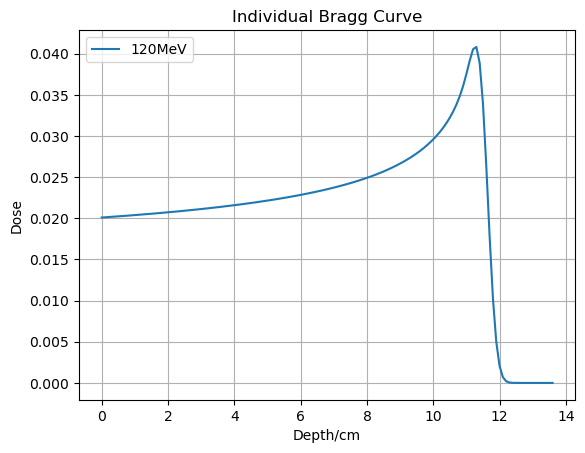

In [6]:
eZero=120
z = np.arange(0,(alpha)*(eZero**p)*1.3,0.1)
curve = Functionb(z,eZero)
plt.plot(z,curve, label = (str(eZero)+ "MeV"))
plt.xlabel("Depth/cm")
plt.ylabel("Dose")
plt.title("Individual Bragg Curve")    
plt.legend(loc='best')
plt.grid(True)
#plt.savefig("monoenergeticbc.pdf")
plt.show()


Individual Bragg curve with energy intensity of 130 targeted towards the tumour region with a piecewise function for the target dosage

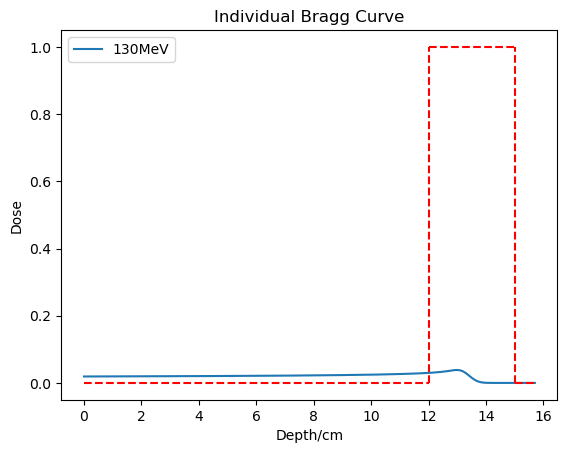

In [7]:
eZero=130
upper = 15
lower = 12
dose=1
z = np.arange(0,(alpha)*(eZero**p)*1.3,0.1)
curve = Functionb(z,eZero)
plt.plot(z,curve, label = (str(eZero)+ "MeV"))
plt.xlabel("Depth/cm")
plt.ylabel("Dose")
plt.title("Individual Bragg Curve")    
plt.legend(loc='upper left')
plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
PlotCustomBox(upper,lower,dose)
plt.savefig("monoenergetic_dose.pdf")
plt.show()


Text(0, 0.5, 'Dose')

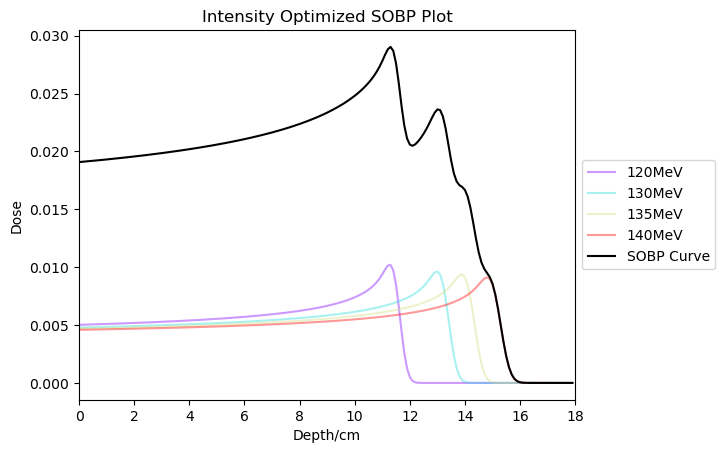

In [8]:
eVals = [120,130,135,140]
z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
curve = Functionb(z,eZero)
omega = [0.25,0.25,.25,.25]
dList = [] 
colors = cm.rainbow(np.linspace(0, 1, 4))
for i in range(len(omega)):  #for all the weights 
    dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
    plt.plot(z,dList[i], label = str(round(eVals[i]))+'MeV', color = colors[i], alpha = 0.4)
d = sum(dList) #sum the di's
plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
plt.title("Intensity Optimized SOBP Plot")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,dose+0.3])
plt.xlim([0,18])
plt.xlabel("Depth/cm")
plt.ylabel("Dose")
#plt.savefig("sobp.pdf",bbox_inches='tight')

## Least squares 

In [9]:
def OptimiseLAb(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        #SeteValGlobal(eVals[i])
        for j in range(n): # for n evaleus 
          #  SeteValGlobal2(eVals[j])
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

     ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    colors = cm.rainbow(np.linspace(0, 1, n))
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        #plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        plt.plot(z,dList[i], label = str(round(eVals[i]))+'MeV', color = colors[i], alpha = 0.4)

        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.xlim([0,18])
    plt.xlabel("Depth/cm")
    plt.ylabel("Dose")
    return(m,omega,f,d)



def OptimiseLAbNoPlot(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        #SeteValGlobal(eVals[i])
        for j in range(n): # for n evaleus 
           # SeteValGlobal2(eVals[j])
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
   
    return(m,omega,f,d)

The unconstrained solution is optimal.
Final cost 1.9259e-34, first-order optimality 2.70e-20


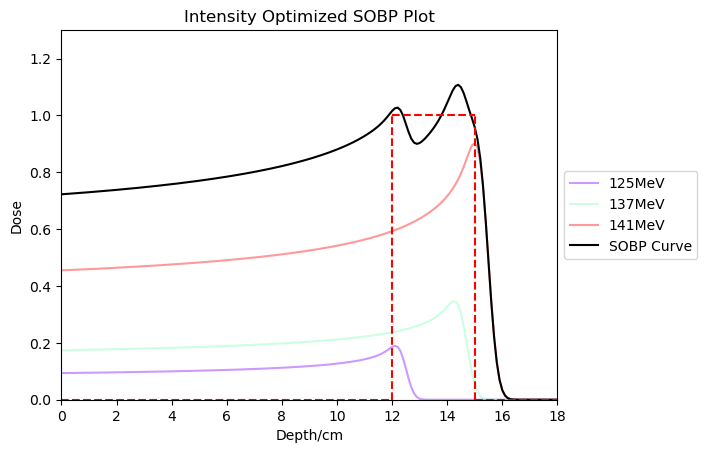

In [10]:
eVals = [125,137,141]
lower = 12;upper = 15; dose = 1
m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)

The first-order optimality measure is less than `tol`.
Number of iterations 17, initial cost 6.7278e-01, final cost 2.2484e-11, first-order optimality 5.17e-11.


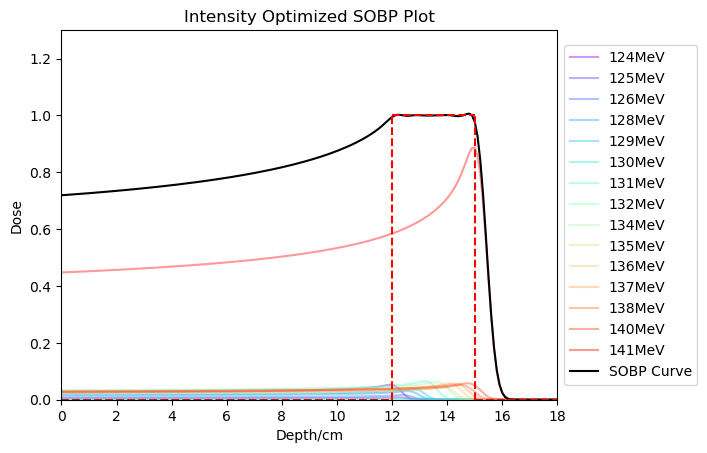

In [11]:
eVals = np.arange(124,141,1.2)
lower = 12;upper = 15; dose = 1
m,b,f,d = OptimiseLAb(lower,upper,dose,eVals)
#plt.savefig('leastsquares_124_141.pdf', bbox_inches='tight')


#### Intensity Progression - Number of Curves, $n$ increases

[124. 141.]
The unconstrained solution is optimal.
Final cost 1.0232e-34, first-order optimality 3.44e-20


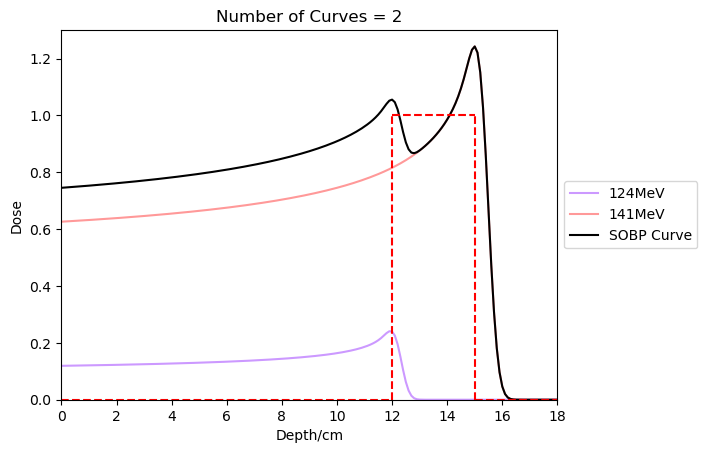

[124.  132.5 141. ]
The unconstrained solution is optimal.
Final cost 3.1296e-34, first-order optimality 3.68e-20


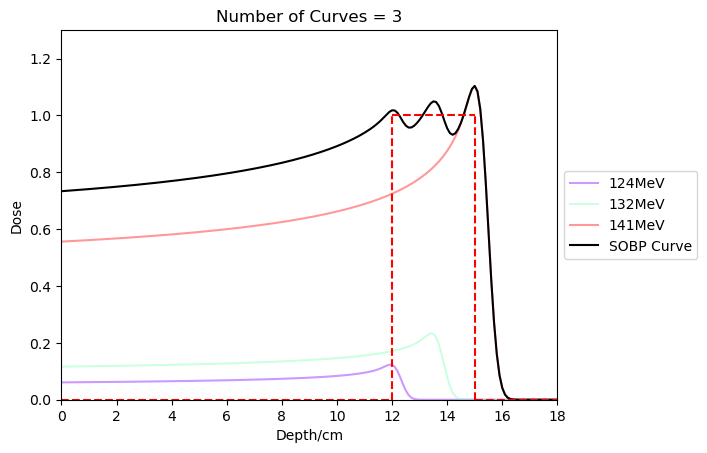

[124.         129.66666667 135.33333333 141.        ]
The unconstrained solution is optimal.
Final cost 7.9445e-34, first-order optimality 3.83e-20


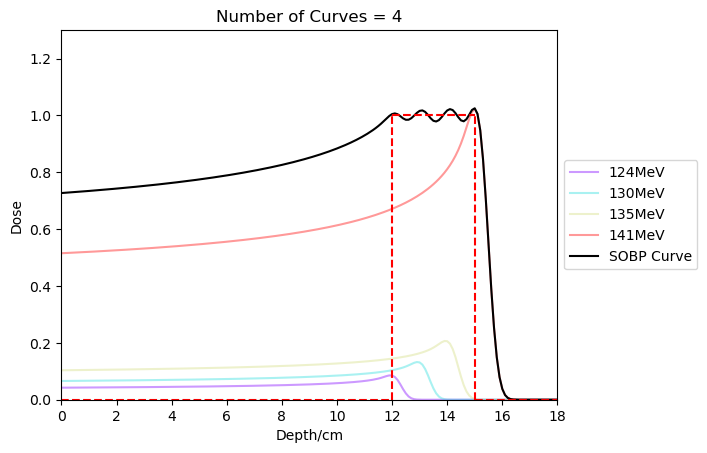

[124.   128.25 132.5  136.75 141.  ]
The unconstrained solution is optimal.
Final cost 1.5046e-34, first-order optimality 3.23e-20


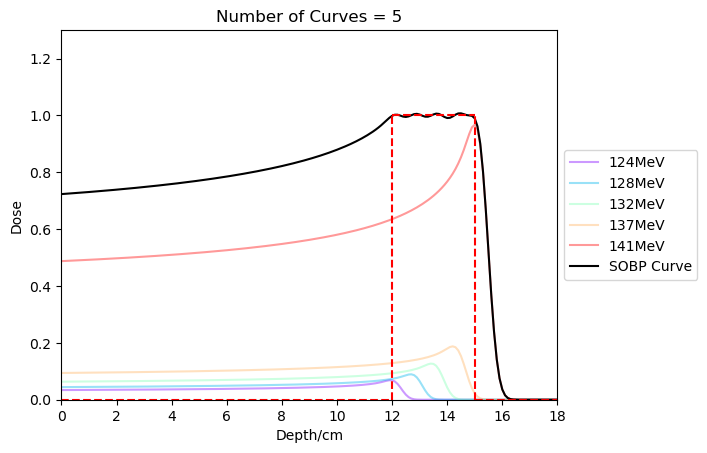

[124.  127.4 130.8 134.2 137.6 141. ]
The unconstrained solution is optimal.
Final cost 1.3060e-33, first-order optimality 2.08e-19


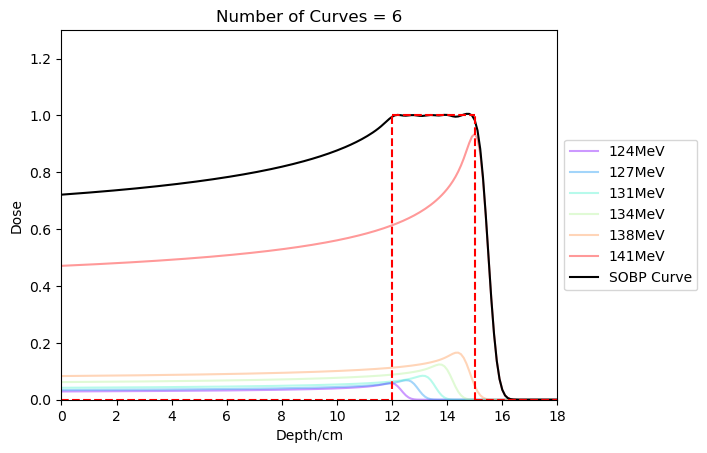

[124.         126.83333333 129.66666667 132.5        135.33333333
 138.16666667 141.        ]
The unconstrained solution is optimal.
Final cost 2.6327e-32, first-order optimality 1.11e-18


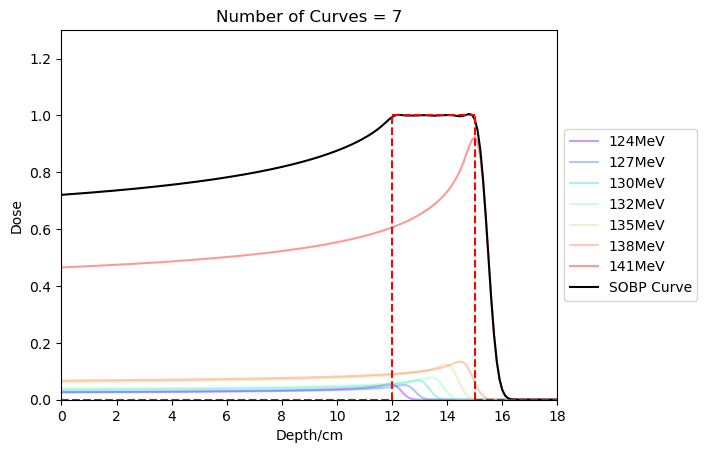

[124.         126.42857143 128.85714286 131.28571429 133.71428571
 136.14285714 138.57142857 141.        ]
The unconstrained solution is optimal.
Final cost 4.4778e-33, first-order optimality 3.71e-19


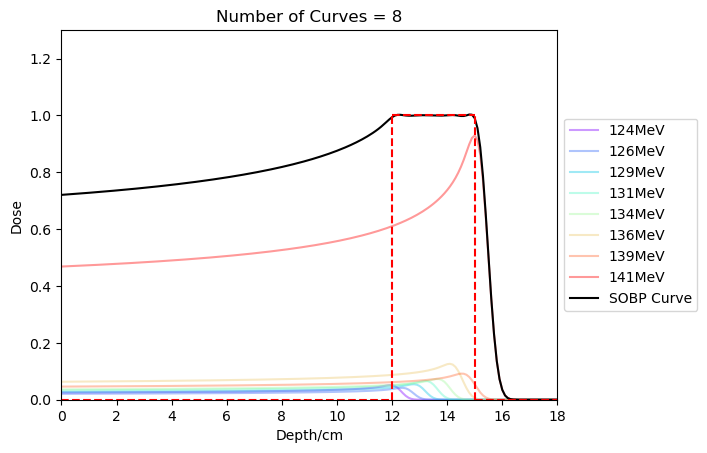

[124.    126.125 128.25  130.375 132.5   134.625 136.75  138.875 141.   ]
The unconstrained solution is optimal.
Final cost 1.4378e-32, first-order optimality 9.29e-19


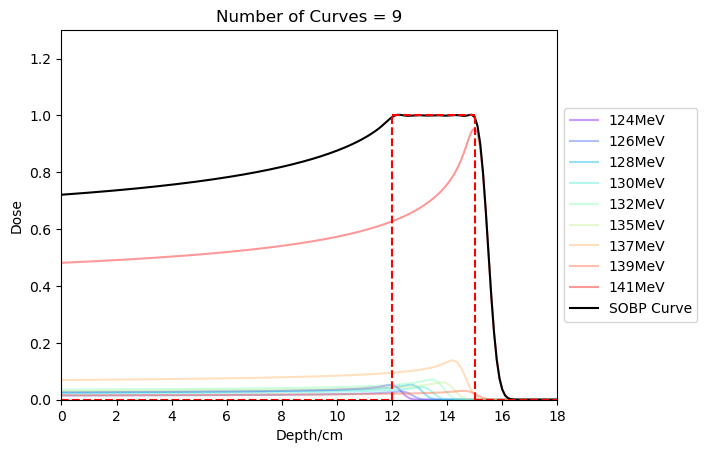

[124.         125.88888889 127.77777778 129.66666667 131.55555556
 133.44444444 135.33333333 137.22222222 139.11111111 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 5, initial cost 6.9620e-05, final cost 5.5927e-13, first-order optimality 2.33e-11.


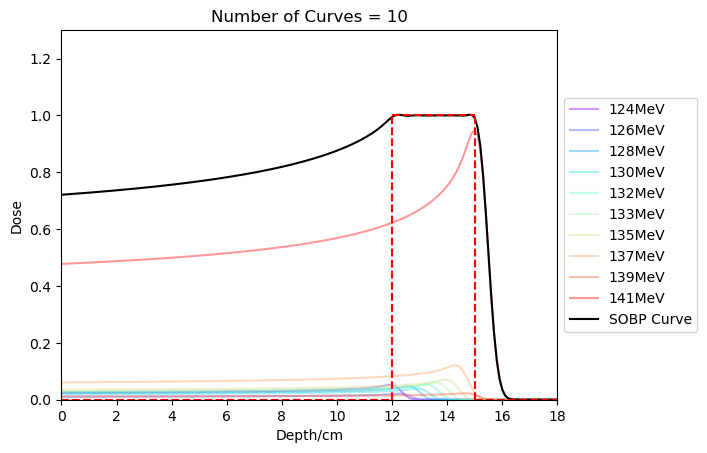

[124.  125.7 127.4 129.1 130.8 132.5 134.2 135.9 137.6 139.3 141. ]
The first-order optimality measure is less than `tol`.
Number of iterations 11, initial cost 1.3550e-03, final cost 8.9656e-12, first-order optimality 4.68e-11.


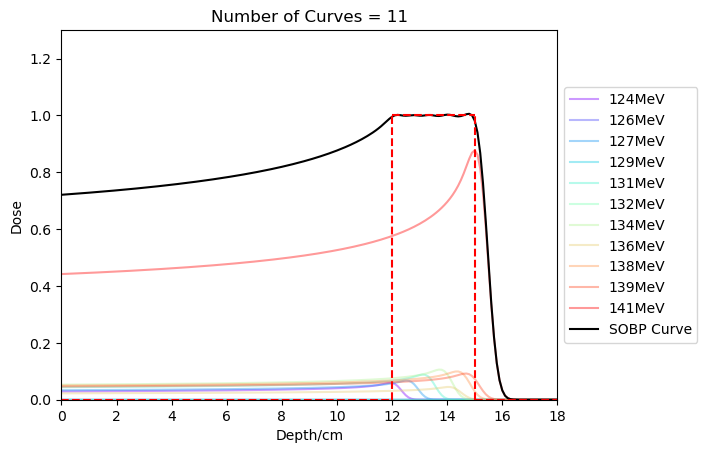

[124.         125.54545455 127.09090909 128.63636364 130.18181818
 131.72727273 133.27272727 134.81818182 136.36363636 137.90909091
 139.45454545 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 15, initial cost 3.8051e-03, final cost 5.1170e-12, first-order optimality 2.60e-11.


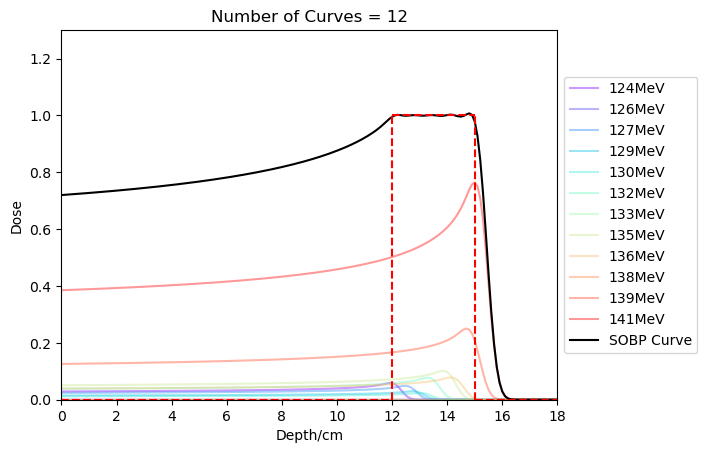

[124.         125.41666667 126.83333333 128.25       129.66666667
 131.08333333 132.5        133.91666667 135.33333333 136.75
 138.16666667 139.58333333 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 25, initial cost 3.1301e-02, final cost 4.4189e-11, first-order optimality 4.92e-11.


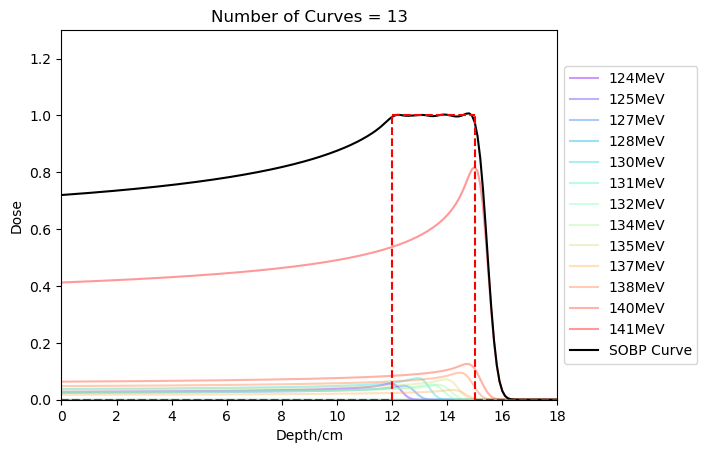

[124.         125.30769231 126.61538462 127.92307692 129.23076923
 130.53846154 131.84615385 133.15384615 134.46153846 135.76923077
 137.07692308 138.38461538 139.69230769 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 18, initial cost 3.1472e-02, final cost 1.4394e-11, first-order optimality 9.50e-11.


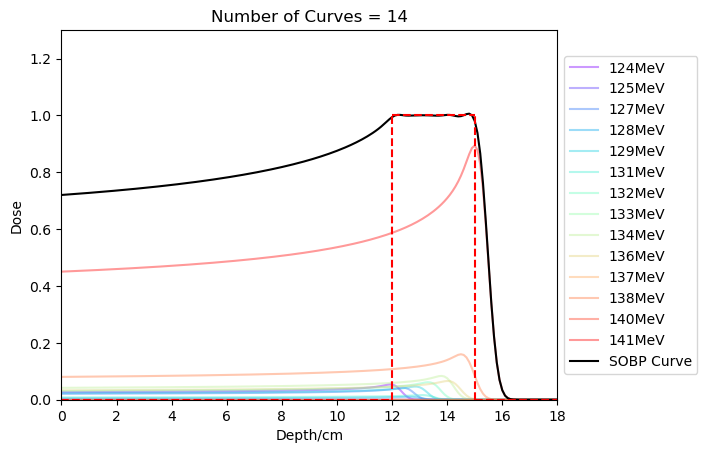

[124.         125.21428571 126.42857143 127.64285714 128.85714286
 130.07142857 131.28571429 132.5        133.71428571 134.92857143
 136.14285714 137.35714286 138.57142857 139.78571429 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 17, initial cost 5.3032e-01, final cost 3.7701e-11, first-order optimality 9.62e-11.


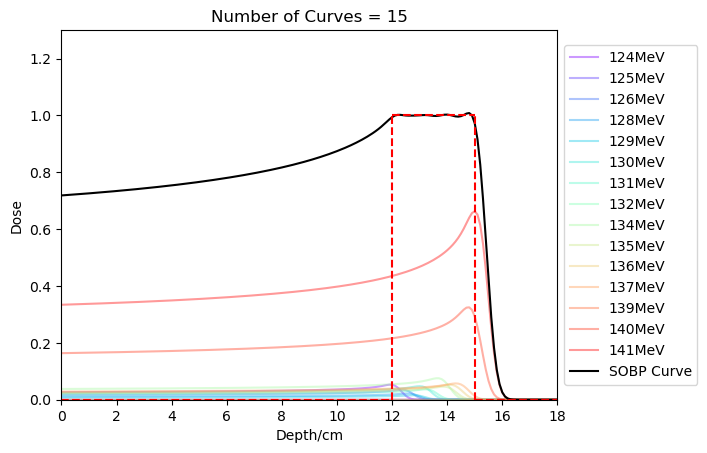

[124.         125.13333333 126.26666667 127.4        128.53333333
 129.66666667 130.8        131.93333333 133.06666667 134.2
 135.33333333 136.46666667 137.6        138.73333333 139.86666667
 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 23, initial cost 2.7636e-01, final cost 3.2828e-11, first-order optimality 3.53e-11.


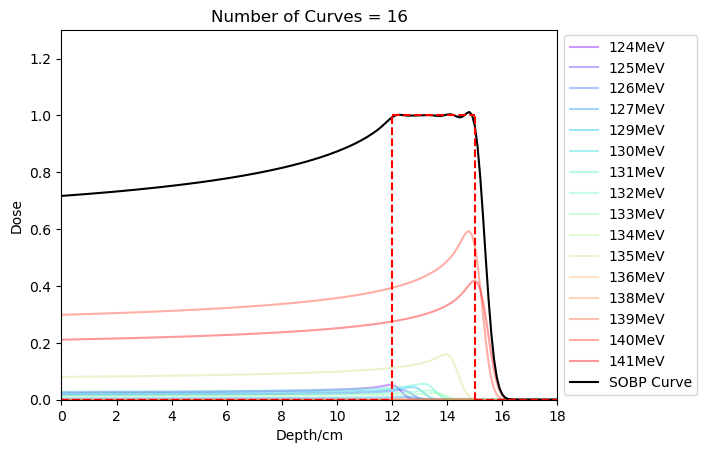

[124.     125.0625 126.125  127.1875 128.25   129.3125 130.375  131.4375
 132.5    133.5625 134.625  135.6875 136.75   137.8125 138.875  139.9375
 141.    ]
The first-order optimality measure is less than `tol`.
Number of iterations 24, initial cost 1.1880e+01, final cost 3.1490e-12, first-order optimality 1.20e-11.


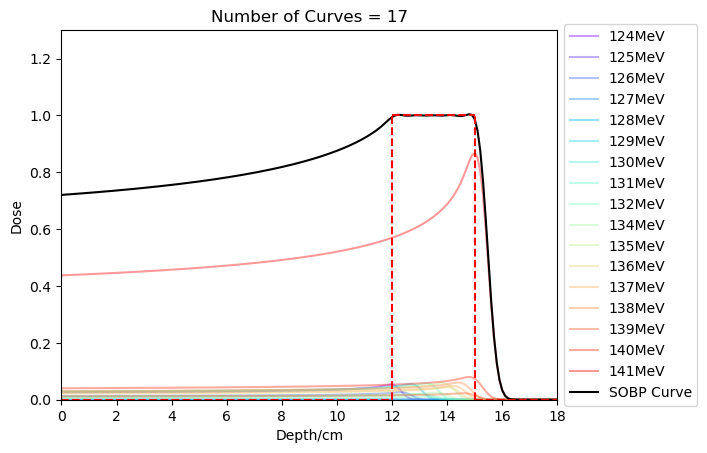

[124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 138. 139. 140. 141.]
The first-order optimality measure is less than `tol`.
Number of iterations 24, initial cost 8.7243e+00, final cost 2.1155e-11, first-order optimality 2.61e-11.


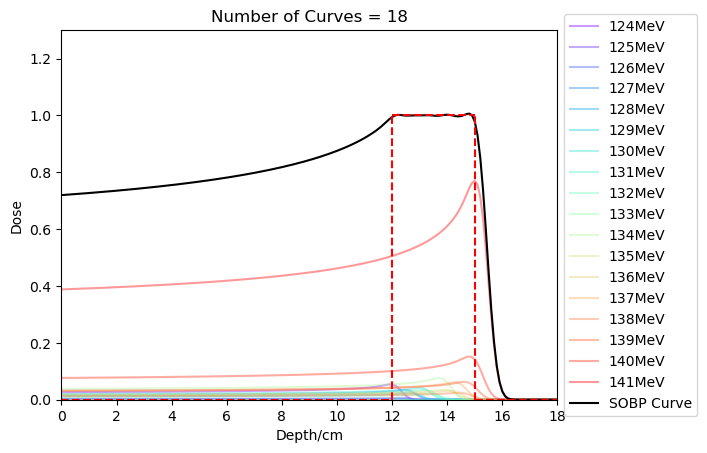

[124.         124.94444444 125.88888889 126.83333333 127.77777778
 128.72222222 129.66666667 130.61111111 131.55555556 132.5
 133.44444444 134.38888889 135.33333333 136.27777778 137.22222222
 138.16666667 139.11111111 140.05555556 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 29, initial cost 1.0906e+01, final cost 4.3856e-11, first-order optimality 7.52e-11.


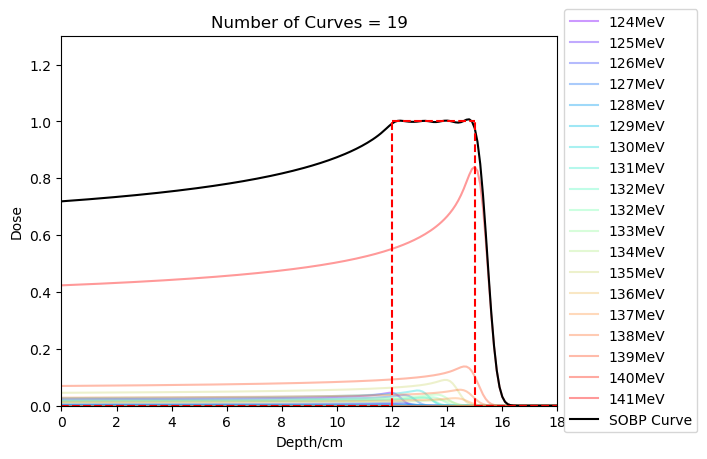

[124.         124.89473684 125.78947368 126.68421053 127.57894737
 128.47368421 129.36842105 130.26315789 131.15789474 132.05263158
 132.94736842 133.84210526 134.73684211 135.63157895 136.52631579
 137.42105263 138.31578947 139.21052632 140.10526316 141.        ]
The first-order optimality measure is less than `tol`.
Number of iterations 35, initial cost 2.6804e+02, final cost 2.7151e-11, first-order optimality 4.26e-11.


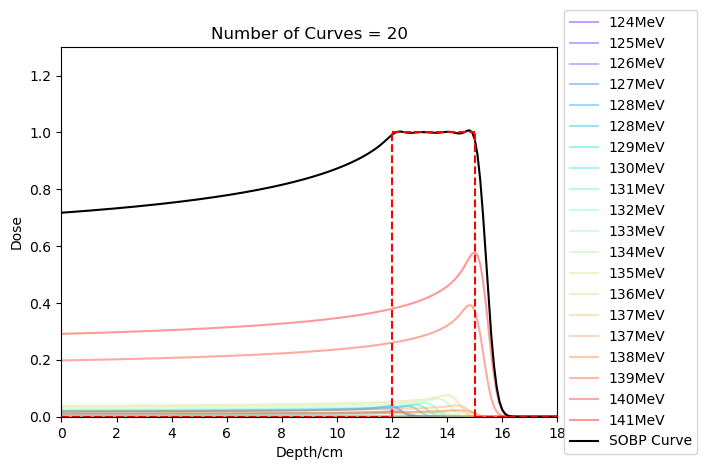

In [12]:
lower = 12;upper = 15; dose = 1; eZeroUpper = 141;eZeroLower = 124
n = 20
for i in range(2,n+1): #plots SOBP for different numbers of curves
    eVals = []
    eVals = np.linspace(eZeroLower,eZeroUpper,i)
    print(eVals)
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Number of Curves = "+ str(len(eVals)))
    if i in (2,4,6,8,10,12,14,16,18,20):
        plt.savefig(f'plot_lesq_{i}.pdf',bbox_inches='tight')
    plt.show()

The first-order optimality measure is less than `tol`.
Number of iterations 17, initial cost 6.7278e-01, final cost 2.2484e-11, first-order optimality 5.17e-11.


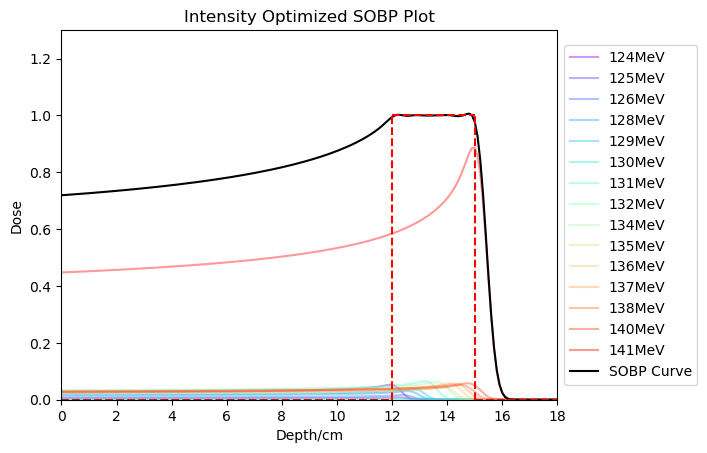

In [13]:
eVals = np.arange(124,141,1.2)
lower = 12;upper = 15; dose = 1
m,b,f,d =OptimiseLAb(lower,upper,dose,eVals)

# Error measurement

In [14]:
def GetDb(x,omega,eVals): #calculates the SOBP
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*Functionb(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetDb(x,omega,eVals)
    y = pow(abs(d-1),2) #difference between SOBP - the tumour #l2 norm is differentiable, preserves order
   # y = np.linalg.norm(d-1)
    return(y)

#def GetQuadratureTSqrt(omega,eVals): #Calculates sqrt root of the integral of norm squared. 
 #   lower = 12;upper = 15
  #  val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
   # print(err)
    #y = np.sqrt(val)
    #return(y)

def GetQuadratureTSqrt(omega,eVals): #Calculates sqrt root of the integral of norm squared. 
    lower = 12;upper = 15
    den = upper - lower
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
    print(err)
    y = np.sqrt(val/den)
    return(y)

In [15]:
def PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper,ncurves):
    n = ncurves
    eVals = [] #defines list of energy values
    yValues = [] 
    
    x = 0 #initialise depth
    
    for i in range(2,n+1): #plots SOBP for different numbers of curves
        eVals = []
        eVals = np.linspace(eZeroLower,eZeroUpper,i)
        print(str(len(eVals))+" Curves")
        print(str(eVals))
        m,omega,f,d =OptimiseLAbNoPlot(lower,upper,dose,eVals)
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
        plt.show()
    
    x = np.arange(2,n+1)
    
    #Error stagnation plot
    plt.plot(x,yValues)
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Log y scale of error")
    plt.xlabel("n Curves")
    plt.title("Error over target tumour")
    plt.xticks(x)

    plt.grid(True)
    #plt.savefig('Error_least_squares.pdf', bbox_inches='tight')
    
    plt.show()

    #finding best and other n for error plots  
        
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            nminerr = i+2  #minimum error
        
        elif yValues[i] == max(yValues):
            n3 = i+2 #max error
    
     #Error stagnation plot
    plt.plot(x,yValues)
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("n Curves used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.xticks(x)
    plt.grid(True)
    
    plt.show()
    
    # All Bragg peaks used
    plt.figure()
    x = np.arange(0,20,0.05)
    for i in eVals:
        plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    
   
    
    #finding best and other n for error plots  
    
    nMin = min(yValues)
    nmax = max(yValues)
    
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            n = i+2
        
        elif yValues[i] == max(yValues):
            n3 = i+2
        
    yValues.remove(yValues[n-2])
    for i in range(len(yValues)):

        if yValues[i] == min(yValues):
            n2 = i+2
            
        
    
    difference = eZeroUpper-eZeroLower
    
     # Minimal error plot 
    plt.figure()
    print("n_least error = "+ str(n))
    eVals = []
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/n)
    eVals.append(eZeroUpper)
    print(len(eVals))
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Most Minimized Error Curve Plot, n = "+ str(n))
   # plt.savefig('Error_least_squares_min_n.pdf', bbox_inches='tight')
    plt.show()
    
    
    # Second best minimal error plot
    plt.figure()
    
    eVals = []
    for j in range(n2-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Second Most Minimized Error Plot, n = "+ str(n2))
    plt.show()
   
    #Worst minimal error plot from minimised solution
    plt.figure()
    
    eVals = []
    for j in range(n3-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("highest error Plot of minimised solution, n = "+ str(n3))
    plt.show()
    
    
    return(yValues)


2 Curves
[123. 141.]
The unconstrained solution is optimal.
Final cost 1.0984e-34, first-order optimality 3.42e-20
2.899279873053202e-10
3 Curves
[123. 132. 141.]
The unconstrained solution is optimal.
Final cost 4.9502e-34, first-order optimality 4.31e-20
1.4088108706478902e-13
4 Curves
[123. 129. 135. 141.]
The unconstrained solution is optimal.
Final cost 1.5046e-36, first-order optimality 4.80e-22
2.0269864107800605e-13
5 Curves
[123.  127.5 132.  136.5 141. ]
The unconstrained solution is optimal.
Final cost 7.5984e-34, first-order optimality 1.46e-19
1.2930576141539492e-13
6 Curves
[123.  126.6 130.2 133.8 137.4 141. ]
The unconstrained solution is optimal.
Final cost 5.9117e-33, first-order optimality 4.24e-19
1.2929436125189739e-13
7 Curves
[123. 126. 129. 132. 135. 138. 141.]
The unconstrained solution is optimal.
Final cost 2.4992e-33, first-order optimality 3.29e-19
1.9840367254399363e-12
8 Curves
[123.         125.57142857 128.14285714 130.71428571 133.28571429
 135.8571428

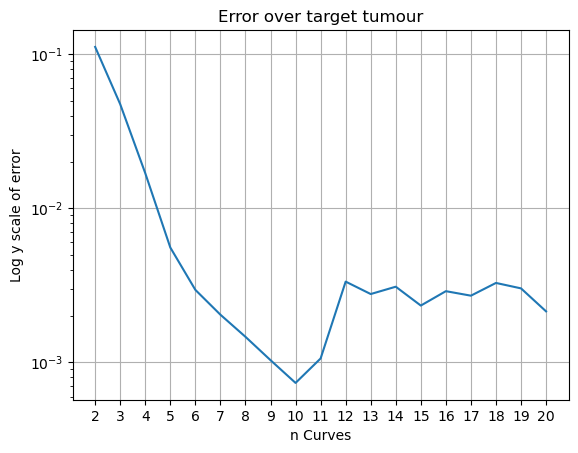

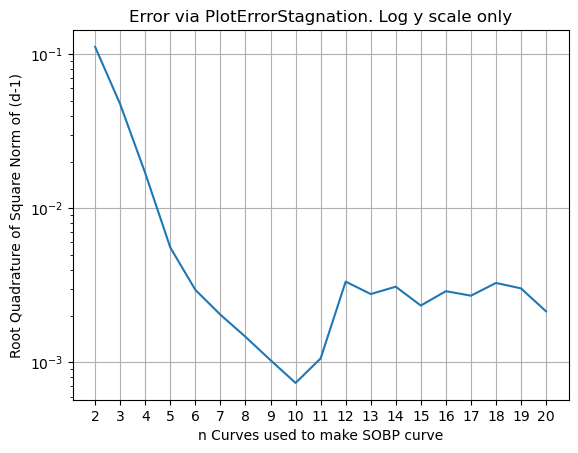

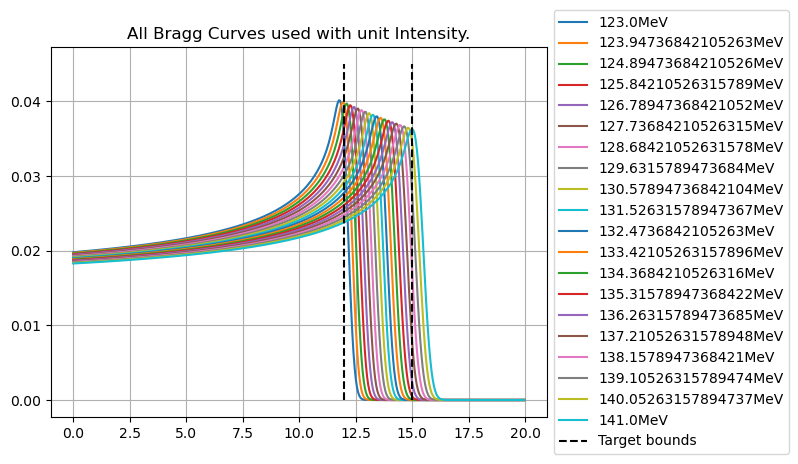

n_least error = 10
10
The unconstrained solution is optimal.
Final cost 1.7209e-31, first-order optimality 3.17e-18


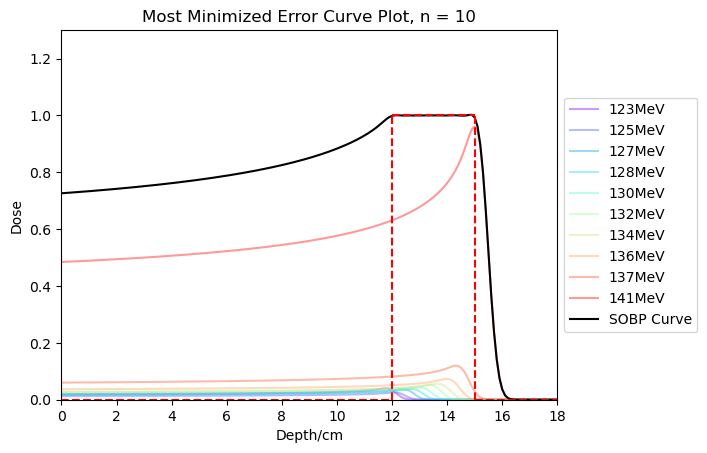

9
The unconstrained solution is optimal.
Final cost 7.8271e-32, first-order optimality 2.01e-18


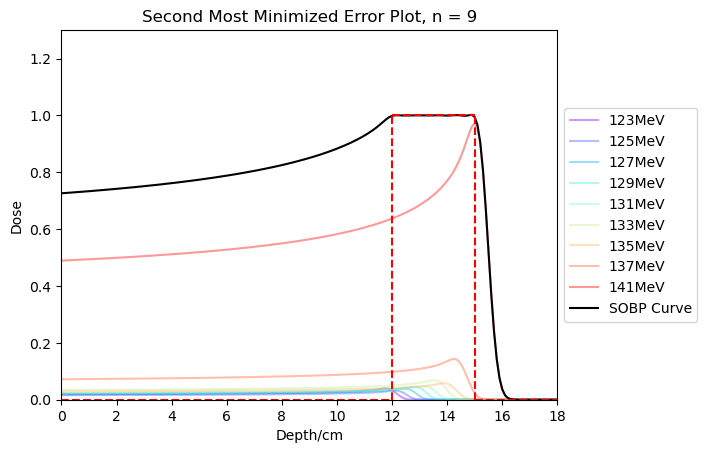

2
The unconstrained solution is optimal.
Final cost 1.0984e-34, first-order optimality 3.42e-20


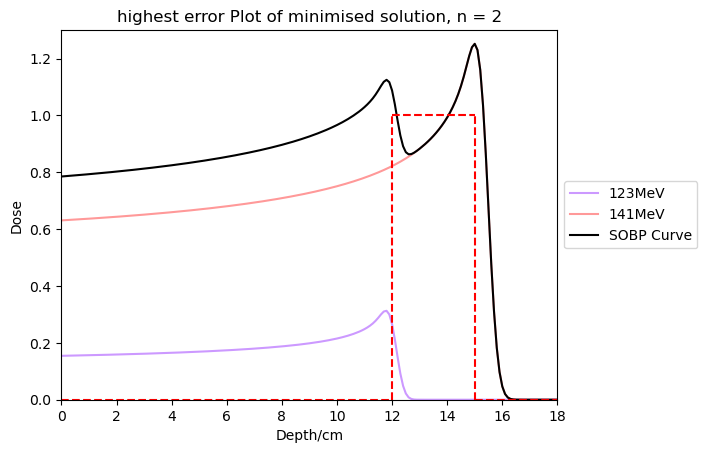

In [16]:
lower = 12;upper=15;dose = 1;eZeroLower = 123;eZeroUpper = 141
ncurves = 20
yValues = PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper,ncurves)

# Smoothing splines

# $\underline{A_{ij}} = \int_Tb_i(x) b_j(x) .dx + \psi\int_T b_i''(x)b_j''(x)$

In [17]:
#First derivative
def FunctionDeriv1(x,eVal):

    h = 0.00001
    deriv = (Functionb((x+h),eVal) - Functionb(x,eVal))/(h)
    
    return(deriv)

def FunctionDeriv_mult(x,eVals):
    a = FunctionDeriv1(x,eVals[0])
    b = FunctionDeriv1(x,eVals[1])
    return(a*b)
    

In [18]:
#Second derivative
def FunctionDeriv(x,eVal):

    h = 0.00001
    deriv = (Functionb((x+h),eVal) - 2*Functionb(x,eVal) + Functionb((x-h),eVal))/(h**2)
    
    return(deriv)

def FunctionDeriv3(x,eVals):
    a = FunctionDeriv(x,eVals[0])
    b = FunctionDeriv(x,eVals[1])
    return(a*b)
    

In [19]:
def PenalizeDerivative(lower,upper,dose,eVals,theta,phi,psi):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            
            valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))
            valCorrected = valCorrected + psi*(valDeriv)
            
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    # PLOTTING INDIVIDUAL BRAGG PEAKS
    colors = cm.rainbow(np.linspace(0, 1, n))
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        #plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        plt.plot(z,dList[i], label = str(round(eVals[i]))+'MeV', color = colors[i], alpha = 0.4)

        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Depth/cm")
    plt.ylabel("Dose")
    plt.ylim([0,1.5])
    plt.xlim([0,18])
    
    return(m,omega,f,d)


C:\Users\sgome\AppData\Local\Temp\ipykernel_28900\3067253581.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))


The first-order optimality measure is less than `tol`.
Number of iterations 5, initial cost 6.9620e-05, final cost 5.5927e-13, first-order optimality 2.33e-11.
omega (weights) = [ 1.31149578  0.54296646  1.20432894  1.01992186  1.38540387  1.58843006
  1.89007307  3.27543447  0.6222344  26.12943717]


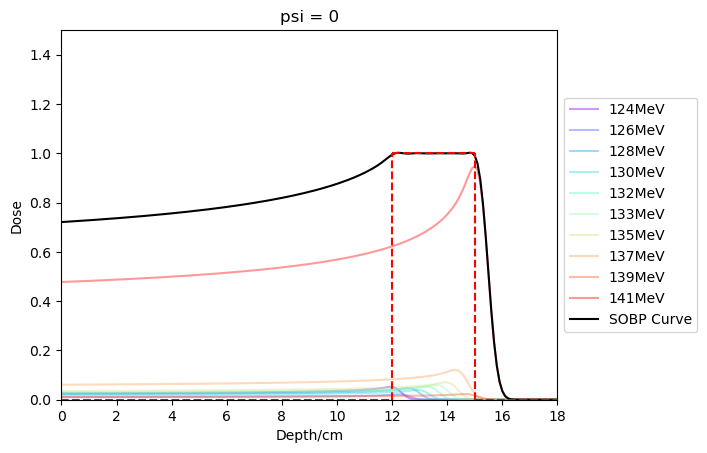

C:\Users\sgome\AppData\Local\Temp\ipykernel_28900\3067253581.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))


The first-order optimality measure is less than `tol`.
Number of iterations 7, initial cost 8.0797e-04, final cost 5.4758e-11, first-order optimality 3.77e-11.
omega (weights) = [ 1.19025776  0.66346033  1.17208661  0.97380897  1.51873242  1.42027389
  2.05474619  3.11178747  1.36302788 25.43308016]


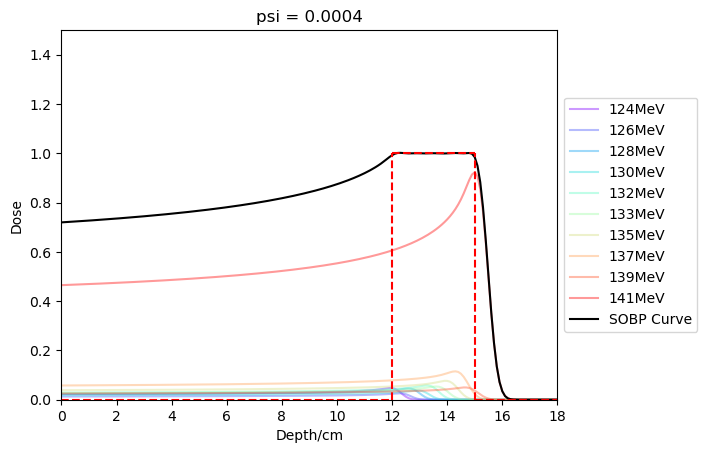

C:\Users\sgome\AppData\Local\Temp\ipykernel_28900\3067253581.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))


The first-order optimality measure is less than `tol`.
Number of iterations 8, initial cost 8.3732e-04, final cost 8.1099e-09, first-order optimality 8.17e-12.
omega (weights) = [7.88584423e-01 8.30182532e-01 1.07607495e+00 1.16114774e+00
 1.21816396e+00 1.79966001e+00 1.53009361e+00 4.98260504e+00
 1.77191457e-03 2.52410404e+01]


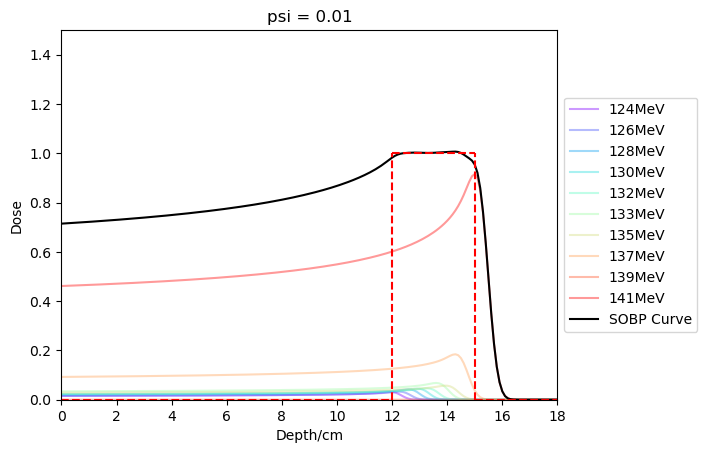

C:\Users\sgome\AppData\Local\Temp\ipykernel_28900\3067253581.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))


The first-order optimality measure is less than `tol`.
Number of iterations 8, initial cost 3.8384e-04, final cost 8.5969e-07, first-order optimality 2.41e-14.
omega (weights) = [4.90191486e-01 7.58449771e-01 1.13087324e+00 1.68767752e+00
 1.87400070e+00 3.08274835e+00 2.39805496e+00 5.95816296e+00
 2.25749218e-08 2.07113834e+01]


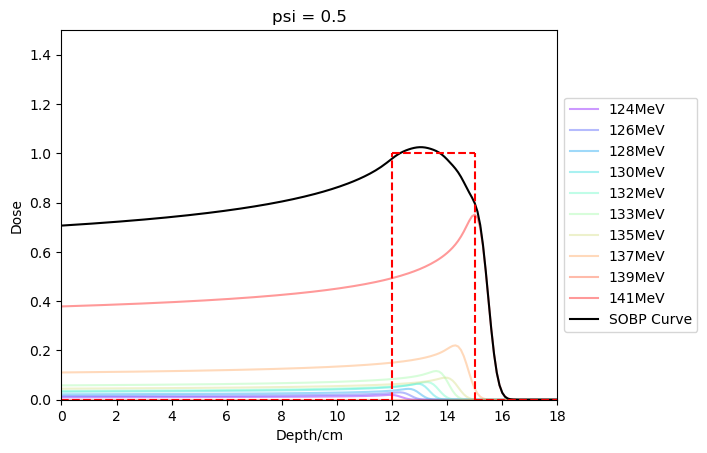

C:\Users\sgome\AppData\Local\Temp\ipykernel_28900\3067253581.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))


The first-order optimality measure is less than `tol`.
Number of iterations 7, initial cost 4.5330e-04, final cost 1.1767e-06, first-order optimality 8.15e-11.
omega (weights) = [5.56712696e-01 8.48682328e-01 1.26851681e+00 1.84685372e+00
 2.03189838e+00 3.20754429e+00 2.45312432e+00 5.86451620e+00
 3.86245587e-05 1.97219144e+01]


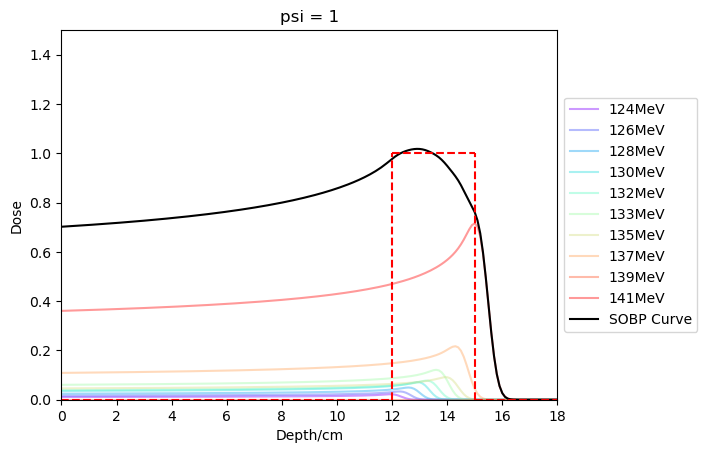

In [20]:
eVals = np.linspace(124,141,10)
lower = 12;upper = 15; dose = 1
theta = 1
phi=0
psi = [0, 0.0004,0.01, 0.5, 1]
for i in psi:
    m,omega,f,d = PenalizeDerivative(lower,upper,dose,eVals,theta,phi,i)
    print("omega (weights) = "+ str(omega))
    plt.title("psi = "+ str(i))
    plt.savefig(f'smoothsplines_lesq_{i}.pdf',bbox_inches='tight')
    plt.show()

# Quadratic Programming

solution to the problem : 
\begin{align*}
    \operatorname*{argmin}&_w \quad \lVert A \underline{w} - \underline{f} \rVert^2_{L^2} \\
    &\textrm{s.t.} \quad b=w^T\Phi(z) \geqslant d_T \quad 12 \leq z \leq 15\\
    &\textrm{s.t.} \quad w^T \geq 0\\
\end{align*}

The problem becomes
\begin{align*}
    \operatorname*{argmin}&_w \quad \frac{1}{2}w^TPw +q^Tw \\
    &\textrm{s.t.} \quad -Gw \leq -h
\end{align*}


In [84]:
def quadprog(lower,upper,dose,eVals, percentage, theta, phi , noplot):
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    a = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float) 
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
#    z_values = np.arange(lower,upper,0.0001)
    z_values = np.arange(lower,upper,0.1)
    phi_z_star = np.zeros((len(z_values),n) ) #matriz of zeros
    
    g = np.eye(n) #identity matrix that corresponds to the weights being greater to zero (-Iw<=0), will be added to G 
    
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        #SeteValGlobal(eVals[i])
        for j in range(n): # for n evaleus 
          #  SeteValGlobal2(eVals[j])
            
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper + valLower)
            
            #val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            a[i,j] = valCorrected    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose*(1 + percentage)
    
    
    
    #Getting the curve above 
    for j in range(n):   
        curve=Functionb(z_values,eVals[j]) #evaluating the function from lower to upper
        phi_z_star[:,j] = curve.T #saving the curve
    
    g = np.vstack((phi_z_star, g)) #

    #matrix h that will contain the dose in the first row, and zeros in the rest so that 
    #the constraints are satisfied
    H=np.zeros(len(g))
    H[0:len(z_values)]=dose*(1 + percentage) #So the rule is to be 110% above the dose 
    
    #Quadratic optimisation
    P = matrix(a.T @ a)
    q = matrix(-(a.T @ f))
    G= -matrix(g,tc='d')
    h = -matrix(H, tc='d')
    sol = solvers.qp(P,q,G,h)
 
    omega = np.array(sol["x"])
    
    colors = cm.rainbow(np.linspace(0, 1, n))
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        #plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        if noplot == 1:
            plt.plot(z,dList[i], label = str(round(eVals[i]))+'MeV', color = colors[i], alpha = 0.4)

    if noplot == 1:
        #######################################################################################
        # PLOTTING SPREAD OUT BRAGG PEAK and extras 

        d = sum(dList) #sum the di's
        plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
        #plt.plot(z,d, label = "SOBP Curve"+str(percentage*100)+"% above", color = "k") #plot
        
        #details
        PlotCustomBox(upper,lower,dose*(1 + percentage)) # plot target box
        #PlotCustomBox(upper,lower,dose) # plot target box
        plt.title("Intensity Optimized SOBP Plot")
        plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
        plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("Depth/cm")
        plt.ylabel("Dose")
        #plt.ylim([1.1,1.105])
        plt.xlim([0,18])
    plt.savefig(f'quadprog_{percentage}_{n}.pdf',bbox_inches='tight')
    
    return(omega,z,dList)
#    return(omega,z,d)

     pcost       dcost       gap    pres   dres
 0: -1.8809e-04  8.1058e+01  9e+01  2e+00  4e+00
 1: -2.6529e-03  5.0605e+01  9e+01  2e+00  3e+00
 2:  2.5263e-03 -1.7539e+01  2e+01  2e-01  3e-01
 3:  3.5889e-03 -2.1647e-01  2e-01  2e-03  4e-03
 4:  1.1499e-03 -1.5020e-02  2e-02  4e-05  7e-05
 5: -2.8218e-03 -5.1205e-03  2e-03  4e-15  1e-19
 6: -3.6369e-03 -3.8671e-03  2e-04  1e-15  3e-20
 7: -3.7120e-03 -3.7628e-03  5e-05  1e-15  4e-20
 8: -3.7104e-03 -3.7567e-03  5e-05  2e-16  5e-20
 9: -3.7150e-03 -3.7303e-03  2e-05  3e-16  7e-21
10: -3.7176e-03 -3.7235e-03  6e-06  1e-15  2e-21
11: -3.7178e-03 -3.7194e-03  2e-06  2e-16  7e-20
12: -3.7180e-03 -3.7181e-03  2e-08  1e-16  5e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.2759e-04  9.4971e+01  1e+02  2e+00  4e+00
 1: -3.5012e-03  5.1410e+01  1e+02  1e+00  3e+00
 2:  2.4400e-03 -1.5463e+01  2e+01  1e-01  3e-01
 3:  3.4210e-03 -1.8290e-01  2e-01  1e-03  3e-03
 4:  3.1312e-04 -1.5300e-02  2e-02  3e-05  6e-0

(array([[ 2.92828259],
        [43.16701339]]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14

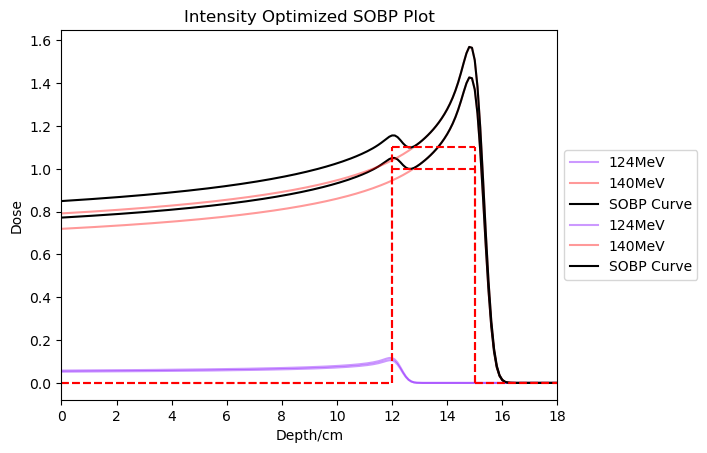

In [22]:
eVals = [124,140.2]
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
quadprog(lower, upper,dose, eVals, 0,theta, phi,1)
quadprog(lower, upper,dose, eVals, 0.1,theta, phi,1)

     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-19
 7: -2.0663e-02 -2.0684e-02  2e-05  7e-16  5e-19
 8: -2.0670e-02 -2.0673e-02  3e-06  7e-16  5e-19
 9: -2.0671e-02 -2.0671e-02  5e-07  7e-16  3e-19
10: -2.0671e-02 -2.0671e-02  7e-08  7e-16  3e-19
Optimal solution found.


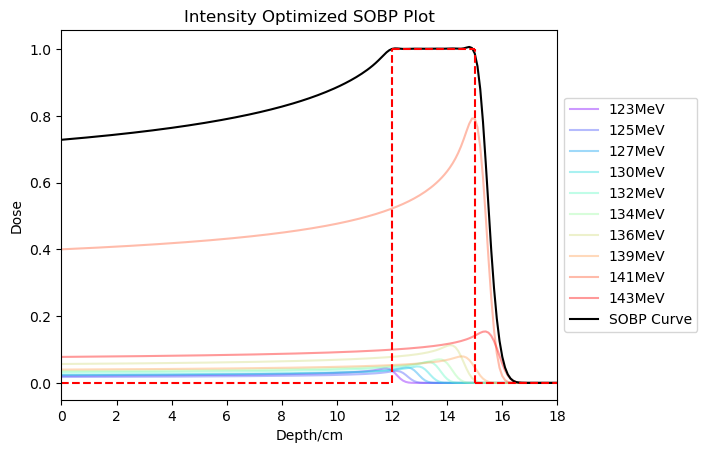

In [23]:
#eVals = np.linspace(123,143,10) #10 curves
eVals = np.linspace(123,143,10) #10 curves
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
omega1,z,dList = quadprog(lower, upper,dose, eVals, 0,theta, phi,1)

     pcost       dcost       gap    pres   dres
 0: -5.8932e-03  7.4869e+01  1e+02  2e+00  9e+00
 1: -1.5433e-02 -5.3637e+01  7e+01  6e-01  3e+00
 2:  1.0231e-03 -1.7297e+00  2e+00  2e-02  7e-02
 3: -3.6967e-03 -6.3200e-02  6e-02  4e-05  2e-04
 4: -2.2262e-02 -3.0707e-02  8e-03  1e-06  5e-06
 5: -2.4746e-02 -2.5831e-02  1e-03  1e-15  7e-19
 6: -2.4967e-02 -2.5132e-02  2e-04  1e-15  3e-19
 7: -2.5004e-02 -2.5028e-02  2e-05  4e-16  3e-19
 8: -2.5010e-02 -2.5014e-02  3e-06  6e-16  4e-19
 9: -2.5012e-02 -2.5012e-02  5e-07  1e-15  3e-19
10: -2.5012e-02 -2.5012e-02  7e-08  4e-16  4e-19
Optimal solution found.


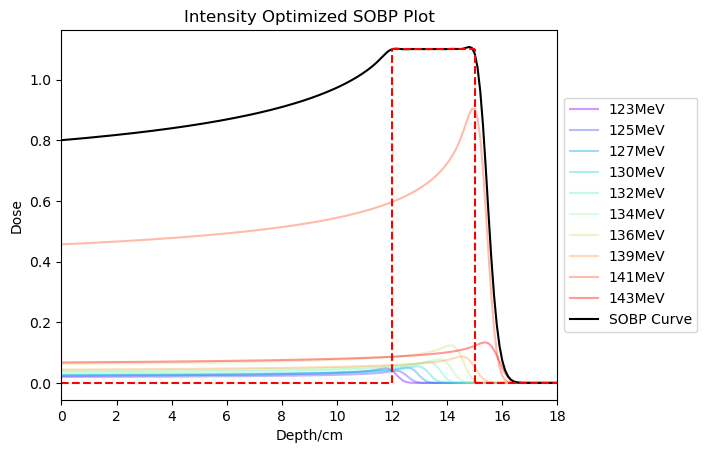

In [24]:
omega2,z,dList = quadprog(lower, upper,dose, eVals, 0.1,theta, phi,1) # 10% above the dose

## Error measurement for quadratic programming

In [25]:
def PlotErrorStagnationQP(lower,upper,dose, perc,theta, phi,eZeroLower,eZeroUpper, ncurves):
    n = ncurves
    eVals = [] #defines list of energy values
    yValues = [] 
    
    x = 0 #initialise depth
    
    for i in range(2,n+1): #plots SOBP for different numbers of curves
        eVals = []
        eVals = np.linspace(eZeroLower,eZeroUpper,i)
        print(str(len(eVals))+" Curves")
        print(str(eVals))
        omega,z,dList =quadprog(lower, upper,dose, eVals, perc,theta, phi,1)
        yValues.append(GetQuadratureTSqrt(omega,eVals))
        plt.title("Number of Curves = "+ str(len(eVals)))
        if i in (2,4,6,8,10,12,14,16,18,20):
            plt.savefig(f'plot_quadprog_{i}_{perc}_{eZeroLower}_{eZeroUpper}.pdf',bbox_inches='tight')
        plt.show()
    
    x = np.arange(2,n+1)
    
    #Error stagnation plot
    plt.plot(x,yValues)
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Log y scale of error")
    plt.xlabel("n Curves")
    plt.title("Error over target tumour")
    plt.xticks(x)
    
    plt.grid(True)
    #plt.savefig('Error_qp.pdf',bbox_inches='tight')
    plt.show()
    
    #finding best and other n for error plots  
        
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            nminerr = i+2  #minimum error
        
        elif yValues[i] == max(yValues):
            n3 = i+2 #max error
    
    return(yValues,nminerr)

### 
Plot of error with different Energies

In [26]:
lower = 12;upper=15;dose = 1;
perc=0;
theta=1; phi=0;
ncurves = 20

2 Curves
[123. 141.]
     pcost       dcost       gap    pres   dres
 0: -1.6441e-04  8.0821e+01  9e+01  2e+00  4e+00
 1: -2.3110e-03  5.5632e+01  9e+01  2e+00  3e+00
 2:  2.2656e-03 -1.9720e+01  2e+01  2e-01  4e-01
 3:  3.3050e-03 -2.5364e-01  3e-01  2e-03  4e-03
 4:  1.3544e-03 -1.5030e-02  2e-02  4e-05  7e-05
 5: -2.0532e-03 -6.4508e-03  4e-03  8e-06  1e-05
 6: -3.2535e-03 -3.8203e-03  6e-04  3e-15  3e-21
 7: -3.4698e-03 -3.5298e-03  6e-05  1e-15  2e-20
 8: -3.4674e-03 -3.5193e-03  5e-05  2e-15  7e-21
 9: -3.4756e-03 -3.4865e-03  1e-05  3e-16  3e-21
10: -3.4764e-03 -3.4798e-03  3e-06  1e-15  3e-21
11: -3.4772e-03 -3.4773e-03  8e-08  2e-16  1e-20
Optimal solution found.
2.33995794290491e-10


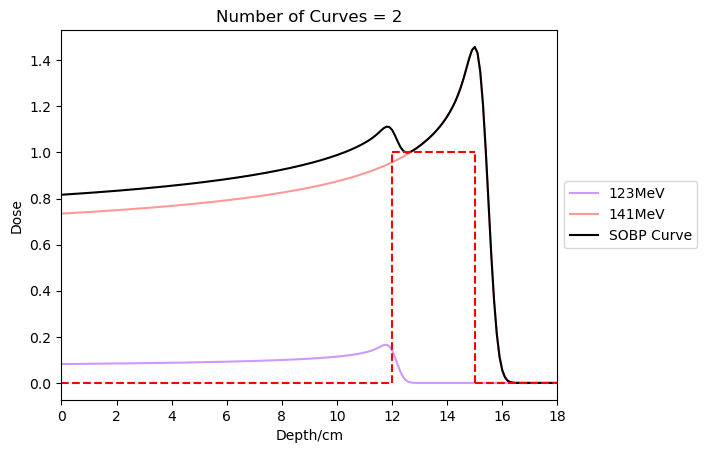

3 Curves
[123. 132. 141.]
     pcost       dcost       gap    pres   dres
 0: -3.9239e-04  7.8425e+01  9e+01  2e+00  5e+00
 1: -4.4822e-03  3.3152e+01  9e+01  2e+00  4e+00
 2:  2.5898e-03 -1.6667e+01  2e+01  2e-01  4e-01
 3:  4.1166e-03 -1.9971e-01  2e-01  2e-03  4e-03
 4:  1.3507e-04 -1.6474e-02  2e-02  2e-05  6e-05
 5: -4.3533e-03 -7.4447e-03  3e-03  2e-06  5e-06
 6: -5.3144e-03 -5.6459e-03  3e-04  4e-16  6e-20
 7: -5.4358e-03 -5.4742e-03  4e-05  2e-16  2e-20
 8: -5.4462e-03 -5.4604e-03  1e-05  2e-16  6e-20
 9: -5.4476e-03 -5.4524e-03  5e-06  1e-15  3e-20
10: -5.4487e-03 -5.4500e-03  1e-06  1e-16  5e-20
11: -5.4490e-03 -5.4490e-03  7e-08  2e-16  4e-20
Optimal solution found.
9.098619649621134e-13


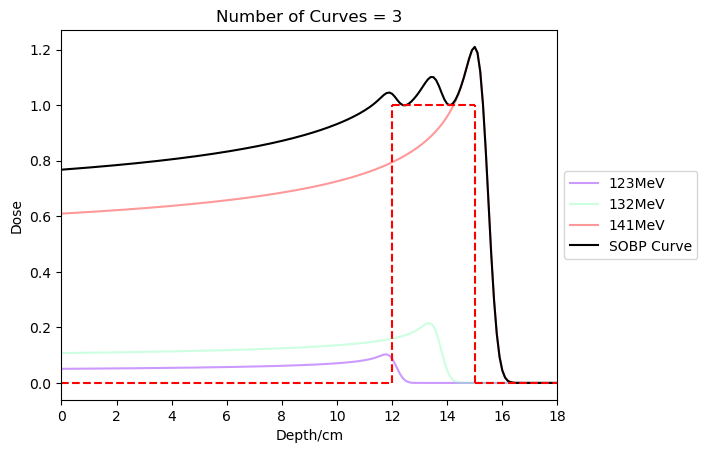

4 Curves
[123. 129. 135. 141.]
     pcost       dcost       gap    pres   dres
 0: -7.3598e-04  7.6019e+01  1e+02  2e+00  6e+00
 1: -7.4281e-03  3.2265e+00  9e+01  1e+00  3e+00
 2:  3.7428e-03 -1.2998e+01  1e+01  1e-01  4e-01
 3:  5.7963e-03 -1.6538e-01  2e-01  1e-03  4e-03
 4: -9.7032e-04 -1.7772e-02  2e-02  2e-05  5e-05
 5: -6.5863e-03 -8.8194e-03  2e-03  1e-15  1e-19
 6: -7.4017e-03 -7.6764e-03  3e-04  3e-15  4e-20
 7: -7.5140e-03 -7.5511e-03  4e-05  3e-16  4e-20
 8: -7.5301e-03 -7.5343e-03  4e-06  2e-15  8e-20
 9: -7.5306e-03 -7.5320e-03  1e-06  8e-16  5e-20
10: -7.5308e-03 -7.5310e-03  2e-07  2e-16  1e-19
11: -7.5309e-03 -7.5309e-03  4e-08  7e-16  5e-20
Optimal solution found.
3.083683931896137e-13


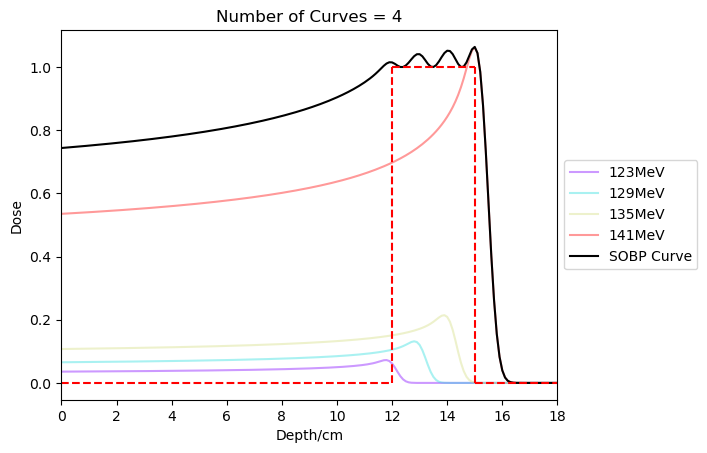

5 Curves
[123.  127.5 132.  136.5 141. ]
     pcost       dcost       gap    pres   dres
 0: -1.1773e-03  7.3829e+01  1e+02  2e+00  6e+00
 1: -8.8350e-03 -2.1324e+01  7e+01  1e+00  3e+00
 2:  5.5900e-03 -8.3752e+00  9e+00  1e-01  3e-01
 3:  7.2983e-03 -1.1687e-01  1e-01  1e-03  3e-03
 4: -3.2960e-03 -1.7762e-02  1e-02  7e-06  2e-05
 5: -8.7292e-03 -1.0664e-02  2e-03  4e-16  2e-19
 6: -9.4909e-03 -9.7525e-03  3e-04  1e-15  1e-19
 7: -9.5983e-03 -9.6353e-03  4e-05  2e-16  5e-20
 8: -9.6137e-03 -9.6189e-03  5e-06  1e-15  2e-20
 9: -9.6159e-03 -9.6165e-03  6e-07  1e-15  5e-20
10: -9.6160e-03 -9.6163e-03  3e-07  7e-16  6e-20
11: -9.6160e-03 -9.6161e-03  2e-08  7e-16  7e-20
Optimal solution found.
2.334783148448064e-13


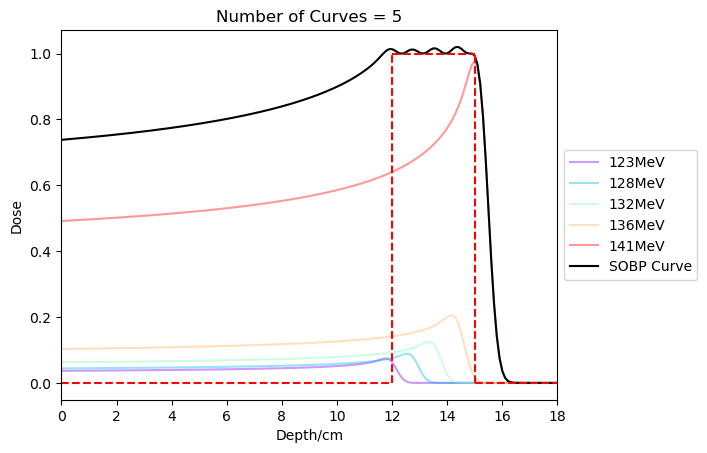

6 Curves
[123.  126.6 130.2 133.8 137.4 141. ]
     pcost       dcost       gap    pres   dres
 0: -1.7000e-03  7.2302e+01  1e+02  2e+00  7e+00
 1: -7.5594e-03 -3.0070e+01  6e+01  7e-01  2e+00
 2:  7.6054e-03 -4.7032e+00  5e+00  6e-02  2e-01
 3:  8.1619e-03 -8.0339e-02  9e-02  5e-04  2e-03
 4: -6.5024e-03 -1.7783e-02  1e-02  6e-16  8e-19
 5: -1.0946e-02 -1.2485e-02  2e-03  7e-16  2e-19
 6: -1.1557e-02 -1.1768e-02  2e-04  3e-16  2e-19
 7: -1.1643e-02 -1.1673e-02  3e-05  8e-16  2e-19
 8: -1.1655e-02 -1.1659e-02  4e-06  3e-16  1e-19
 9: -1.1657e-02 -1.1658e-02  6e-07  1e-15  1e-19
10: -1.1657e-02 -1.1657e-02  1e-07  7e-16  1e-19
Optimal solution found.
1.263969508010919e-13


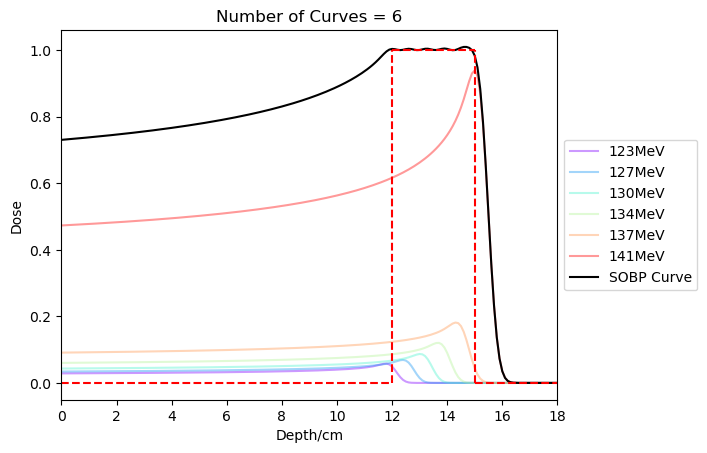

7 Curves
[123. 126. 129. 132. 135. 138. 141.]
     pcost       dcost       gap    pres   dres
 0: -2.2987e-03  7.0423e+01  1e+02  2e+00  8e+00
 1: -3.7451e-03 -2.9422e+01  4e+01  5e-01  2e+00
 2:  9.3981e-03 -2.0297e+00  2e+00  2e-02  8e-02
 3:  7.5773e-03 -5.4162e-02  6e-02  2e-04  7e-04
 4: -9.8959e-03 -1.8311e-02  8e-03  2e-15  4e-19
 5: -1.3162e-02 -1.4319e-02  1e-03  3e-16  3e-19
 6: -1.3598e-02 -1.3749e-02  2e-04  1e-15  2e-19
 7: -1.3658e-02 -1.3680e-02  2e-05  7e-16  2e-19
 8: -1.3667e-02 -1.3670e-02  3e-06  7e-16  2e-19
 9: -1.3668e-02 -1.3669e-02  5e-07  7e-16  2e-19
10: -1.3669e-02 -1.3669e-02  6e-08  7e-16  3e-19
Optimal solution found.
4.88732535980035e-13


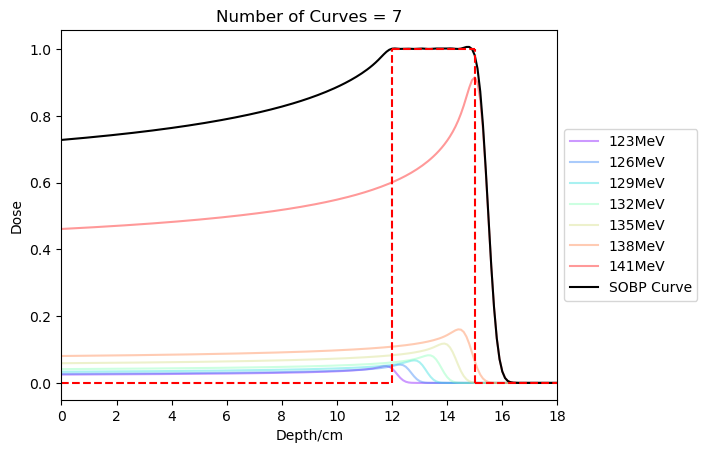

8 Curves
[123.         125.57142857 128.14285714 130.71428571 133.28571429
 135.85714286 138.42857143 141.        ]
     pcost       dcost       gap    pres   dres
 0: -2.9715e-03  6.8434e+01  1e+02  2e+00  8e+00
 1: -5.5279e-03 -3.4844e+01  5e+01  5e-01  2e+00
 2:  8.2739e-03 -2.3880e+00  2e+00  2e-02  9e-02
 3:  5.5416e-03 -6.2864e-02  7e-02  1e-04  5e-04
 4: -1.2717e-02 -2.0843e-02  8e-03  2e-15  8e-19
 5: -1.5259e-02 -1.6462e-02  1e-03  8e-16  3e-19
 6: -1.5604e-02 -1.5794e-02  2e-04  7e-16  2e-19
 7: -1.5660e-02 -1.5687e-02  3e-05  2e-16  3e-19
 8: -1.5669e-02 -1.5673e-02  4e-06  7e-16  2e-19
 9: -1.5671e-02 -1.5671e-02  5e-07  7e-16  3e-19
10: -1.5671e-02 -1.5671e-02  7e-08  1e-15  3e-19
Optimal solution found.
4.239274906175544e-13


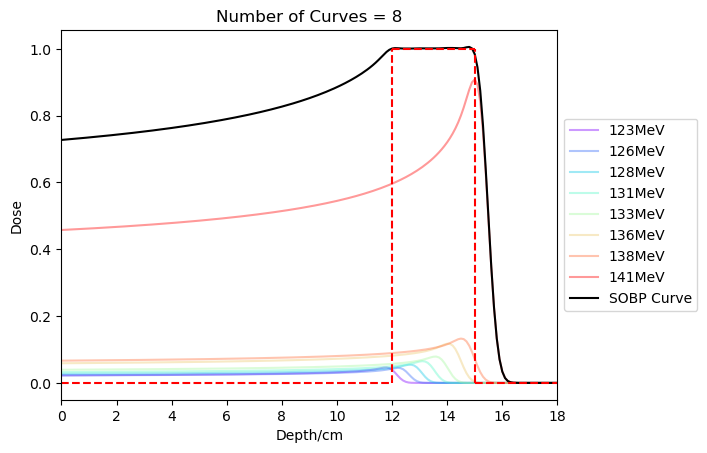

9 Curves
[123.   125.25 127.5  129.75 132.   134.25 136.5  138.75 141.  ]
     pcost       dcost       gap    pres   dres
 0: -3.7150e-03  6.6444e+01  1e+02  2e+00  9e+00
 1: -7.8609e-03 -3.8441e+01  5e+01  6e-01  2e+00
 2:  7.5980e-03 -3.1259e+00  3e+00  3e-02  1e-01
 3:  5.1475e-03 -7.5084e-02  8e-02  2e-04  7e-04
 4: -1.4542e-02 -2.3639e-02  9e-03  9e-16  1e-18
 5: -1.7251e-02 -1.8616e-02  1e-03  1e-15  5e-19
 6: -1.7612e-02 -1.7797e-02  2e-04  8e-16  3e-19
 7: -1.7661e-02 -1.7686e-02  2e-05  8e-16  3e-19
 8: -1.7669e-02 -1.7673e-02  4e-06  7e-16  3e-19
 9: -1.7671e-02 -1.7671e-02  6e-07  7e-16  3e-19
10: -1.7671e-02 -1.7671e-02  8e-08  3e-16  3e-19
Optimal solution found.
2.413359593225919e-09


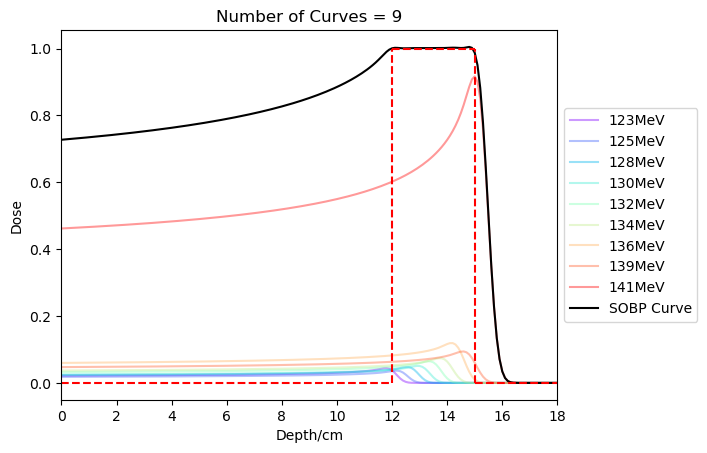

10 Curves
[123. 125. 127. 129. 131. 133. 135. 137. 139. 141.]
     pcost       dcost       gap    pres   dres
 0: -4.5251e-03  6.4495e+01  1e+02  2e+00  9e+00
 1: -9.7946e-03 -4.0045e+01  5e+01  6e-01  3e+00
 2:  7.3245e-03 -3.3644e+00  3e+00  3e-02  1e-01
 3:  4.7046e-03 -8.1109e-02  9e-02  2e-04  8e-04
 4: -1.6377e-02 -2.5993e-02  1e-02  8e-16  1e-18
 5: -1.9246e-02 -2.0703e-02  1e-03  8e-16  4e-19
 6: -1.9617e-02 -1.9789e-02  2e-04  1e-15  6e-19
 7: -1.9661e-02 -1.9683e-02  2e-05  3e-16  3e-19
 8: -1.9668e-02 -1.9672e-02  4e-06  7e-16  3e-19
 9: -1.9669e-02 -1.9670e-02  5e-07  2e-16  3e-19
10: -1.9670e-02 -1.9670e-02  8e-08  3e-16  2e-19
Optimal solution found.
8.654816011073819e-09


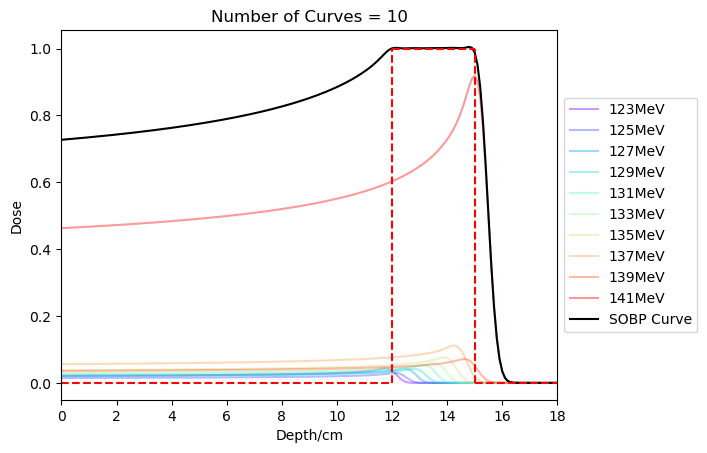

11 Curves
[123.  124.8 126.6 128.4 130.2 132.  133.8 135.6 137.4 139.2 141. ]
     pcost       dcost       gap    pres   dres
 0: -5.3980e-03  6.2606e+01  1e+02  2e+00  9e+00
 1: -1.1422e-02 -4.0521e+01  5e+01  7e-01  3e+00
 2:  7.3428e-03 -3.3946e+00  3e+00  3e-02  1e-01
 3:  4.3651e-03 -8.4532e-02  9e-02  2e-04  8e-04
 4: -1.8204e-02 -2.8218e-02  1e-02  8e-16  2e-18
 5: -2.1260e-02 -2.2704e-02  1e-03  8e-16  7e-19
 6: -2.1619e-02 -2.1775e-02  2e-04  4e-16  5e-19
 7: -2.1659e-02 -2.1679e-02  2e-05  4e-16  5e-19
 8: -2.1666e-02 -2.1669e-02  3e-06  7e-16  3e-19
 9: -2.1667e-02 -2.1667e-02  4e-07  7e-16  3e-19
10: -2.1667e-02 -2.1667e-02  7e-08  3e-16  4e-19
Optimal solution found.
1.113500765257136e-13


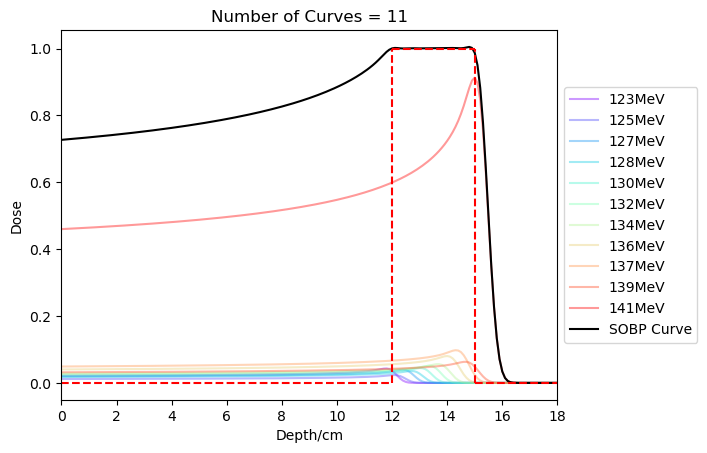

12 Curves
[123.         124.63636364 126.27272727 127.90909091 129.54545455
 131.18181818 132.81818182 134.45454545 136.09090909 137.72727273
 139.36363636 141.        ]
     pcost       dcost       gap    pres   dres
 0: -6.3302e-03  6.0779e+01  1e+02  2e+00  1e+01
 1: -1.2805e-02 -4.0330e+01  5e+01  7e-01  3e+00
 2:  7.5558e-03 -3.3490e+00  3e+00  3e-02  1e-01
 3:  4.0789e-03 -8.7071e-02  9e-02  2e-04  7e-04
 4: -2.0043e-02 -3.0429e-02  1e-02  1e-15  1e-18
 5: -2.3279e-02 -2.4676e-02  1e-03  5e-16  7e-19
 6: -2.3619e-02 -2.3757e-02  1e-04  7e-16  4e-19
 7: -2.3656e-02 -2.3675e-02  2e-05  7e-16  5e-19
 8: -2.3662e-02 -2.3665e-02  3e-06  3e-16  5e-19
 9: -2.3663e-02 -2.3664e-02  4e-07  7e-16  6e-19
10: -2.3664e-02 -2.3664e-02  7e-08  1e-15  4e-19
Optimal solution found.
2.394686258949157e-13


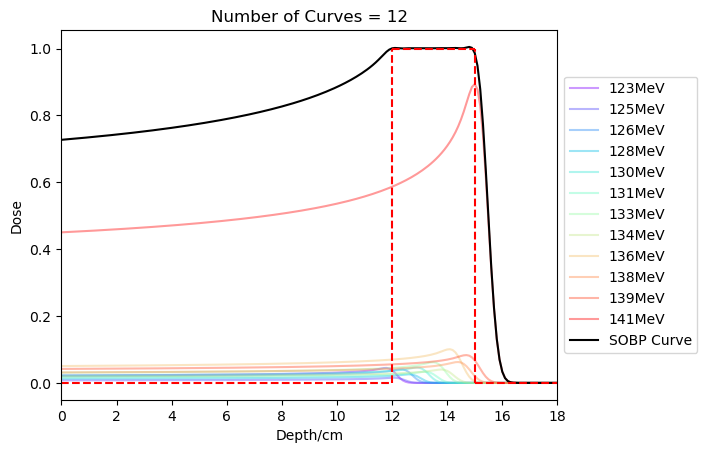

13 Curves
[123.  124.5 126.  127.5 129.  130.5 132.  133.5 135.  136.5 138.  139.5
 141. ]
     pcost       dcost       gap    pres   dres
 0: -7.3182e-03  5.9120e+01  1e+02  2e+00  1e+01
 1: -1.3991e-02 -3.9676e+01  5e+01  7e-01  3e+00
 2:  7.9053e-03 -3.2525e+00  3e+00  3e-02  1e-01
 3:  3.7345e-03 -8.9180e-02  9e-02  1e-04  6e-04
 4: -2.1822e-02 -3.2880e-02  1e-02  1e-06  4e-06
 5: -2.5246e-02 -2.6766e-02  2e-03  9e-16  8e-19
 6: -2.5614e-02 -2.5751e-02  1e-04  7e-16  6e-19
 7: -2.5652e-02 -2.5671e-02  2e-05  7e-16  5e-19
 8: -2.5658e-02 -2.5661e-02  3e-06  3e-16  5e-19
 9: -2.5659e-02 -2.5660e-02  5e-07  7e-16  4e-19
10: -2.5660e-02 -2.5660e-02  8e-08  3e-16  5e-19
Optimal solution found.
2.934483862186734e-13


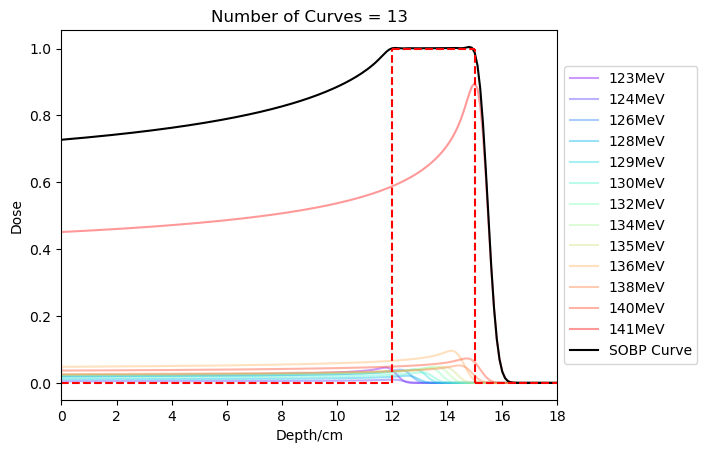

14 Curves
[123.         124.38461538 125.76923077 127.15384615 128.53846154
 129.92307692 131.30769231 132.69230769 134.07692308 135.46153846
 136.84615385 138.23076923 139.61538462 141.        ]
     pcost       dcost       gap    pres   dres
 0: -8.3591e-03  5.7480e+01  1e+02  2e+00  1e+01
 1: -1.4967e-02 -3.8811e+01  5e+01  6e-01  3e+00
 2:  8.4301e-03 -3.1106e+00  3e+00  3e-02  1e-01
 3:  3.3282e-03 -9.0814e-02  9e-02  1e-04  5e-04
 4: -2.3587e-02 -3.5390e-02  1e-02  2e-06  8e-06
 5: -2.7215e-02 -2.8850e-02  2e-03  4e-16  7e-19
 6: -2.7606e-02 -2.7758e-02  2e-04  4e-16  5e-19
 7: -2.7647e-02 -2.7667e-02  2e-05  8e-16  7e-19
 8: -2.7654e-02 -2.7657e-02  3e-06  3e-16  6e-19
 9: -2.7655e-02 -2.7655e-02  5e-07  2e-16  6e-19
10: -2.7655e-02 -2.7655e-02  7e-08  3e-16  3e-19
Optimal solution found.
4.664335051285349e-09


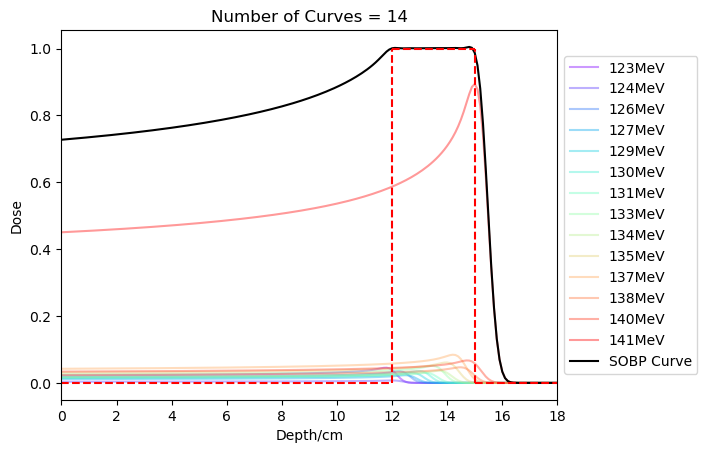

15 Curves
[123.         124.28571429 125.57142857 126.85714286 128.14285714
 129.42857143 130.71428571 132.         133.28571429 134.57142857
 135.85714286 137.14285714 138.42857143 139.71428571 141.        ]
     pcost       dcost       gap    pres   dres
 0: -9.4498e-03  5.5870e+01  1e+02  2e+00  1e+01
 1: -1.5699e-02 -3.7819e+01  5e+01  6e-01  3e+00
 2:  9.1965e-03 -2.9352e+00  3e+00  3e-02  1e-01
 3:  2.8660e-03 -9.2096e-02  9e-02  8e-05  4e-04
 4: -2.5377e-02 -3.7821e-02  1e-02  2e-06  9e-06
 5: -2.9187e-02 -3.0922e-02  2e-03  6e-16  7e-19
 6: -2.9598e-02 -2.9763e-02  2e-04  7e-16  1e-18
 7: -2.9642e-02 -2.9664e-02  2e-05  4e-16  1e-18
 8: -2.9649e-02 -2.9652e-02  3e-06  3e-16  6e-19
 9: -2.9650e-02 -2.9650e-02  5e-07  1e-15  5e-19
10: -2.9650e-02 -2.9650e-02  8e-08  3e-16  5e-19
Optimal solution found.
2.6962224538136223e-13


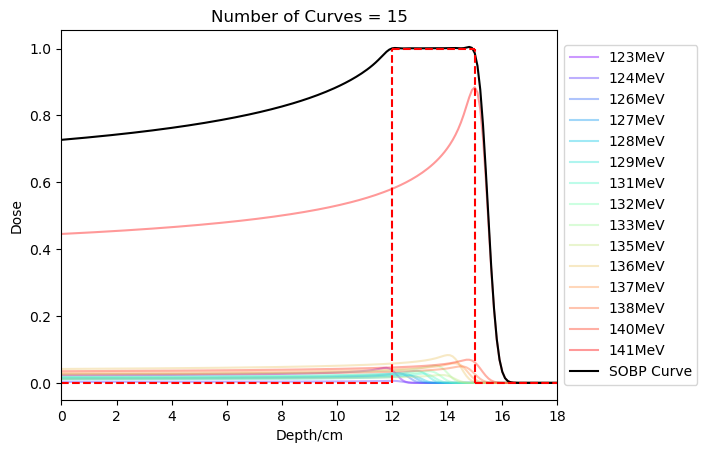

16 Curves
[123.  124.2 125.4 126.6 127.8 129.  130.2 131.4 132.6 133.8 135.  136.2
 137.4 138.6 139.8 141. ]
     pcost       dcost       gap    pres   dres
 0: -1.0588e-02  5.4295e+01  1e+02  2e+00  1e+01
 1: -1.6250e-02 -3.6707e+01  5e+01  6e-01  3e+00
 2:  1.0067e-02 -2.7342e+00  3e+00  3e-02  1e-01
 3:  2.2004e-03 -9.2930e-02  1e-01  4e-05  2e-04
 4: -2.7201e-02 -4.0172e-02  1e-02  1e-06  7e-06
 5: -3.1165e-02 -3.2981e-02  2e-03  8e-16  1e-18
 6: -3.1591e-02 -3.1767e-02  2e-04  8e-16  8e-19
 7: -3.1636e-02 -3.1659e-02  2e-05  7e-16  6e-19
 8: -3.1643e-02 -3.1647e-02  3e-06  7e-16  8e-19
 9: -3.1645e-02 -3.1645e-02  6e-07  7e-16  6e-19
10: -3.1645e-02 -3.1645e-02  1e-07  3e-16  6e-19
Optimal solution found.
2.302718823167662e-13


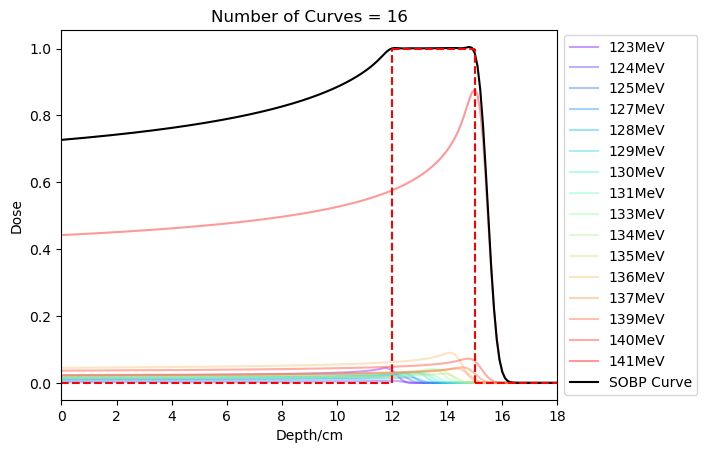

17 Curves
[123.    124.125 125.25  126.375 127.5   128.625 129.75  130.875 132.
 133.125 134.25  135.375 136.5   137.625 138.75  139.875 141.   ]
     pcost       dcost       gap    pres   dres
 0: -1.1770e-02  5.2760e+01  1e+02  2e+00  1e+01
 1: -1.6611e-02 -3.5503e+01  5e+01  6e-01  3e+00
 2:  1.1028e-02 -2.5330e+00  3e+00  3e-02  1e-01
 3:  1.3515e-03 -9.3508e-02  9e-02  7e-06  3e-05
 4: -2.9051e-02 -4.2454e-02  1e-02  3e-07  1e-06
 5: -3.3146e-02 -3.5028e-02  2e-03  7e-16  9e-19
 6: -3.3583e-02 -3.3769e-02  2e-04  9e-16  8e-19
 7: -3.3630e-02 -3.3654e-02  2e-05  8e-16  7e-19
 8: -3.3638e-02 -3.3642e-02  4e-06  3e-16  5e-19
 9: -3.3639e-02 -3.3640e-02  6e-07  3e-16  1e-18
10: -3.3639e-02 -3.3639e-02  9e-08  3e-16  6e-19
Optimal solution found.
2.2146036055491342e-13


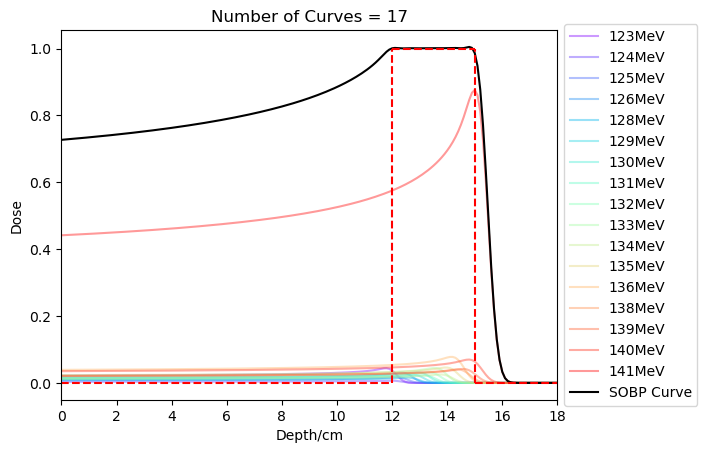

18 Curves
[123.         124.05882353 125.11764706 126.17647059 127.23529412
 128.29411765 129.35294118 130.41176471 131.47058824 132.52941176
 133.58823529 134.64705882 135.70588235 136.76470588 137.82352941
 138.88235294 139.94117647 141.        ]
     pcost       dcost       gap    pres   dres
 0: -1.2995e-02  5.1267e+01  1e+02  2e+00  1e+01
 1: -1.6774e-02 -3.4226e+01  5e+01  6e-01  3e+00
 2:  1.2079e-02 -2.3294e+00  2e+00  2e-02  1e-01
 3:  2.8159e-04 -9.6294e-02  1e-01  8e-16  2e-17
 4: -3.0867e-02 -4.4812e-02  1e-02  6e-16  2e-18
 5: -3.5125e-02 -3.7082e-02  2e-03  5e-16  1e-18
 6: -3.5576e-02 -3.5771e-02  2e-04  8e-16  1e-18
 7: -3.5624e-02 -3.5649e-02  2e-05  5e-16  8e-19
 8: -3.5632e-02 -3.5636e-02  4e-06  4e-16  1e-18
 9: -3.5634e-02 -3.5634e-02  6e-07  7e-16  9e-19
10: -3.5634e-02 -3.5634e-02  1e-07  7e-16  8e-19
11: -3.5634e-02 -3.5634e-02  2e-08  3e-16  7e-19
Optimal solution found.
2.6273011776127713e-13


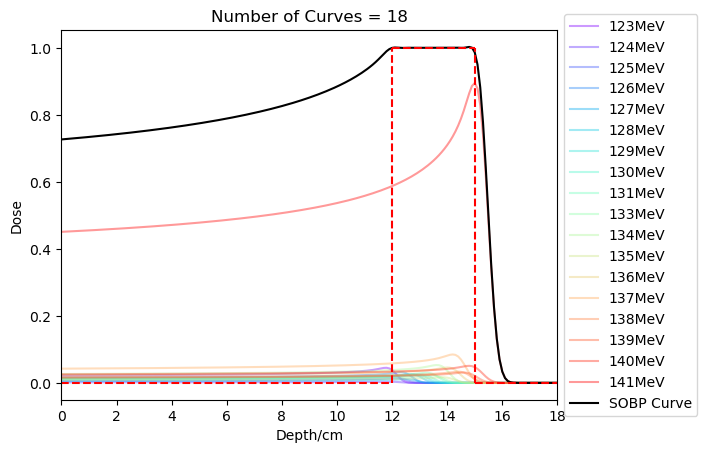

19 Curves
[123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141.]
     pcost       dcost       gap    pres   dres
 0: -1.4260e-02  4.9815e+01  1e+02  2e+00  1e+01
 1: -1.6732e-02 -3.2895e+01  4e+01  6e-01  3e+00
 2:  1.3227e-02 -2.1149e+00  2e+00  2e-02  1e-01
 3: -1.1268e-03 -9.9072e-02  1e-01  8e-16  2e-17
 4: -3.2717e-02 -4.7117e-02  1e-02  6e-16  2e-18
 5: -3.7109e-02 -3.9122e-02  2e-03  7e-16  1e-18
 6: -3.7568e-02 -3.7771e-02  2e-04  8e-16  7e-19
 7: -3.7618e-02 -3.7644e-02  3e-05  4e-16  9e-19
 8: -3.7626e-02 -3.7630e-02  4e-06  7e-16  1e-18
 9: -3.7628e-02 -3.7628e-02  5e-07  7e-16  1e-18
10: -3.7628e-02 -3.7628e-02  9e-08  1e-15  1e-18
Optimal solution found.
2.335496766360762e-13


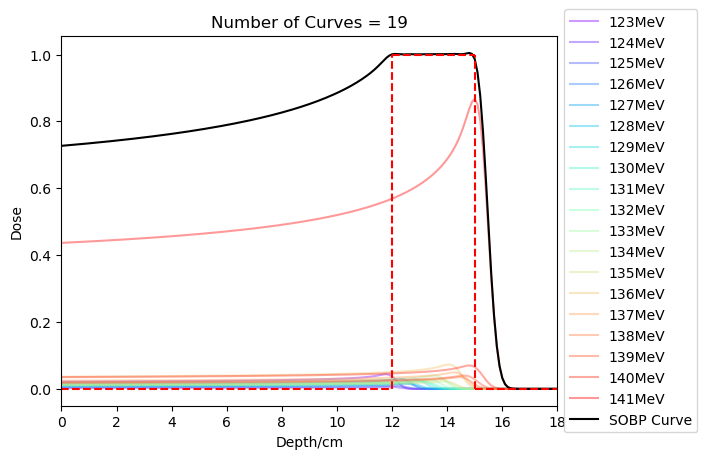

20 Curves
[123.         123.94736842 124.89473684 125.84210526 126.78947368
 127.73684211 128.68421053 129.63157895 130.57894737 131.52631579
 132.47368421 133.42105263 134.36842105 135.31578947 136.26315789
 137.21052632 138.15789474 139.10526316 140.05263158 141.        ]
     pcost       dcost       gap    pres   dres
 0: -1.5563e-02  4.8417e+01  1e+02  2e+00  1e+01
 1: -1.6473e-02 -3.1515e+01  4e+01  5e-01  3e+00
 2:  1.4461e-02 -1.8937e+00  2e+00  2e-02  1e-01
 3: -2.9584e-03 -1.0113e-01  1e-01  9e-16  1e-17
 4: -3.4630e-02 -4.9311e-02  1e-02  7e-16  3e-18
 5: -3.9102e-02 -4.1138e-02  2e-03  5e-16  2e-18
 6: -3.9562e-02 -3.9768e-02  2e-04  7e-16  2e-18
 7: -3.9612e-02 -3.9638e-02  3e-05  4e-16  2e-18
 8: -3.9620e-02 -3.9624e-02  4e-06  3e-16  2e-18
 9: -3.9622e-02 -3.9622e-02  6e-07  1e-15  1e-18
10: -3.9622e-02 -3.9622e-02  9e-08  7e-16  1e-18
Optimal solution found.
2.3162680180431766e-13


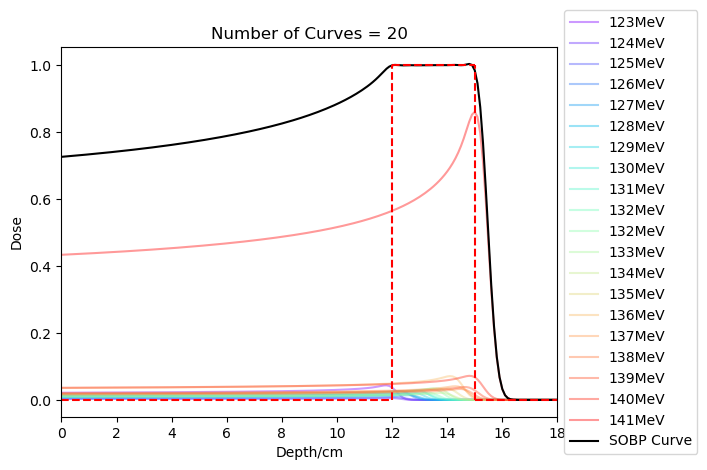

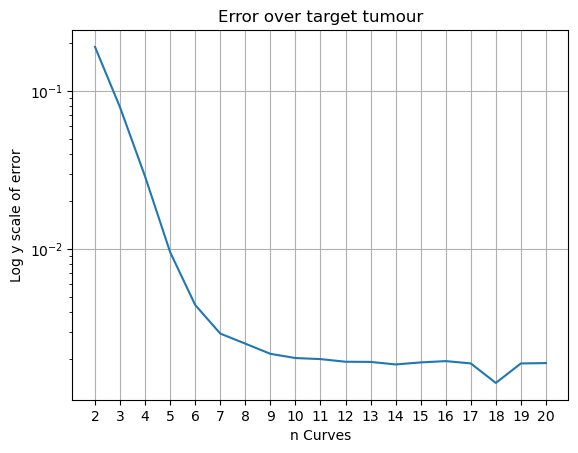

In [27]:
eZeroLower = 123;eZeroUpper = 141
yValues,nminerr = PlotErrorStagnationQP(lower,upper,dose, perc,theta, phi,eZeroLower,eZeroUpper,ncurves)


The same procedure with a different range of energies from 123 to 143

2 Curves
[123. 143.]
     pcost       dcost       gap    pres   dres
 0: -1.3011e-04  7.9862e+01  9e+01  2e+00  4e+00
 1: -1.7631e-03  6.3606e+01  9e+01  2e+00  3e+00
 2:  1.5563e-03 -2.4462e+01  3e+01  2e-01  4e-01
 3:  2.4061e-03 -2.9281e-01  3e-01  2e-03  5e-03
 4:  1.1246e-03 -1.3980e-02  2e-02  4e-05  6e-05
 5: -2.0027e-03 -5.6888e-03  4e-03  7e-06  1e-05
 6: -2.9140e-03 -3.4245e-03  5e-04  2e-15  1e-20
 7: -3.1126e-03 -3.1628e-03  5e-05  1e-15  1e-20
 8: -3.1257e-03 -3.1398e-03  1e-05  2e-16  4e-22
 9: -3.1266e-03 -3.1303e-03  4e-06  1e-16  4e-20
10: -3.1267e-03 -3.1271e-03  5e-07  3e-15  5e-20
11: -3.1267e-03 -3.1267e-03  7e-09  1e-15  7e-21
Optimal solution found.
8.520264203541836e-14


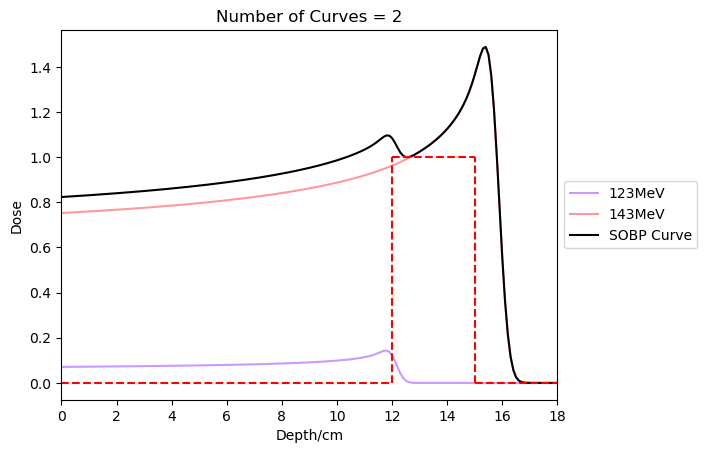

3 Curves
[123. 133. 143.]
     pcost       dcost       gap    pres   dres
 0: -3.8650e-04  7.7220e+01  9e+01  2e+00  5e+00
 1: -4.3795e-03  3.5142e+01  9e+01  2e+00  3e+00
 2:  2.0204e-03 -2.1181e+01  2e+01  2e-01  5e-01
 3:  4.0605e-03 -2.9221e-01  3e-01  3e-03  6e-03
 4:  1.0341e-03 -1.8085e-02  2e-02  3e-05  7e-05
 5: -4.1460e-03 -7.7047e-03  4e-03  3e-06  7e-06
 6: -5.2054e-03 -5.6248e-03  4e-04  2e-15  1e-20
 7: -5.3619e-03 -5.4100e-03  5e-05  1e-15  5e-20
 8: -5.3790e-03 -5.3896e-03  1e-05  4e-16  6e-20
 9: -5.3783e-03 -5.3870e-03  9e-06  1e-15  2e-20
10: -5.3798e-03 -5.3813e-03  2e-06  4e-16  5e-20
11: -5.3800e-03 -5.3804e-03  3e-07  1e-15  7e-20
12: -5.3801e-03 -5.3801e-03  4e-09  1e-15  5e-20
Optimal solution found.
1.476255901531581e-13


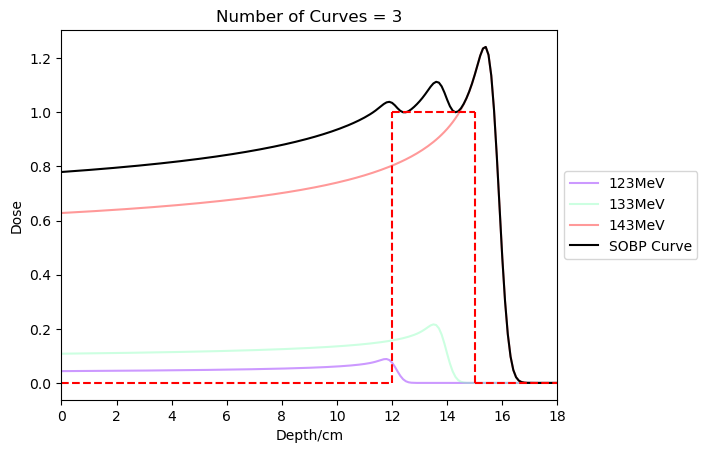

4 Curves
[123.         129.66666667 136.33333333 143.        ]
     pcost       dcost       gap    pres   dres
 0: -7.7763e-04  7.5743e+01  1e+02  2e+00  6e+00
 1: -7.7777e-03 -4.1324e+00  8e+01  1e+00  3e+00
 2:  3.3119e-03 -1.6055e+01  2e+01  2e-01  5e-01
 3:  6.3683e-03 -2.0634e-01  2e-01  2e-03  5e-03
 4:  3.6013e-05 -1.9136e-02  2e-02  2e-05  5e-05
 5: -6.5842e-03 -9.3240e-03  3e-03  3e-07  9e-07
 6: -7.6162e-03 -7.9709e-03  4e-04  5e-10  1e-09
 7: -7.7613e-03 -7.8096e-03  5e-05  2e-15  1e-19
 8: -7.7813e-03 -7.7875e-03  6e-06  1e-15  8e-20
 9: -7.7815e-03 -7.7852e-03  4e-06  1e-16  9e-20
10: -7.7823e-03 -7.7827e-03  4e-07  2e-15  1e-19
11: -7.7823e-03 -7.7824e-03  4e-08  2e-16  3e-19
Optimal solution found.
2.9948454186164425e-13


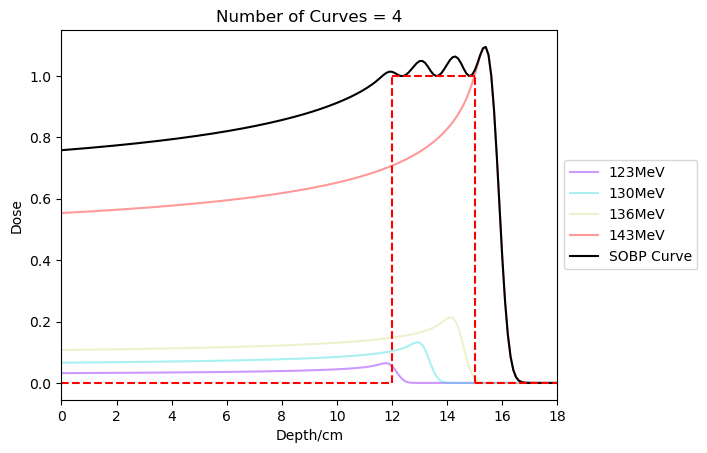

5 Curves
[123. 128. 133. 138. 143.]
     pcost       dcost       gap    pres   dres
 0: -1.2561e-03  7.4419e+01  1e+02  2e+00  7e+00
 1: -8.6430e-03 -2.4735e+01  7e+01  9e-01  3e+00
 2:  5.8110e-03 -3.9745e+00  4e+00  5e-02  1e-01
 3:  6.0841e-03 -6.8565e-02  7e-02  5e-04  1e-03
 4: -5.7212e-03 -1.5359e-02  1e-02  4e-06  1e-05
 5: -9.2605e-03 -1.0925e-02  2e-03  3e-07  9e-07
 6: -9.9211e-03 -1.0164e-02  2e-04  4e-16  1e-19
 7: -1.0017e-02 -1.0050e-02  3e-05  8e-16  1e-19
 8: -1.0030e-02 -1.0035e-02  4e-06  1e-15  7e-20
 9: -1.0032e-02 -1.0033e-02  7e-07  3e-16  9e-20
10: -1.0032e-02 -1.0032e-02  2e-07  2e-16  7e-20
11: -1.0032e-02 -1.0032e-02  1e-08  7e-16  1e-19
Optimal solution found.
6.322203932774298e-14


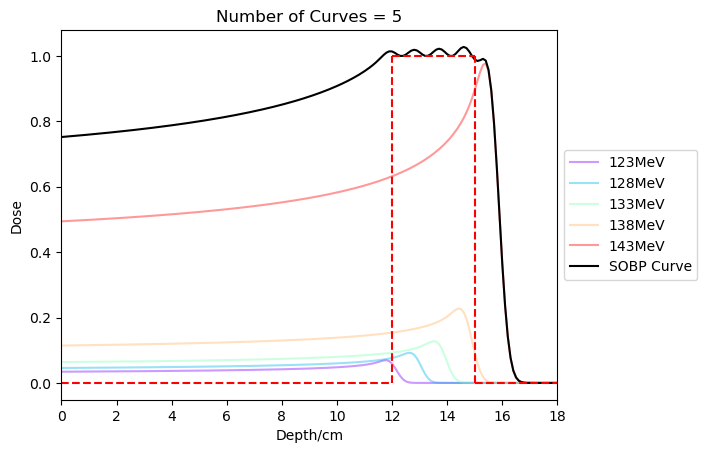

6 Curves
[123. 127. 131. 135. 139. 143.]
     pcost       dcost       gap    pres   dres
 0: -1.8097e-03  7.2134e+01  1e+02  2e+00  7e+00
 1: -6.4650e-03 -3.0844e+01  5e+01  6e-01  2e+00
 2:  7.5447e-03 -2.2821e+00  2e+00  3e-02  9e-02
 3:  6.5274e-03 -5.5529e-02  6e-02  3e-04  9e-04
 4: -8.3679e-03 -1.6742e-02  8e-03  1e-06  4e-06
 5: -1.1618e-02 -1.2749e-02  1e-03  8e-16  2e-19
 6: -1.2066e-02 -1.2244e-02  2e-04  7e-16  2e-19
 7: -1.2137e-02 -1.2164e-02  3e-05  7e-16  2e-19
 8: -1.2148e-02 -1.2152e-02  4e-06  3e-16  2e-19
 9: -1.2149e-02 -1.2150e-02  5e-07  7e-16  2e-19
10: -1.2150e-02 -1.2150e-02  1e-07  3e-16  1e-19
11: -1.2150e-02 -1.2150e-02  2e-08  2e-16  1e-19
Optimal solution found.
1.4211057862819513e-13


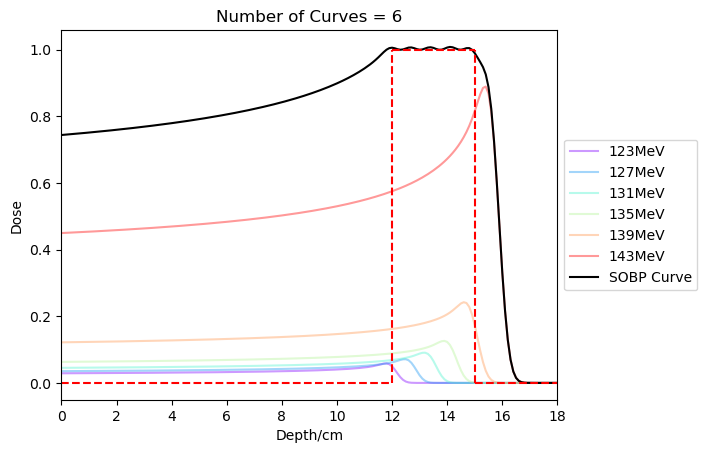

7 Curves
[123.         126.33333333 129.66666667 133.         136.33333333
 139.66666667 143.        ]
     pcost       dcost       gap    pres   dres
 0: -2.4542e-03  6.9692e+01  1e+02  2e+00  8e+00
 1: -2.8463e-03 -3.0687e+01  4e+01  4e-01  2e+00
 2:  7.7959e-03 -1.3324e+00  1e+00  1e-02  5e-02
 3:  3.7996e-03 -4.7057e-02  5e-02  6e-05  2e-04
 4: -1.1910e-02 -1.8233e-02  6e-03  1e-15  6e-19
 5: -1.3989e-02 -1.4766e-02  8e-04  1e-15  3e-19
 6: -1.4228e-02 -1.4334e-02  1e-04  4e-16  2e-19
 7: -1.4265e-02 -1.4282e-02  2e-05  8e-16  2e-19
 8: -1.4272e-02 -1.4274e-02  3e-06  4e-16  2e-19
 9: -1.4273e-02 -1.4273e-02  3e-07  1e-15  1e-19
10: -1.4273e-02 -1.4273e-02  4e-08  7e-16  2e-19
Optimal solution found.
1.9412391294182938e-13


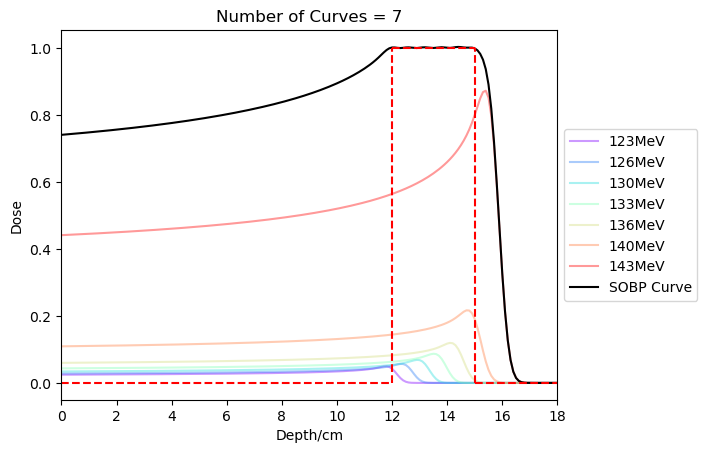

8 Curves
[123.         125.85714286 128.71428571 131.57142857 134.42857143
 137.28571429 140.14285714 143.        ]
     pcost       dcost       gap    pres   dres
 0: -3.1842e-03  6.7504e+01  1e+02  2e+00  8e+00
 1: -6.0125e-03 -3.7982e+01  5e+01  5e-01  2e+00
 2:  6.1296e-03 -1.7746e+00  2e+00  2e-02  6e-02
 3:  2.1648e-03 -5.7171e-02  6e-02  7e-05  3e-04
 4: -1.4240e-02 -2.0952e-02  7e-03  7e-16  8e-19
 5: -1.6156e-02 -1.7004e-02  8e-04  6e-16  2e-19
 6: -1.6362e-02 -1.6512e-02  1e-04  1e-15  3e-19
 7: -1.6400e-02 -1.6420e-02  2e-05  8e-16  1e-19
 8: -1.6407e-02 -1.6410e-02  3e-06  8e-16  2e-19
 9: -1.6408e-02 -1.6409e-02  4e-07  7e-16  2e-19
10: -1.6408e-02 -1.6408e-02  6e-08  7e-16  1e-19
Optimal solution found.
8.198886124774481e-13


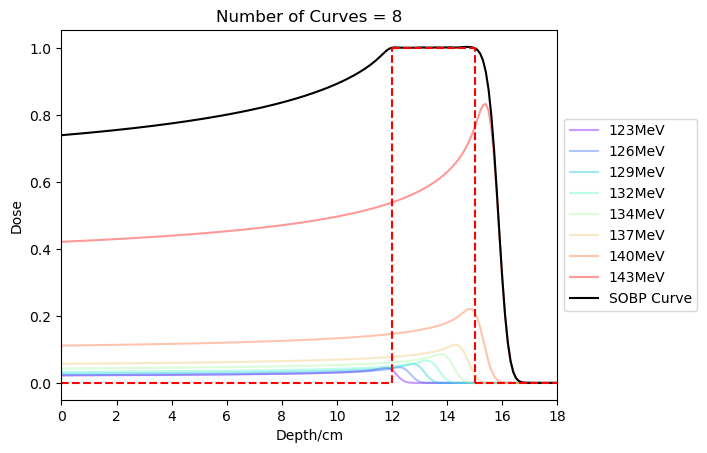

9 Curves
[123.  125.5 128.  130.5 133.  135.5 138.  140.5 143. ]
     pcost       dcost       gap    pres   dres
 0: -3.9911e-03  6.5729e+01  1e+02  2e+00  9e+00
 1: -8.1532e-03 -4.0412e+01  5e+01  6e-01  2e+00
 2:  5.4213e-03 -1.8823e+00  2e+00  2e-02  7e-02
 3:  1.1969e-03 -6.0793e-02  6e-02  7e-05  3e-04
 4: -1.6258e-02 -2.3284e-02  7e-03  8e-16  8e-19
 5: -1.8272e-02 -1.9261e-02  1e-03  7e-16  3e-19
 6: -1.8494e-02 -1.8661e-02  2e-04  5e-16  1e-19
 7: -1.8533e-02 -1.8555e-02  2e-05  4e-16  3e-19
 8: -1.8540e-02 -1.8543e-02  3e-06  4e-16  2e-19
 9: -1.8541e-02 -1.8541e-02  4e-07  7e-16  3e-19
10: -1.8541e-02 -1.8541e-02  8e-08  7e-16  3e-19
Optimal solution found.
3.594365262961431e-13


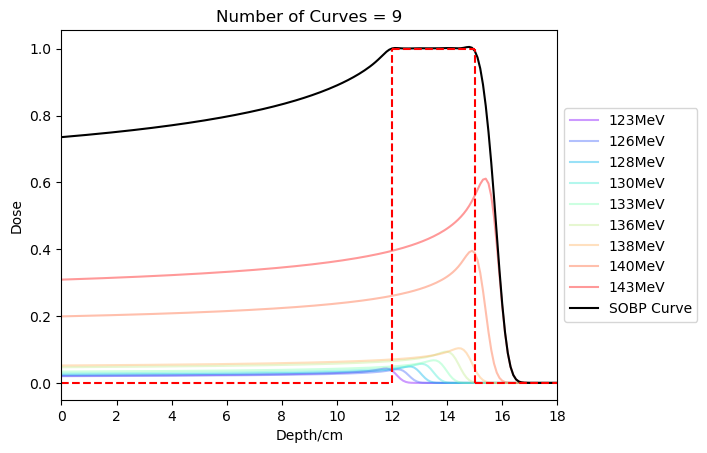

10 Curves
[123.         125.22222222 127.44444444 129.66666667 131.88888889
 134.11111111 136.33333333 138.55555556 140.77777778 143.        ]
     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-19
 7: -2.0663e-02 -2.0684e-02  2e-05  7e-16  5e-19
 8: -2.0670e-02 -2.0673e-02  3e-06  7e-16  5e-19
 9: -2.0671e-02 -2.0671e-02  5e-07  7e-16  3e-19
10: -2.0671e-02 -2.0671e-02  7e-08  7e-16  3e-19
Optimal solution found.
1.3778386222257174e-08


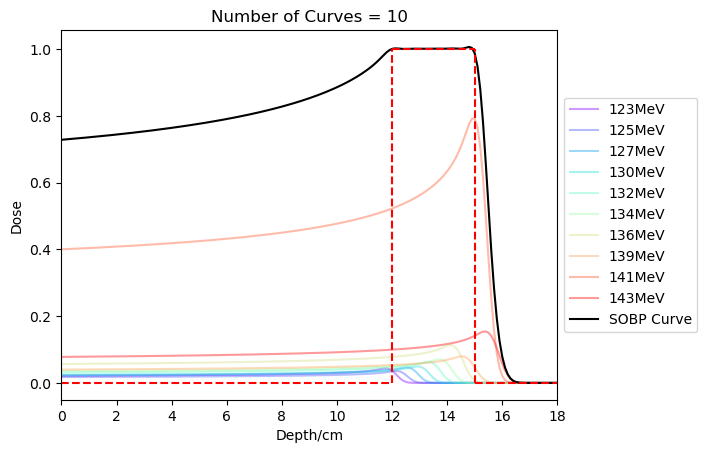

11 Curves
[123. 125. 127. 129. 131. 133. 135. 137. 139. 141. 143.]
     pcost       dcost       gap    pres   dres
 0: -5.8183e-03  6.1826e+01  1e+02  2e+00  9e+00
 1: -1.1972e-02 -4.1825e+01  5e+01  6e-01  3e+00
 2:  4.3502e-03 -1.7826e+00  2e+00  2e-02  8e-02
 3: -1.2421e-03 -6.4667e-02  6e-02  3e-05  1e-04
 4: -2.0426e-02 -2.7776e-02  7e-03  1e-15  2e-18
 5: -2.2565e-02 -2.3496e-02  9e-04  7e-16  6e-19
 6: -2.2763e-02 -2.2896e-02  1e-04  9e-16  4e-19
 7: -2.2794e-02 -2.2811e-02  2e-05  7e-16  5e-19
 8: -2.2799e-02 -2.2802e-02  3e-06  4e-16  3e-19
 9: -2.2800e-02 -2.2800e-02  4e-07  3e-16  3e-19
10: -2.2800e-02 -2.2800e-02  6e-08  7e-16  3e-19
Optimal solution found.
8.388296569075463e-09


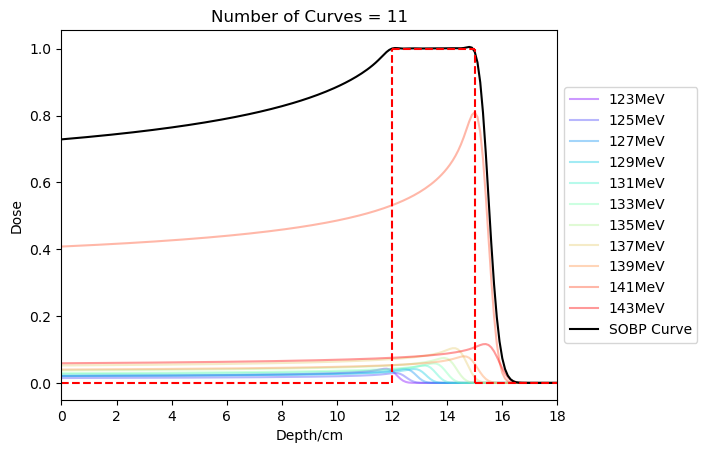

12 Curves
[123.         124.81818182 126.63636364 128.45454545 130.27272727
 132.09090909 133.90909091 135.72727273 137.54545455 139.36363636
 141.18181818 143.        ]
     pcost       dcost       gap    pres   dres
 0: -6.8306e-03  5.9888e+01  1e+02  2e+00  1e+01
 1: -1.3560e-02 -4.1389e+01  5e+01  6e-01  3e+00
 2:  4.0682e-03 -1.6815e+00  2e+00  2e-02  8e-02
 3: -2.5002e-03 -6.6015e-02  6e-02  1e-05  6e-05
 4: -2.2504e-02 -2.9995e-02  7e-03  7e-16  1e-18
 5: -2.4682e-02 -2.5664e-02  1e-03  3e-16  5e-19
 6: -2.4891e-02 -2.5019e-02  1e-04  1e-15  3e-19
 7: -2.4922e-02 -2.4939e-02  2e-05  2e-16  5e-19
 8: -2.4927e-02 -2.4930e-02  2e-06  3e-16  5e-19
 9: -2.4928e-02 -2.4929e-02  4e-07  3e-16  5e-19
10: -2.4928e-02 -2.4928e-02  6e-08  7e-16  5e-19
Optimal solution found.
4.365282697604666e-09


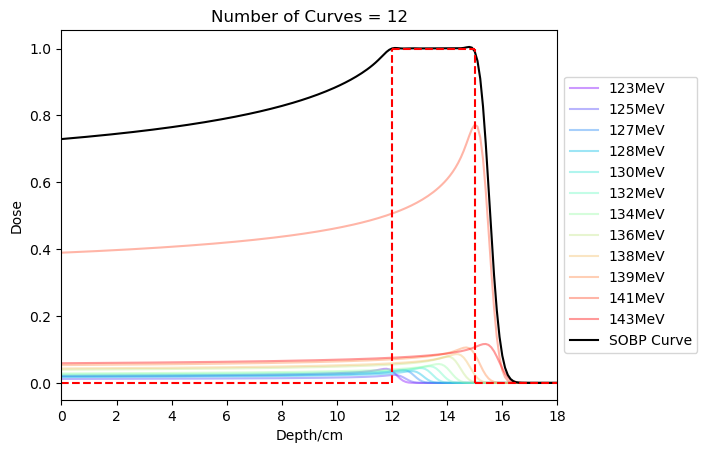

13 Curves
[123.         124.66666667 126.33333333 128.         129.66666667
 131.33333333 133.         134.66666667 136.33333333 138.
 139.66666667 141.33333333 143.        ]
     pcost       dcost       gap    pres   dres
 0: -7.9036e-03  5.8168e+01  1e+02  2e+00  1e+01
 1: -1.4967e-02 -4.0462e+01  5e+01  6e-01  3e+00
 2:  3.8716e-03 -1.6085e+00  2e+00  2e-02  8e-02
 3: -3.8230e-03 -6.8370e-02  6e-02  7e-16  6e-18
 4: -2.4588e-02 -3.2255e-02  8e-03  1e-15  1e-18
 5: -2.6810e-02 -2.7813e-02  1e-03  8e-16  4e-19
 6: -2.7020e-02 -2.7144e-02  1e-04  1e-15  6e-19
 7: -2.7050e-02 -2.7067e-02  2e-05  3e-16  6e-19
 8: -2.7055e-02 -2.7058e-02  3e-06  1e-15  4e-19
 9: -2.7056e-02 -2.7057e-02  5e-07  1e-15  7e-19
10: -2.7056e-02 -2.7056e-02  7e-08  3e-16  8e-19
Optimal solution found.
1.3683882555898565e-13


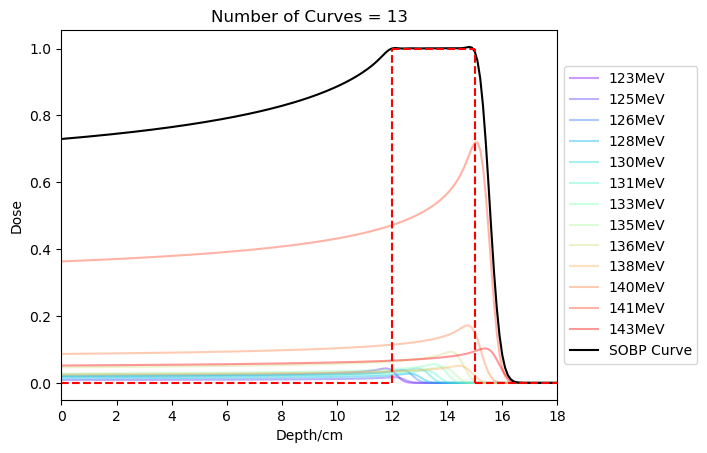

14 Curves
[123.         124.53846154 126.07692308 127.61538462 129.15384615
 130.69230769 132.23076923 133.76923077 135.30769231 136.84615385
 138.38461538 139.92307692 141.46153846 143.        ]
     pcost       dcost       gap    pres   dres
 0: -9.0340e-03  5.6477e+01  1e+02  2e+00  1e+01
 1: -1.6023e-02 -3.9385e+01  5e+01  6e-01  3e+00
 2:  4.0738e-03 -1.5372e+00  2e+00  2e-02  7e-02
 3: -5.0962e-03 -7.2290e-02  7e-02  1e-15  1e-17
 4: -2.6632e-02 -3.4611e-02  8e-03  1e-15  1e-18
 5: -2.8961e-02 -2.9936e-02  1e-03  8e-16  1e-18
 6: -2.9149e-02 -2.9274e-02  1e-04  6e-16  7e-19
 7: -2.9178e-02 -2.9194e-02  2e-05  3e-16  7e-19
 8: -2.9183e-02 -2.9185e-02  2e-06  7e-16  7e-19
 9: -2.9184e-02 -2.9184e-02  4e-07  7e-16  5e-19
10: -2.9184e-02 -2.9184e-02  5e-08  4e-16  4e-19
Optimal solution found.
1.26218417525258e-10


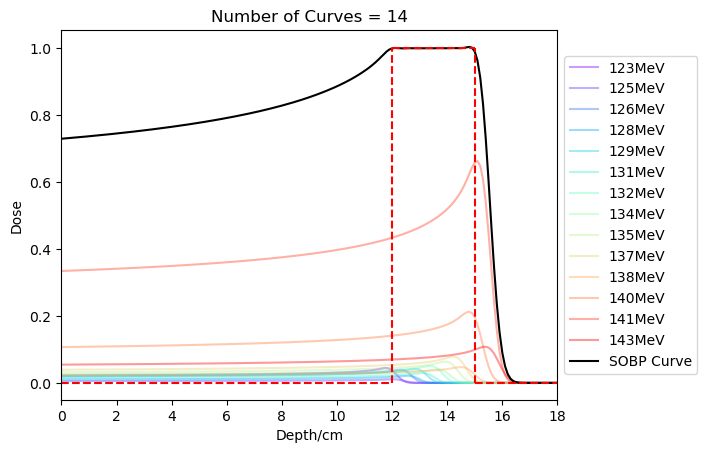

15 Curves
[123.         124.42857143 125.85714286 127.28571429 128.71428571
 130.14285714 131.57142857 133.         134.42857143 135.85714286
 137.28571429 138.71428571 140.14285714 141.57142857 143.        ]
     pcost       dcost       gap    pres   dres
 0: -1.0218e-02  5.4791e+01  1e+02  2e+00  1e+01
 1: -1.6939e-02 -3.8156e+01  5e+01  6e-01  3e+00
 2:  4.3125e-03 -1.4506e+00  1e+00  2e-02  7e-02
 3: -6.6081e-03 -7.5867e-02  7e-02  8e-16  1e-17
 4: -2.8552e-02 -3.7304e-02  9e-03  9e-16  2e-18
 5: -3.1041e-02 -3.2193e-02  1e-03  5e-16  1e-18
 6: -3.1275e-02 -3.1394e-02  1e-04  5e-16  8e-19
 7: -3.1304e-02 -3.1322e-02  2e-05  3e-16  8e-19
 8: -3.1310e-02 -3.1312e-02  2e-06  4e-16  7e-19
 9: -3.1311e-02 -3.1311e-02  4e-07  5e-16  5e-19
10: -3.1311e-02 -3.1311e-02  5e-08  4e-16  5e-19
Optimal solution found.
2.8464393473970096e-09


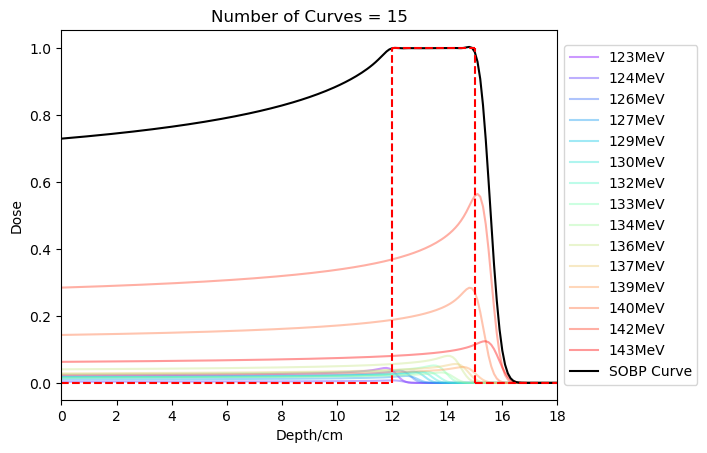

16 Curves
[123.         124.33333333 125.66666667 127.         128.33333333
 129.66666667 131.         132.33333333 133.66666667 135.
 136.33333333 137.66666667 139.         140.33333333 141.66666667
 143.        ]
     pcost       dcost       gap    pres   dres
 0: -1.1454e-02  5.3133e+01  1e+02  2e+00  1e+01
 1: -1.7697e-02 -3.6802e+01  5e+01  6e-01  3e+00
 2:  4.6017e-03 -1.3536e+00  1e+00  1e-02  7e-02
 3: -8.3729e-03 -7.9038e-02  7e-02  1e-15  8e-18
 4: -3.0548e-02 -3.9831e-02  9e-03  9e-16  2e-18
 5: -3.3142e-02 -3.4410e-02  1e-03  8e-16  1e-18
 6: -3.3402e-02 -3.3510e-02  1e-04  5e-16  5e-19
 7: -3.3432e-02 -3.3448e-02  2e-05  5e-16  7e-19
 8: -3.3437e-02 -3.3439e-02  3e-06  3e-16  6e-19
 9: -3.3438e-02 -3.3438e-02  5e-07  8e-16  5e-19
10: -3.3438e-02 -3.3438e-02  8e-08  5e-16  9e-19
Optimal solution found.
5.286344613869992e-09


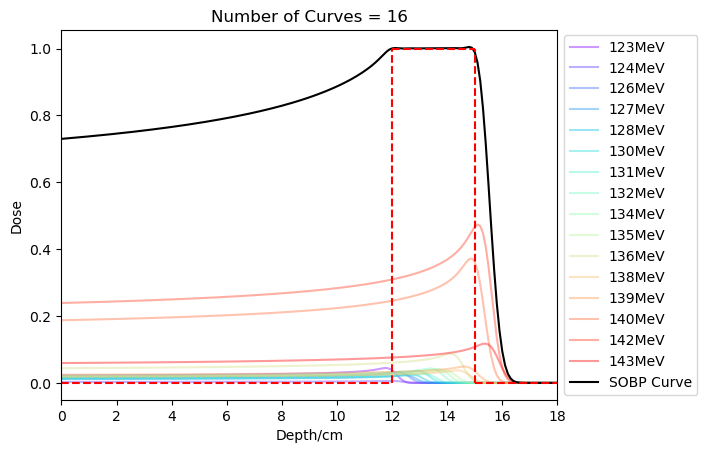

17 Curves
[123.   124.25 125.5  126.75 128.   129.25 130.5  131.75 133.   134.25
 135.5  136.75 138.   139.25 140.5  141.75 143.  ]
     pcost       dcost       gap    pres   dres
 0: -1.2737e-02  5.1541e+01  1e+02  2e+00  1e+01
 1: -1.8294e-02 -3.5361e+01  4e+01  6e-01  3e+00
 2:  4.9435e-03 -1.2515e+00  1e+00  1e-02  6e-02
 3: -1.0403e-02 -8.1763e-02  7e-02  8e-16  9e-18
 4: -3.2609e-02 -4.2210e-02  1e-02  8e-16  1e-18
 5: -3.5253e-02 -3.6595e-02  1e-03  5e-16  9e-19
 6: -3.5529e-02 -3.5633e-02  1e-04  8e-16  7e-19
 7: -3.5558e-02 -3.5574e-02  2e-05  5e-16  8e-19
 8: -3.5564e-02 -3.5566e-02  2e-06  5e-16  8e-19
 9: -3.5564e-02 -3.5565e-02  4e-07  4e-16  7e-19
10: -3.5564e-02 -3.5565e-02  6e-08  4e-16  7e-19
Optimal solution found.
2.0546867107460872e-13


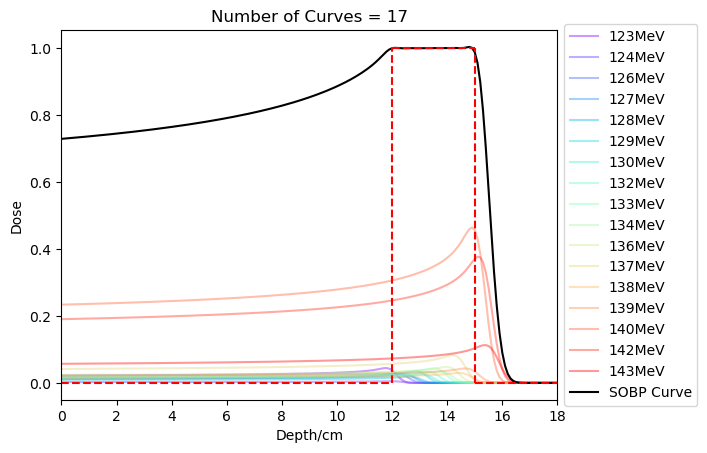

18 Curves
[123.         124.17647059 125.35294118 126.52941176 127.70588235
 128.88235294 130.05882353 131.23529412 132.41176471 133.58823529
 134.76470588 135.94117647 137.11764706 138.29411765 139.47058824
 140.64705882 141.82352941 143.        ]
     pcost       dcost       gap    pres   dres
 0: -1.4067e-02  5.0045e+01  1e+02  2e+00  1e+01
 1: -1.8733e-02 -3.3873e+01  4e+01  5e-01  3e+00
 2:  5.3351e-03 -1.1486e+00  1e+00  1e-02  6e-02
 3: -1.2687e-02 -8.3992e-02  7e-02  1e-15  8e-18
 4: -3.4722e-02 -4.4455e-02  1e-02  8e-16  2e-18
 5: -3.7374e-02 -3.8750e-02  1e-03  5e-16  1e-18
 6: -3.7654e-02 -3.7765e-02  1e-04  3e-16  8e-19
 7: -3.7685e-02 -3.7701e-02  2e-05  4e-16  1e-18
 8: -3.7690e-02 -3.7692e-02  2e-06  4e-16  1e-18
 9: -3.7691e-02 -3.7691e-02  4e-07  5e-16  1e-18
10: -3.7691e-02 -3.7691e-02  7e-08  4e-16  1e-18
Optimal solution found.
1.3410740436967512e-13


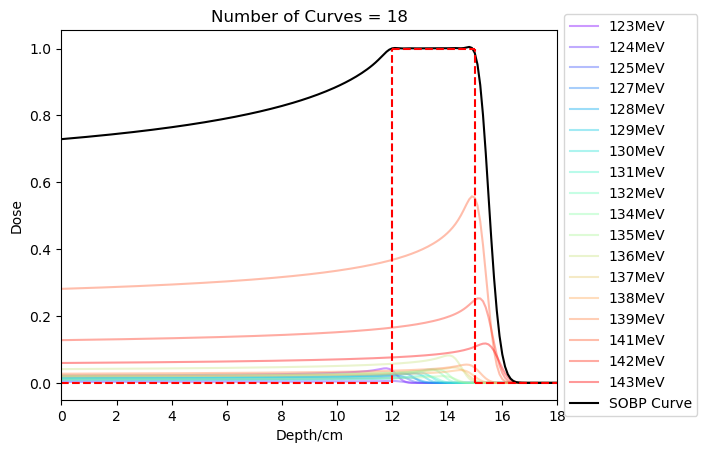

19 Curves
[123.         124.11111111 125.22222222 126.33333333 127.44444444
 128.55555556 129.66666667 130.77777778 131.88888889 133.
 134.11111111 135.22222222 136.33333333 137.44444444 138.55555556
 139.66666667 140.77777778 141.88888889 143.        ]
     pcost       dcost       gap    pres   dres
 0: -1.5439e-02  4.8569e+01  1e+02  2e+00  1e+01
 1: -1.8902e-02 -3.2389e+01  4e+01  5e-01  3e+00
 2:  5.9548e-03 -1.0408e+00  1e+00  1e-02  5e-02
 3: -1.5221e-02 -8.5650e-02  7e-02  8e-16  7e-18
 4: -3.6877e-02 -4.6588e-02  1e-02  6e-16  2e-18
 5: -3.9504e-02 -4.0875e-02  1e-03  9e-16  1e-18
 6: -3.9780e-02 -3.9894e-02  1e-04  5e-16  1e-18
 7: -3.9811e-02 -3.9827e-02  2e-05  8e-16  1e-18
 8: -3.9816e-02 -3.9819e-02  2e-06  5e-16  1e-18
 9: -3.9817e-02 -3.9818e-02  4e-07  3e-16  1e-18
10: -3.9817e-02 -3.9817e-02  7e-08  7e-16  1e-18
Optimal solution found.
1.452876976355668e-13


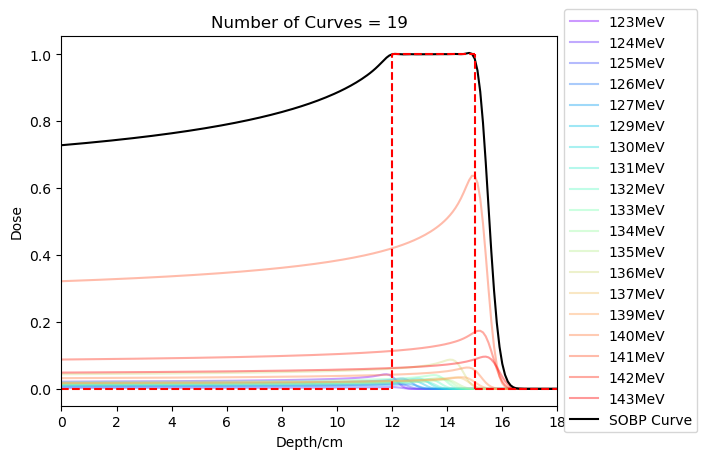

20 Curves
[123.         124.05263158 125.10526316 126.15789474 127.21052632
 128.26315789 129.31578947 130.36842105 131.42105263 132.47368421
 133.52631579 134.57894737 135.63157895 136.68421053 137.73684211
 138.78947368 139.84210526 140.89473684 141.94736842 143.        ]
     pcost       dcost       gap    pres   dres
 0: -1.6852e-02  4.7121e+01  1e+02  2e+00  1e+01
 1: -1.8848e-02 -3.0873e+01  4e+01  5e-01  2e+00
 2:  6.6670e-03 -9.2908e-01  9e-01  9e-03  5e-02
 3: -1.8126e-02 -8.6582e-02  7e-02  9e-16  1e-17
 4: -3.9088e-02 -4.8612e-02  1e-02  6e-16  2e-18
 5: -4.1649e-02 -4.2964e-02  1e-03  7e-16  1e-18
 6: -4.1908e-02 -4.2019e-02  1e-04  4e-16  1e-18
 7: -4.1938e-02 -4.1953e-02  2e-05  3e-16  1e-18
 8: -4.1943e-02 -4.1945e-02  2e-06  8e-16  1e-18
 9: -4.1943e-02 -4.1944e-02  3e-07  7e-16  2e-18
10: -4.1944e-02 -4.1944e-02  5e-08  7e-16  1e-18
Optimal solution found.
1.5454808139308194e-13


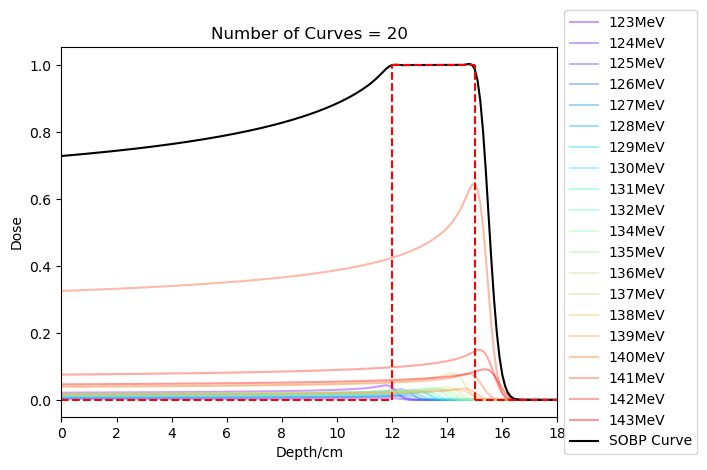

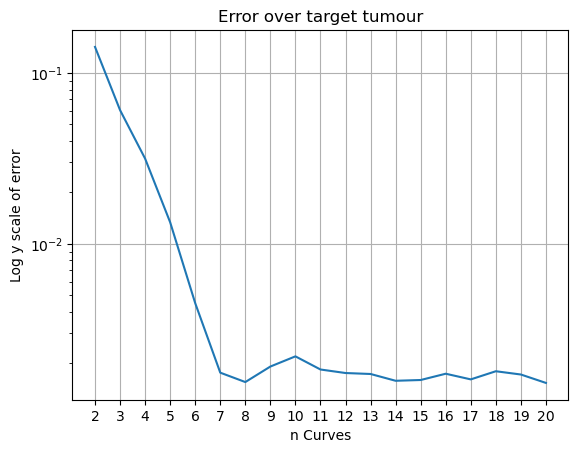

In [28]:
eZeroLower = 123;eZeroUpper = 143
yValues2,nminerr2 = PlotErrorStagnationQP(lower,upper,dose, perc,theta, phi,eZeroLower,eZeroUpper,ncurves)

From 123 to 145

2 Curves
[123. 145.]
     pcost       dcost       gap    pres   dres
 0: -1.0844e-04  7.9129e+01  9e+01  2e+00  4e+00
 1: -1.4365e-03  6.8611e+01  9e+01  2e+00  3e+00
 2:  1.0691e-03 -2.8925e+01  3e+01  3e-01  4e-01
 3:  1.8059e-03 -3.5184e-01  4e-01  3e-03  5e-03
 4:  9.8913e-04 -1.3385e-02  1e-02  4e-05  7e-05
 5: -1.9607e-03 -4.9773e-03  3e-03  6e-06  1e-05
 6: -2.6713e-03 -3.1500e-03  5e-04  1e-07  2e-07
 7: -2.8482e-03 -2.8981e-03  5e-05  3e-15  3e-20
 8: -2.8657e-03 -2.8775e-03  1e-05  1e-15  1e-20
 9: -2.8656e-03 -2.8727e-03  7e-06  1e-16  2e-20
10: -2.8665e-03 -2.8682e-03  2e-06  1e-15  1e-20
11: -2.8666e-03 -2.8668e-03  2e-07  1e-15  9e-20
12: -2.8666e-03 -2.8666e-03  3e-09  3e-15  9e-20
Optimal solution found.
2.649063011972787e-13


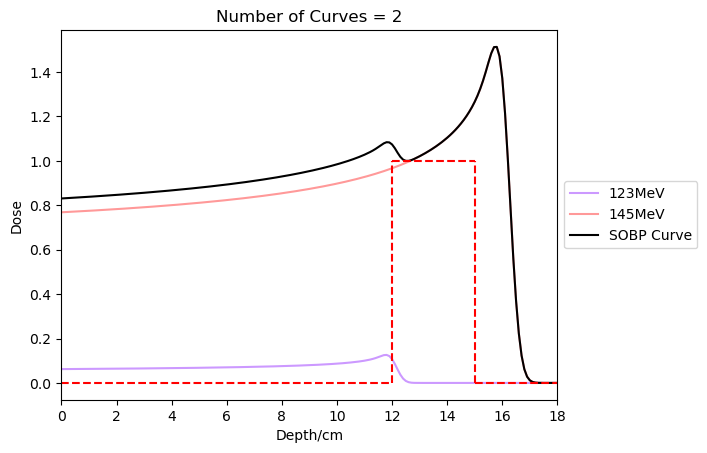

3 Curves
[123. 134. 145.]
     pcost       dcost       gap    pres   dres
 0: -3.9589e-04  7.6231e+01  9e+01  2e+00  5e+00
 1: -4.6366e-03  3.1713e+01  9e+01  1e+00  3e+00
 2:  1.4361e-03 -2.4490e+01  3e+01  3e-01  6e-01
 3:  4.2057e-03 -4.1264e-01  4e-01  4e-03  8e-03
 4:  1.8556e-03 -1.9911e-02  2e-02  4e-05  8e-05
 5: -4.1595e-03 -7.6918e-03  4e-03  3e-06  6e-06
 6: -5.2500e-03 -5.6914e-03  4e-04  3e-16  6e-20
 7: -5.4188e-03 -5.4717e-03  5e-05  3e-15  3e-20
 8: -5.4362e-03 -5.4487e-03  1e-05  2e-16  6e-21
 9: -5.4357e-03 -5.4465e-03  1e-05  1e-15  2e-20
10: -5.4371e-03 -5.4399e-03  3e-06  1e-15  1e-19
11: -5.4377e-03 -5.4383e-03  6e-07  1e-16  5e-20
12: -5.4377e-03 -5.4379e-03  2e-07  1e-15  4e-20
13: -5.4378e-03 -5.4378e-03  3e-09  3e-15  7e-20
Optimal solution found.
7.370288477121197e-14


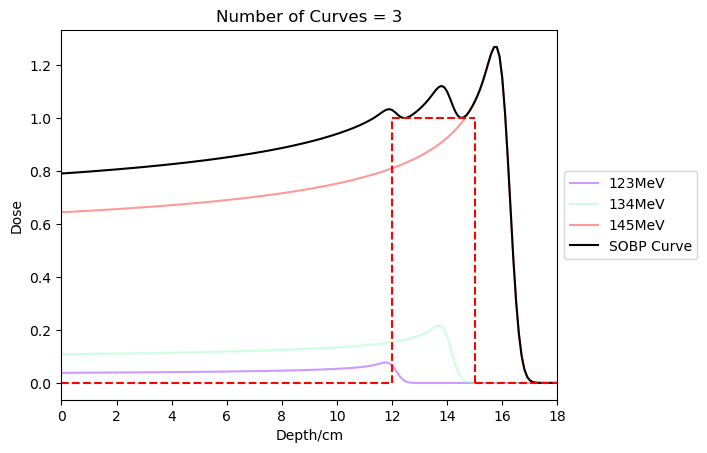

4 Curves
[123.         130.33333333 137.66666667 145.        ]
     pcost       dcost       gap    pres   dres
 0: -8.2034e-04  7.6530e+01  1e+02  2e+00  6e+00
 1: -8.0515e-03 -7.9325e+00  8e+01  1e+00  3e+00
 2:  4.8354e-03 -6.6776e+00  7e+00  7e-02  2e-01
 3:  5.8264e-03 -9.2502e-02  1e-01  7e-04  2e-03
 4: -3.0556e-03 -1.4118e-02  1e-02  4e-06  1e-05
 5: -7.3222e-03 -8.9714e-03  2e-03  1e-15  2e-19
 6: -7.9654e-03 -8.1970e-03  2e-04  8e-16  7e-20
 7: -8.0529e-03 -8.0834e-03  3e-05  1e-15  8e-20
 8: -8.0608e-03 -8.0660e-03  5e-06  7e-16  1e-19
 9: -8.0610e-03 -8.0626e-03  2e-06  1e-15  2e-19
10: -8.0614e-03 -8.0615e-03  1e-07  7e-16  2e-20
11: -8.0614e-03 -8.0614e-03  1e-09  7e-16  1e-19
Optimal solution found.
1.3167583114764149e-12


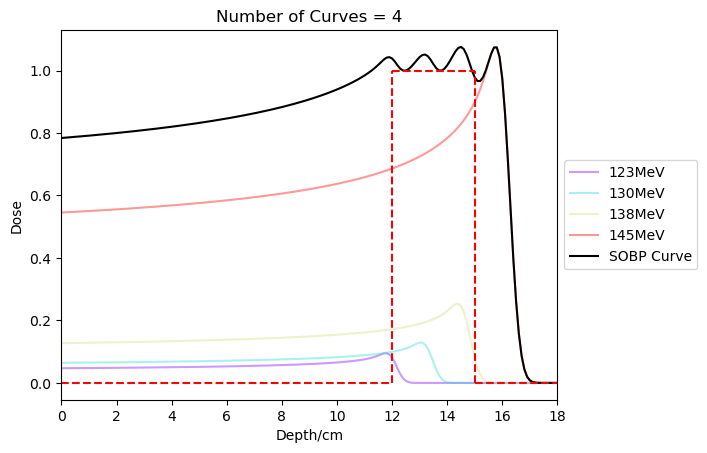

5 Curves
[123.  128.5 134.  139.5 145. ]
     pcost       dcost       gap    pres   dres
 0: -1.2864e-03  7.4093e+01  1e+02  2e+00  7e+00
 1: -9.0748e-03 -2.4541e+01  7e+01  9e-01  3e+00
 2:  5.8883e-03 -4.7560e+00  5e+00  5e-02  2e-01
 3:  6.3466e-03 -7.9602e-02  9e-02  5e-04  2e-03
 4: -5.5217e-03 -1.6966e-02  1e-02  1e-05  3e-05
 5: -9.4844e-03 -1.1095e-02  2e-03  2e-15  1e-19
 6: -1.0102e-02 -1.0312e-02  2e-04  3e-16  1e-19
 7: -1.0184e-02 -1.0223e-02  4e-05  8e-16  5e-20
 8: -1.0200e-02 -1.0206e-02  6e-06  9e-16  1e-19
 9: -1.0202e-02 -1.0203e-02  1e-06  1e-15  2e-19
10: -1.0202e-02 -1.0203e-02  1e-06  2e-16  1e-18
11: -1.0202e-02 -1.0202e-02  2e-07  1e-15  1e-18
12: -1.0202e-02 -1.0202e-02  2e-08  1e-15  6e-19
Optimal solution found.
3.5818045859756085e-14


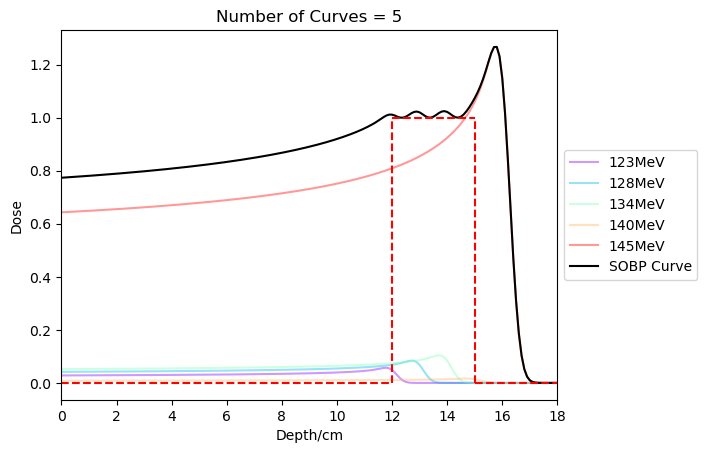

6 Curves
[123.  127.4 131.8 136.2 140.6 145. ]
     pcost       dcost       gap    pres   dres
 0: -1.8605e-03  7.1172e+01  1e+02  2e+00  7e+00
 1: -4.5699e-03 -2.8755e+01  4e+01  5e-01  2e+00
 2:  7.4947e-03 -1.7241e+00  2e+00  2e-02  7e-02
 3:  5.8216e-03 -4.9006e-02  5e-02  2e-04  6e-04
 4: -9.0232e-03 -1.6386e-02  7e-03  1e-15  4e-19
 5: -1.1909e-02 -1.2908e-02  1e-03  8e-16  2e-19
 6: -1.2306e-02 -1.2442e-02  1e-04  7e-16  1e-19
 7: -1.2362e-02 -1.2382e-02  2e-05  7e-16  1e-19
 8: -1.2370e-02 -1.2374e-02  4e-06  1e-15  2e-19
 9: -1.2371e-02 -1.2372e-02  9e-07  3e-15  3e-19
10: -1.2372e-02 -1.2372e-02  2e-07  2e-16  1e-19
11: -1.2372e-02 -1.2372e-02  4e-08  2e-16  3e-19
Optimal solution found.
3.988479977983301e-13


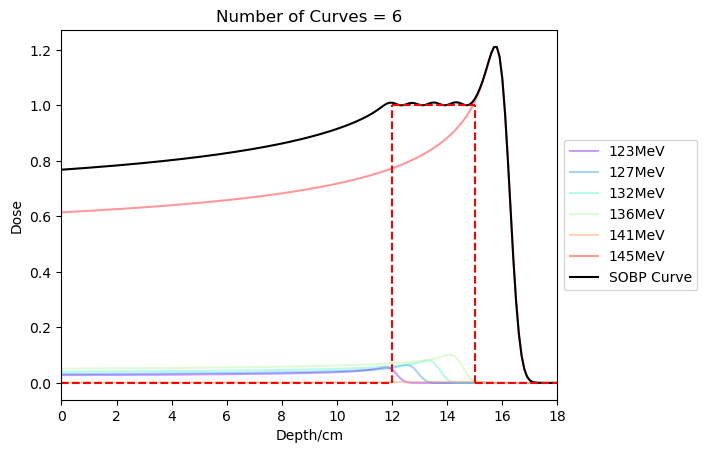

7 Curves
[123.         126.66666667 130.33333333 134.         137.66666667
 141.33333333 145.        ]
     pcost       dcost       gap    pres   dres
 0: -2.5435e-03  6.9532e+01  1e+02  2e+00  8e+00
 1: -2.4814e-03 -3.0263e+01  4e+01  4e-01  1e+00
 2:  7.1874e-03 -9.4596e-01  1e+00  9e-03  3e-02
 3:  1.3955e-03 -4.2416e-02  4e-02  1e-05  5e-05
 4: -1.2763e-02 -1.7998e-02  5e-03  8e-16  7e-19
 5: -1.4371e-02 -1.5108e-02  7e-04  3e-16  3e-19
 6: -1.4574e-02 -1.4682e-02  1e-04  7e-16  5e-20
 7: -1.4607e-02 -1.4624e-02  2e-05  8e-16  1e-19
 8: -1.4613e-02 -1.4616e-02  2e-06  4e-16  2e-19
 9: -1.4614e-02 -1.4615e-02  5e-07  2e-16  2e-19
10: -1.4614e-02 -1.4615e-02  1e-07  1e-15  4e-19
11: -1.4614e-02 -1.4614e-02  3e-08  1e-15  2e-19
Optimal solution found.
1.0699909448640474e-13


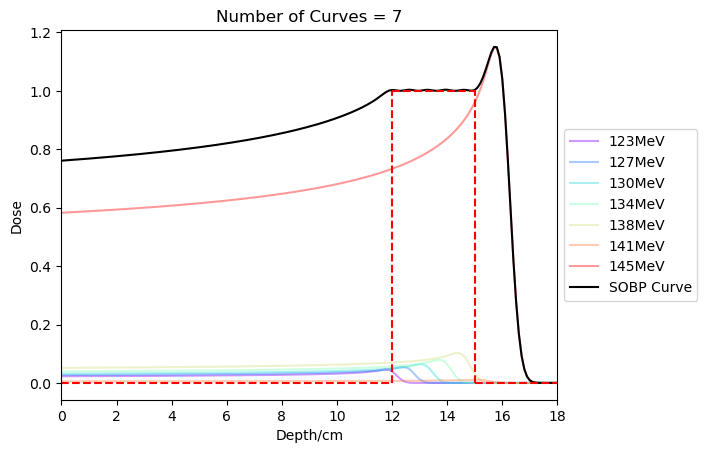

8 Curves
[123.         126.14285714 129.28571429 132.42857143 135.57142857
 138.71428571 141.85714286 145.        ]
     pcost       dcost       gap    pres   dres
 0: -3.3064e-03  6.7495e+01  1e+02  2e+00  8e+00
 1: -5.3272e-03 -3.6897e+01  4e+01  5e-01  2e+00
 2:  5.5663e-03 -1.2581e+00  1e+00  1e-02  4e-02
 3:  1.0404e-04 -5.0188e-02  5e-02  2e-05  6e-05
 4: -1.5045e-02 -2.0752e-02  6e-03  7e-16  4e-19
 5: -1.6604e-02 -1.7408e-02  8e-04  5e-16  2e-19
 6: -1.6777e-02 -1.6959e-02  2e-04  4e-16  2e-19
 7: -1.6817e-02 -1.6845e-02  3e-05  6e-16  2e-19
 8: -1.6825e-02 -1.6828e-02  3e-06  7e-16  3e-19
 9: -1.6826e-02 -1.6827e-02  5e-07  7e-16  3e-19
10: -1.6827e-02 -1.6827e-02  6e-08  1e-15  1e-19
Optimal solution found.
4.825163480567796e-13


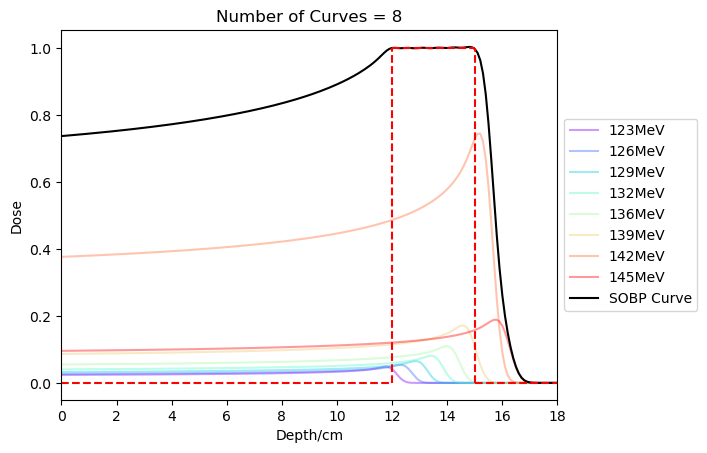

9 Curves
[123.   125.75 128.5  131.25 134.   136.75 139.5  142.25 145.  ]
     pcost       dcost       gap    pres   dres
 0: -4.1500e-03  6.5196e+01  1e+02  2e+00  9e+00
 1: -8.0603e-03 -4.0545e+01  5e+01  5e-01  2e+00
 2:  4.1637e-03 -1.2101e+00  1e+00  1e-02  5e-02
 3: -1.8055e-03 -5.1682e-02  5e-02  8e-06  3e-05
 4: -1.7220e-02 -2.2942e-02  6e-03  5e-16  7e-19
 5: -1.8853e-02 -1.9518e-02  7e-04  1e-15  4e-19
 6: -1.8995e-02 -1.9118e-02  1e-04  8e-16  3e-19
 7: -1.9026e-02 -1.9043e-02  2e-05  3e-16  3e-19
 8: -1.9031e-02 -1.9033e-02  2e-06  7e-16  2e-19
 9: -1.9032e-02 -1.9032e-02  4e-07  6e-16  3e-19
10: -1.9032e-02 -1.9032e-02  5e-08  5e-16  4e-19
Optimal solution found.
1.062381924549689e-12


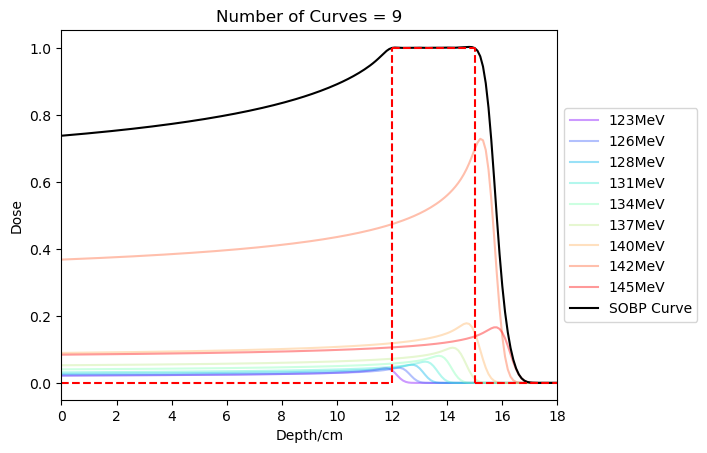

10 Curves
[123.         125.44444444 127.88888889 130.33333333 132.77777778
 135.22222222 137.66666667 140.11111111 142.55555556 145.        ]
     pcost       dcost       gap    pres   dres
 0: -5.0711e-03  6.3211e+01  1e+02  2e+00  9e+00
 1: -1.0372e-02 -4.1704e+01  5e+01  6e-01  2e+00
 2:  3.0361e-03 -1.1296e+00  1e+00  1e-02  5e-02
 3: -3.5197e-03 -5.2430e-02  5e-02  1e-15  8e-18
 4: -1.9354e-02 -2.5188e-02  6e-03  6e-16  6e-19
 5: -2.1056e-02 -2.1776e-02  7e-04  8e-16  4e-19
 6: -2.1206e-02 -2.1314e-02  1e-04  2e-16  2e-19
 7: -2.1234e-02 -2.1250e-02  2e-05  4e-16  4e-19
 8: -2.1239e-02 -2.1242e-02  3e-06  7e-16  2e-19
 9: -2.1240e-02 -2.1240e-02  4e-07  8e-16  2e-19
10: -2.1240e-02 -2.1240e-02  6e-08  4e-16  4e-19
Optimal solution found.
2.8460345035039277e-13


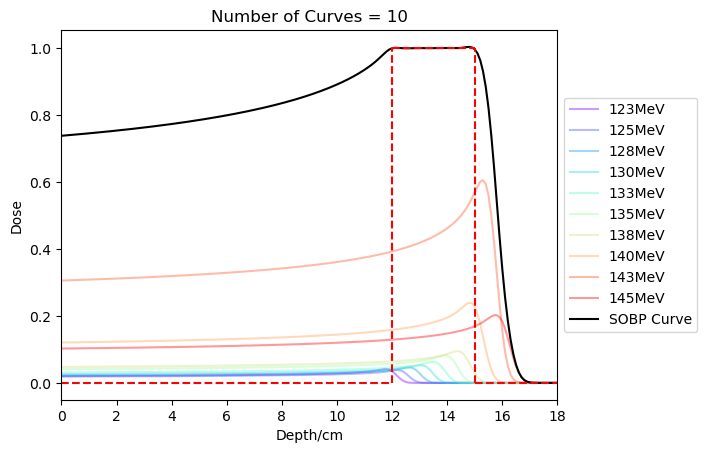

11 Curves
[123.  125.2 127.4 129.6 131.8 134.  136.2 138.4 140.6 142.8 145. ]
     pcost       dcost       gap    pres   dres
 0: -6.0640e-03  6.1390e+01  1e+02  2e+00  1e+01
 1: -1.2106e-02 -4.1646e+01  5e+01  6e-01  2e+00
 2:  2.5856e-03 -1.0749e+00  1e+00  1e-02  5e-02
 3: -5.1049e-03 -5.5603e-02  5e-02  9e-16  6e-18
 4: -2.1385e-02 -2.7826e-02  6e-03  8e-16  6e-19
 5: -2.3235e-02 -2.4076e-02  8e-04  6e-16  4e-19
 6: -2.3410e-02 -2.3532e-02  1e-04  5e-16  4e-19
 7: -2.3440e-02 -2.3457e-02  2e-05  4e-16  4e-19
 8: -2.3446e-02 -2.3448e-02  3e-06  8e-16  4e-19
 9: -2.3447e-02 -2.3447e-02  4e-07  7e-16  3e-19
10: -2.3447e-02 -2.3447e-02  5e-08  2e-16  4e-19
Optimal solution found.
5.410881528599659e-14


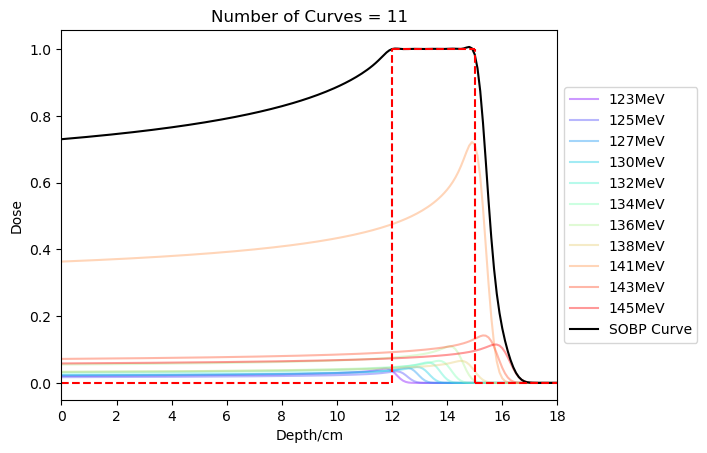

12 Curves
[123. 125. 127. 129. 131. 133. 135. 137. 139. 141. 143. 145.]
     pcost       dcost       gap    pres   dres
 0: -7.1245e-03  5.9448e+01  1e+02  2e+00  1e+01
 1: -1.3777e-02 -4.1112e+01  5e+01  6e-01  3e+00
 2:  2.0638e-03 -1.0056e+00  1e+00  1e-02  5e-02
 3: -6.9165e-03 -5.8355e-02  5e-02  7e-16  5e-18
 4: -2.3511e-02 -3.0286e-02  7e-03  5e-16  9e-19
 5: -2.5426e-02 -2.6341e-02  9e-04  4e-16  9e-19
 6: -2.5616e-02 -2.5738e-02  1e-04  7e-16  4e-19
 7: -2.5646e-02 -2.5664e-02  2e-05  7e-16  4e-19
 8: -2.5652e-02 -2.5654e-02  3e-06  7e-16  5e-19
 9: -2.5653e-02 -2.5653e-02  4e-07  7e-16  6e-19
10: -2.5653e-02 -2.5653e-02  7e-08  2e-16  5e-19
Optimal solution found.
8.004141933581998e-09


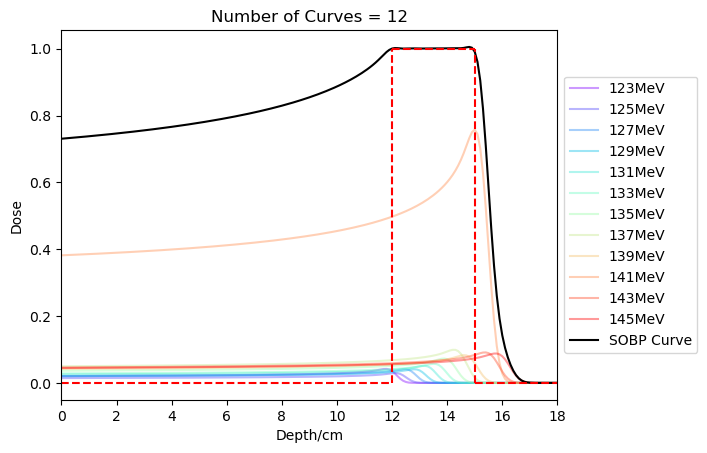

13 Curves
[123.         124.83333333 126.66666667 128.5        130.33333333
 132.16666667 134.         135.83333333 137.66666667 139.5
 141.33333333 143.16666667 145.        ]
     pcost       dcost       gap    pres   dres
 0: -8.2489e-03  5.7525e+01  1e+02  2e+00  1e+01
 1: -1.5313e-02 -4.0146e+01  5e+01  6e-01  3e+00
 2:  1.5998e-03 -9.4222e-01  9e-01  1e-02  5e-02
 3: -8.7883e-03 -6.0929e-02  5e-02  8e-16  5e-18
 4: -2.5736e-02 -3.2483e-02  7e-03  6e-16  1e-18
 5: -2.7635e-02 -2.8544e-02  9e-04  5e-16  8e-19
 6: -2.7824e-02 -2.7935e-02  1e-04  8e-16  7e-19
 7: -2.7852e-02 -2.7868e-02  2e-05  7e-16  5e-19
 8: -2.7857e-02 -2.7860e-02  2e-06  7e-16  6e-19
 9: -2.7858e-02 -2.7859e-02  4e-07  3e-16  7e-19
10: -2.7858e-02 -2.7858e-02  7e-08  7e-16  5e-19
Optimal solution found.
4.520120812166585e-09


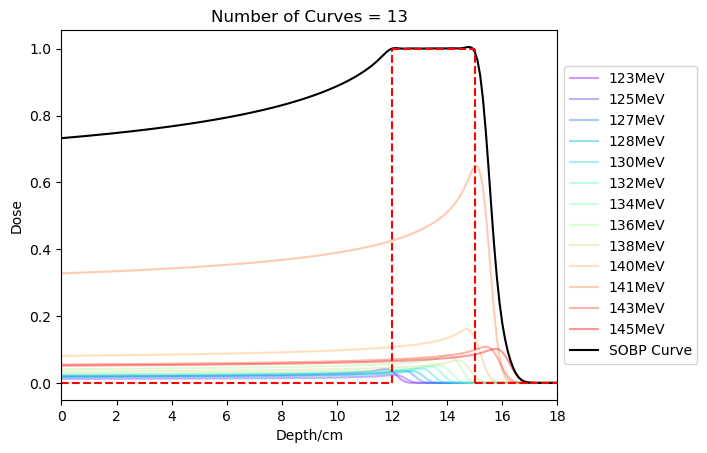

14 Curves
[123.         124.69230769 126.38461538 128.07692308 129.76923077
 131.46153846 133.15384615 134.84615385 136.53846154 138.23076923
 139.92307692 141.61538462 143.30769231 145.        ]
     pcost       dcost       gap    pres   dres
 0: -9.4332e-03  5.5867e+01  1e+02  2e+00  1e+01
 1: -1.6568e-02 -3.8910e+01  5e+01  6e-01  3e+00
 2:  1.3952e-03 -9.2297e-01  9e-01  1e-02  5e-02
 3: -1.0561e-02 -6.4534e-02  5e-02  8e-16  8e-18
 4: -2.7873e-02 -3.4942e-02  7e-03  5e-16  1e-18
 5: -2.9850e-02 -3.0766e-02  9e-04  6e-16  9e-19
 6: -3.0030e-02 -3.0139e-02  1e-04  6e-16  6e-19
 7: -3.0057e-02 -3.0075e-02  2e-05  5e-16  5e-19
 8: -3.0062e-02 -3.0065e-02  3e-06  8e-16  7e-19
 9: -3.0063e-02 -3.0064e-02  5e-07  5e-16  7e-19
10: -3.0064e-02 -3.0064e-02  8e-08  5e-16  6e-19
Optimal solution found.
1.0399687625505208e-13


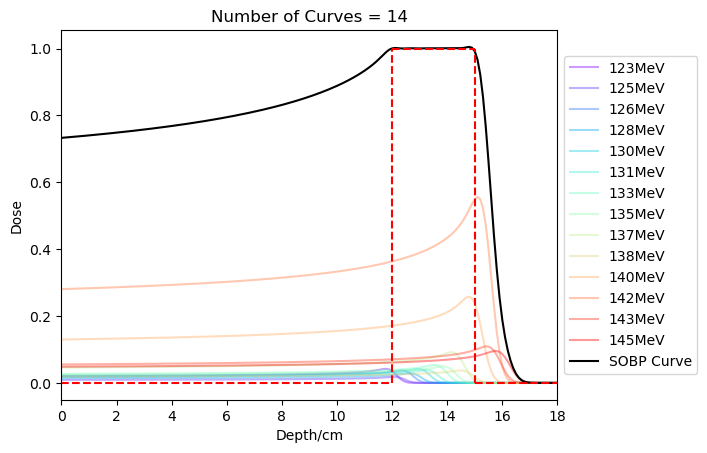

15 Curves
[123.         124.57142857 126.14285714 127.71428571 129.28571429
 130.85714286 132.42857143 134.         135.57142857 137.14285714
 138.71428571 140.28571429 141.85714286 143.42857143 145.        ]
     pcost       dcost       gap    pres   dres
 0: -1.0674e-02  5.4158e+01  1e+02  2e+00  1e+01
 1: -1.7591e-02 -3.7574e+01  5e+01  6e-01  3e+00
 2:  1.3727e-03 -8.8881e-01  9e-01  9e-03  4e-02
 3: -1.2516e-02 -6.7882e-02  6e-02  1e-15  6e-18
 4: -2.9910e-02 -3.7663e-02  8e-03  8e-16  8e-19
 5: -3.2018e-02 -3.3086e-02  1e-03  5e-16  8e-19
 6: -3.2234e-02 -3.2337e-02  1e-04  5e-16  5e-19
 7: -3.2262e-02 -3.2278e-02  2e-05  5e-16  4e-19
 8: -3.2267e-02 -3.2270e-02  3e-06  4e-16  6e-19
 9: -3.2268e-02 -3.2269e-02  4e-07  4e-16  7e-19
10: -3.2268e-02 -3.2269e-02  6e-08  7e-16  7e-19
Optimal solution found.
1.2788024269871661e-08


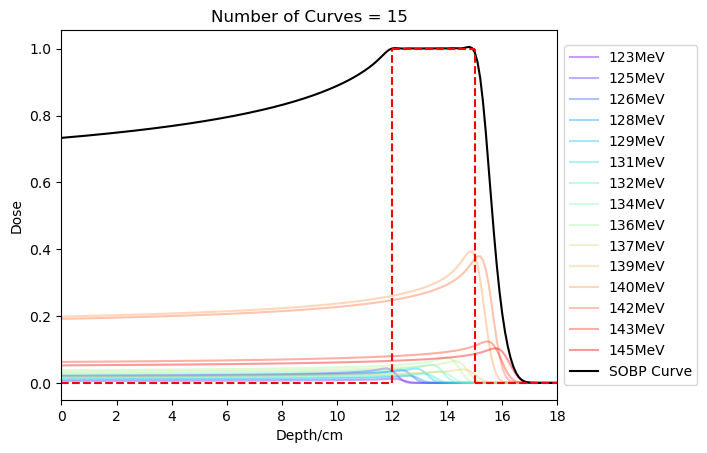

16 Curves
[123.         124.46666667 125.93333333 127.4        128.86666667
 130.33333333 131.8        133.26666667 134.73333333 136.2
 137.66666667 139.13333333 140.6        142.06666667 143.53333333
 145.        ]
     pcost       dcost       gap    pres   dres
 0: -1.1968e-02  5.2447e+01  1e+02  2e+00  1e+01
 1: -1.8499e-02 -3.6102e+01  4e+01  5e-01  3e+00
 2:  1.3309e-03 -8.4076e-01  8e-01  9e-03  4e-02
 3: -1.4756e-02 -7.0698e-02  6e-02  7e-16  8e-18
 4: -3.2098e-02 -4.0039e-02  8e-03  8e-16  2e-18
 5: -3.4212e-02 -3.5335e-02  1e-03  9e-16  8e-19
 6: -3.4439e-02 -3.4536e-02  1e-04  3e-16  8e-19
 7: -3.4467e-02 -3.4482e-02  1e-05  8e-16  8e-19
 8: -3.4472e-02 -3.4474e-02  2e-06  5e-16  6e-19
 9: -3.4473e-02 -3.4473e-02  3e-07  3e-16  8e-19
10: -3.4473e-02 -3.4473e-02  5e-08  7e-16  8e-19
Optimal solution found.
1.9414557801306456e-13


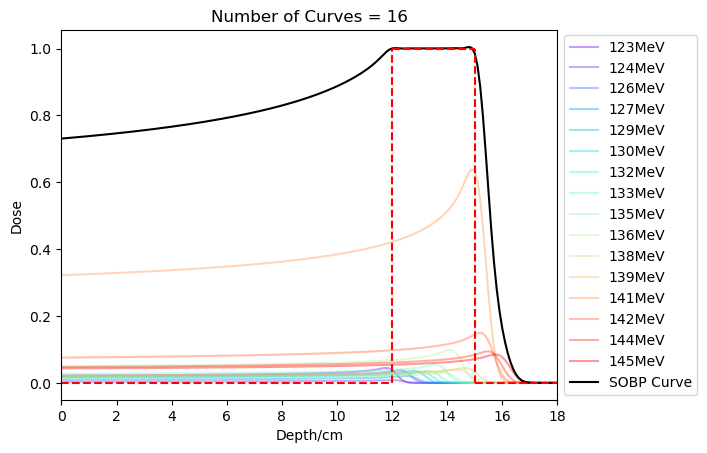

17 Curves
[123.    124.375 125.75  127.125 128.5   129.875 131.25  132.625 134.
 135.375 136.75  138.125 139.5   140.875 142.25  143.625 145.   ]
     pcost       dcost       gap    pres   dres
 0: -1.3313e-02  5.0866e+01  1e+02  2e+00  1e+01
 1: -1.9294e-02 -3.4550e+01  4e+01  5e-01  3e+00
 2:  1.2885e-03 -7.8997e-01  8e-01  8e-03  4e-02
 3: -1.7191e-02 -7.3118e-02  6e-02  7e-16  6e-18
 4: -3.4374e-02 -4.2175e-02  8e-03  1e-15  2e-18
 5: -3.6425e-02 -3.7527e-02  1e-03  5e-16  1e-18
 6: -3.6645e-02 -3.6738e-02  9e-05  5e-16  1e-18
 7: -3.6672e-02 -3.6686e-02  1e-05  4e-16  6e-19
 8: -3.6677e-02 -3.6679e-02  2e-06  5e-16  7e-19
 9: -3.6678e-02 -3.6678e-02  4e-07  8e-16  5e-19
10: -3.6678e-02 -3.6678e-02  6e-08  3e-16  6e-19
Optimal solution found.
2.2406147415260496e-13


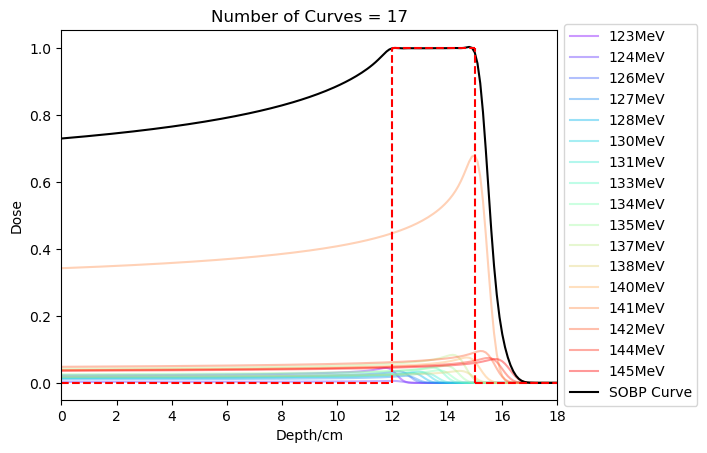

18 Curves
[123.         124.29411765 125.58823529 126.88235294 128.17647059
 129.47058824 130.76470588 132.05882353 133.35294118 134.64705882
 135.94117647 137.23529412 138.52941176 139.82352941 141.11764706
 142.41176471 143.70588235 145.        ]
     pcost       dcost       gap    pres   dres
 0: -1.4705e-02  4.9330e+01  1e+02  2e+00  1e+01
 1: -1.9798e-02 -3.3030e+01  4e+01  5e-01  2e+00
 2:  1.5249e-03 -7.3433e-01  7e-01  7e-03  4e-02
 3: -1.9781e-02 -7.5194e-02  6e-02  9e-16  5e-18
 4: -3.6685e-02 -4.4204e-02  8e-03  5e-16  1e-18
 5: -3.8670e-02 -3.9650e-02  1e-03  5e-16  2e-18
 6: -3.8854e-02 -3.8937e-02  8e-05  8e-16  2e-18
 7: -3.8877e-02 -3.8890e-02  1e-05  3e-16  1e-18
 8: -3.8881e-02 -3.8883e-02  2e-06  1e-15  6e-19
 9: -3.8882e-02 -3.8882e-02  3e-07  5e-16  6e-19
10: -3.8882e-02 -3.8882e-02  4e-08  7e-16  1e-18
Optimal solution found.
8.675721047864996e-10


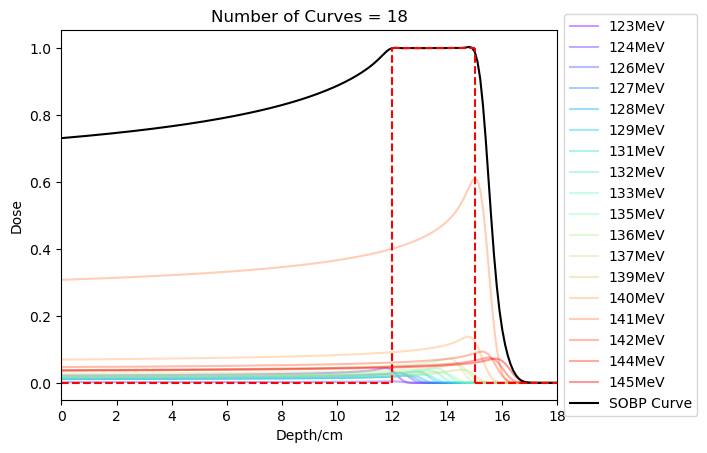

19 Curves
[123.         124.22222222 125.44444444 126.66666667 127.88888889
 129.11111111 130.33333333 131.55555556 132.77777778 134.
 135.22222222 136.44444444 137.66666667 138.88888889 140.11111111
 141.33333333 142.55555556 143.77777778 145.        ]
     pcost       dcost       gap    pres   dres
 0: -1.6142e-02  4.7802e+01  1e+02  2e+00  1e+01
 1: -2.0118e-02 -3.1463e+01  4e+01  5e-01  2e+00
 2:  1.8129e-03 -6.7075e-01  7e-01  7e-03  3e-02
 3: -2.2661e-02 -7.6626e-02  5e-02  9e-16  5e-18
 4: -3.8901e-02 -4.6503e-02  8e-03  5e-16  2e-18
 5: -4.0860e-02 -4.1894e-02  1e-03  5e-16  1e-18
 6: -4.1056e-02 -4.1144e-02  9e-05  5e-16  1e-18
 7: -4.1081e-02 -4.1095e-02  1e-05  6e-16  1e-18
 8: -4.1086e-02 -4.1088e-02  2e-06  3e-16  1e-18
 9: -4.1086e-02 -4.1087e-02  3e-07  4e-16  1e-18
10: -4.1086e-02 -4.1086e-02  5e-08  5e-16  1e-18
Optimal solution found.
1.8497538082467634e-13


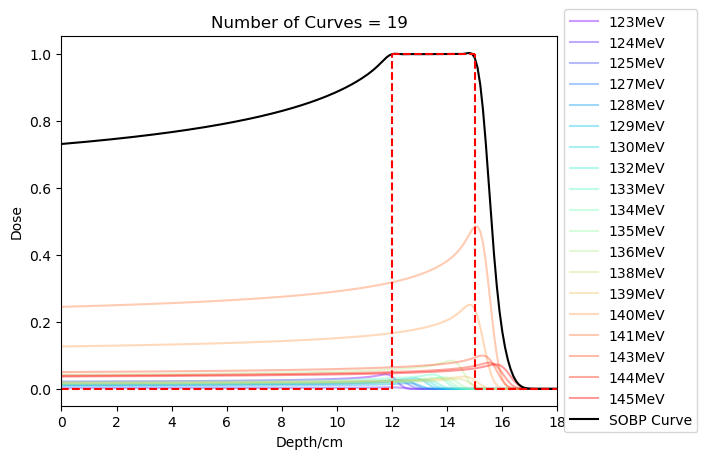

20 Curves
[123.         124.15789474 125.31578947 126.47368421 127.63157895
 128.78947368 129.94736842 131.10526316 132.26315789 133.42105263
 134.57894737 135.73684211 136.89473684 138.05263158 139.21052632
 140.36842105 141.52631579 142.68421053 143.84210526 145.        ]
     pcost       dcost       gap    pres   dres
 0: -1.7621e-02  4.6320e+01  1e+02  2e+00  1e+01
 1: -2.0280e-02 -2.9849e+01  4e+01  5e-01  2e+00
 2:  2.0925e-03 -6.0437e-01  6e-01  6e-03  3e-02
 3: -2.5792e-02 -7.7467e-02  5e-02  8e-16  7e-18
 4: -4.1140e-02 -4.8744e-02  8e-03  6e-16  2e-18
 5: -4.3049e-02 -4.4135e-02  1e-03  4e-16  2e-18
 6: -4.3258e-02 -4.3350e-02  9e-05  5e-16  2e-18
 7: -4.3285e-02 -4.3299e-02  1e-05  7e-16  1e-18
 8: -4.3290e-02 -4.3292e-02  2e-06  3e-16  1e-18
 9: -4.3290e-02 -4.3291e-02  3e-07  5e-16  1e-18
10: -4.3291e-02 -4.3291e-02  5e-08  4e-16  2e-18
Optimal solution found.
1.4984357973737822e-13


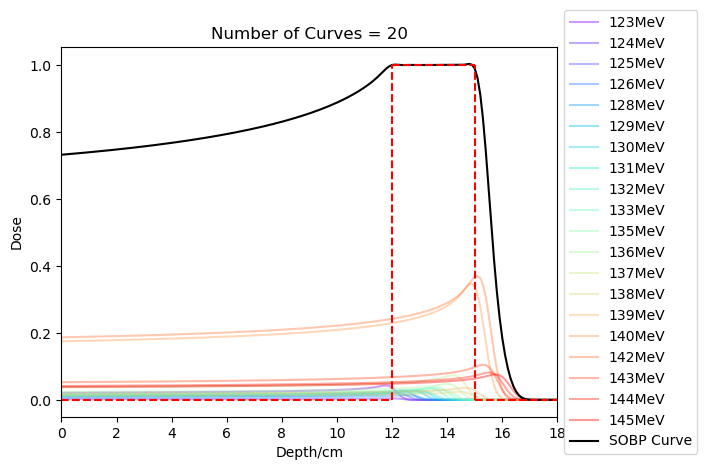

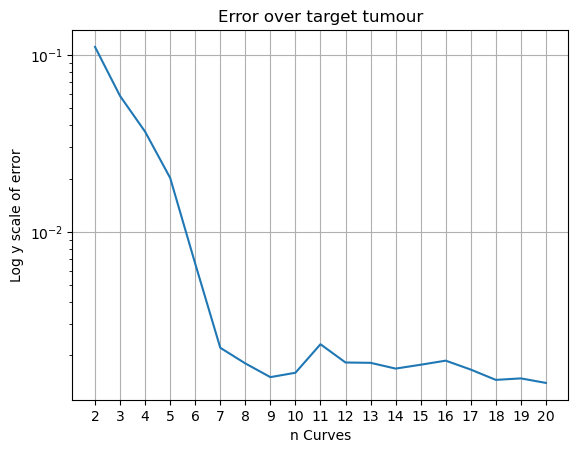

In [29]:
eZeroLower = 123;eZeroUpper = 145
yValues3,nminerr3 = PlotErrorStagnationQP(lower,upper,dose, perc,theta, phi,eZeroLower,eZeroUpper,ncurves)


Plot of different values of error

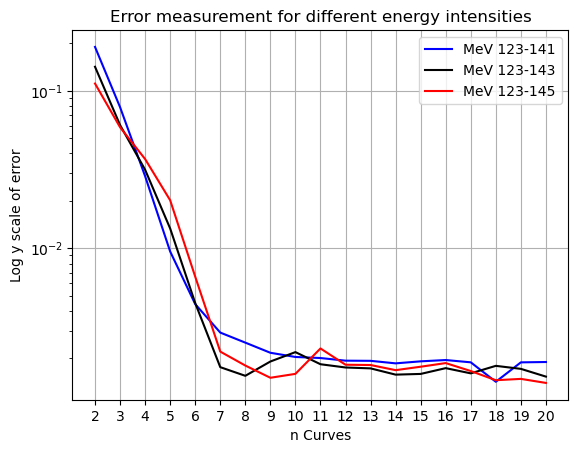

In [30]:
n=20
x = np.arange(2,n+1)
    
#Error stagnation plot
plt.plot(x,yValues,"b",label="MeV 123-141")
plt.plot(x,yValues2,"k",label="MeV 123-143")
plt.plot(x,yValues3,"r",label="MeV 123-145")
plt.legend()
plt.yscale('log')
plt.ylabel("Log y scale of error")
plt.xlabel("n Curves")
plt.title("Error measurement for different energy intensities")
plt.xticks(x)

plt.grid(True)
#plt.savefig('Error_qp_diffenergy.pdf',bbox_inches='tight')
plt.show()

Choosing energy between 123 and 143 , with 10 curves

     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-19
 7: -2.0663e-02 -2.0684e-02  2e-05  7e-16  5e-19
 8: -2.0670e-02 -2.0673e-02  3e-06  7e-16  5e-19
 9: -2.0671e-02 -2.0671e-02  5e-07  7e-16  3e-19
10: -2.0671e-02 -2.0671e-02  7e-08  7e-16  3e-19
Optimal solution found.


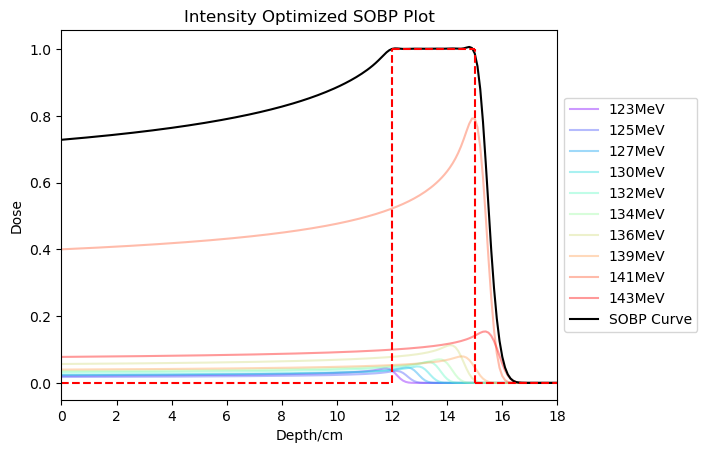

In [36]:
eVals = np.linspace(123,143,10)
#eVals2 = np.linspace(124,140,10)

lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
perc = 0 #percentage above dose
omega_nmin,z,dlist = quadprog(lower, upper,dose, eVals, perc,theta, phi,1)
#omega = quadprog(lower, upper,dose, eVals2, perc,theta, phi,1)
#print('number of curves ' + str(nminerr))

10% above the dose with 8 curves

     pcost       dcost       gap    pres   dres
 0: -3.1842e-03  6.7504e+01  1e+02  2e+00  8e+00
 1: -6.0125e-03 -3.7982e+01  5e+01  5e-01  2e+00
 2:  6.1296e-03 -1.7746e+00  2e+00  2e-02  6e-02
 3:  2.1648e-03 -5.7171e-02  6e-02  7e-05  3e-04
 4: -1.4240e-02 -2.0952e-02  7e-03  7e-16  8e-19
 5: -1.6156e-02 -1.7004e-02  8e-04  6e-16  2e-19
 6: -1.6362e-02 -1.6512e-02  1e-04  1e-15  3e-19
 7: -1.6400e-02 -1.6420e-02  2e-05  8e-16  1e-19
 8: -1.6407e-02 -1.6410e-02  3e-06  8e-16  2e-19
 9: -1.6408e-02 -1.6409e-02  4e-07  7e-16  2e-19
10: -1.6408e-02 -1.6408e-02  6e-08  7e-16  1e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8529e-03  7.9176e+01  1e+02  2e+00  8e+00
 1: -1.0885e-02 -5.3902e+01  7e+01  6e-01  3e+00
 2:  2.6235e-03 -1.9485e+00  2e+00  2e-02  7e-02
 3: -6.7392e-04 -6.0007e-02  6e-02  8e-05  3e-04
 4: -1.7496e-02 -2.4598e-02  7e-03  1e-15  6e-19
 5: -1.9612e-02 -2.0539e-02  9e-04  8e-16  4e-19
 6: -1.9810e-02 -1.9961e-02  2e-04  1e-15  2e-1

(array([[ 1.24030823],
        [ 1.3115806 ],
        [ 1.60186511],
        [ 1.92548232],
        [ 2.54087535],
        [ 3.27716167],
        [ 7.12157764],
        [25.16375664]]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,


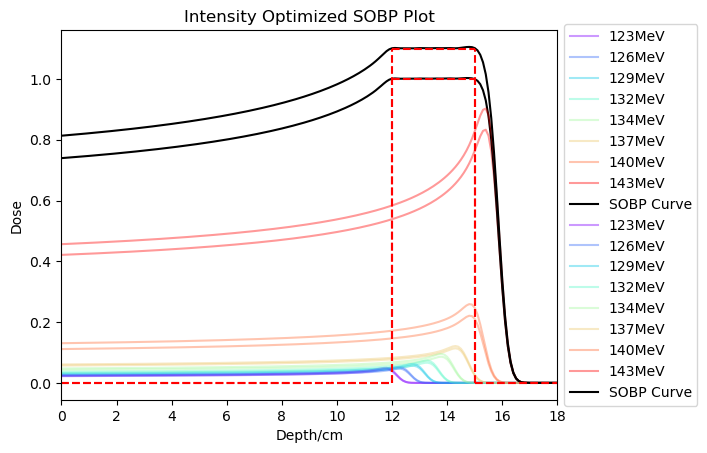

In [38]:
eVals = np.linspace(123,143,8)
#eVals2 = np.linspace(124,140,10)

lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
perc = 0.1 #percentage above dose
quadprog(lower, upper,dose, eVals, 0,theta, phi,1)
quadprog(lower, upper,dose, eVals, perc,theta, phi,1)

10% above the dose with 10 curves

     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-19
 7: -2.0663e-02 -2.0684e-02  2e-05  7e-16  5e-19
 8: -2.0670e-02 -2.0673e-02  3e-06  7e-16  5e-19
 9: -2.0671e-02 -2.0671e-02  5e-07  7e-16  3e-19
10: -2.0671e-02 -2.0671e-02  7e-08  7e-16  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.8932e-03  7.4869e+01  1e+02  2e+00  9e+00
 1: -1.5433e-02 -5.3637e+01  7e+01  6e-01  3e+00
 2:  1.0231e-03 -1.7297e+00  2e+00  2e-02  7e-02
 3: -3.6967e-03 -6.3200e-02  6e-02  4e-05  2e-04
 4: -2.2262e-02 -3.0707e-02  8e-03  1e-06  5e-06
 5: -2.4746e-02 -2.5831e-02  1e-03  1e-15  7e-19
 6: -2.4967e-02 -2.5132e-02  2e-04  1e-15  3e-1

(array([[ 1.1965997 ],
        [ 1.00424856],
        [ 1.31005362],
        [ 1.41957577],
        [ 1.827349  ],
        [ 2.09229313],
        [ 3.33711051],
        [ 2.37373685],
        [24.97254788],
        [ 3.72056513]]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11

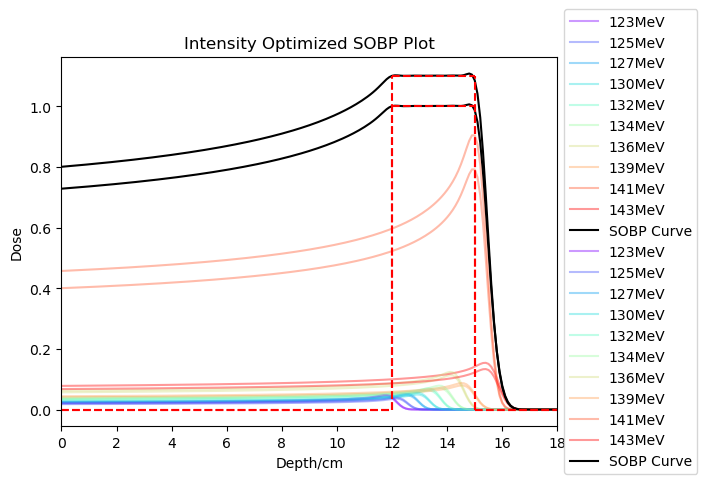

In [32]:
eVals = np.linspace(123,143,10)
#eVals2 = np.linspace(124,140,10)

lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
perc = 0.1 #percentage above dose
quadprog(lower, upper,dose, eVals, 0,theta, phi,1)
quadprog(lower, upper,dose, eVals, perc,theta, phi,1)

## Computational complexity

In [ ]:
import cProfile

In [ ]:
def comptime(lower, upper,dose, eZeroLower,eZeroUpper,perc,theta, phi,n):
    eVals = [] #defines list of energy values
    T1=[]


    for i in range(2,n+1): #plots SOBP for different numbers of curves
        eVals = []
        eVals = np.linspace(eZeroLower,eZeroUpper,i)
        print(str(len(eVals))+" Curves")
        profiler = cProfile.Profile()
        profiler.enable()

        omega,z,dlist = quadprog(lower, upper,dose, eVals, perc,theta, phi,0)
        profiler.disable()
        plt.show()
        stats = profiler.getstats()
        total_cumtime = sum(entry.totaltime for entry in stats)
        total_ncalls = sum(entry.callcount for entry in stats)
        T1.append(total_cumtime)
        print(f"Total cumulative time: {total_cumtime:.6f} seconds")
        print(f"Total number of calls: {total_ncalls}")
    
    return(T1)

In [ ]:
lower = 12;upper=15;dose = 1;
perc=0;
theta=1; phi=0;

n = 20


In [ ]:
eZeroLower = 123;
eZeroUpper = 141
T1 = comptime(lower, upper,dose, eZeroLower,eZeroUpper,perc,theta, phi,n)

In [ ]:
eZeroLower = 123;
eZeroUpper = 143
T2 = comptime(lower, upper,dose, eZeroLower,eZeroUpper,perc,theta, phi,n)

In [ ]:
eZeroLower = 123;
eZeroUpper = 145
T3 = comptime(lower, upper,dose, eZeroLower,eZeroUpper,perc,theta, phi,n)

In [ ]:
plt.plot(np.linspace(2,n,19), T1,'b',label='Time MeV 123-141')
plt.plot(np.linspace(2,n,19), T2,'r',label='Time  MeV 123-143')
plt.plot(np.linspace(2,n,19), T3,'k',label='Time  MeV 123-145')
plt.xlabel('$n$ curves')
plt.ylabel('Time(s)')
#plt.savefig(f'compcomplex.pdf',bbox_inches='tight')
#plt.legend()
plt.show()

analysis of the time it takes to run

In [ ]:
from scipy import stats

x = np.linspace(2,n,19)
y = T3

import csv
data = zip(x, y)

# Specify the CSV file path
#csv_file_path = "data_"+str(min(eVals))+"_"+str(max(eVals))+".csv"
#csv_file_path = "data_"+str(min(eVals))+"_145.csv"

# Write data to CSV file
#with open(csv_file_path, 'w', newline='') as csvfile:
 #   csvwriter = csv.writer(csvfile)
  #  csvwriter.writerow(["x", "y"])  # Write header
   # csvwriter.writerows(data)       # Write data rows

In [ ]:
# Given data
ncurves = np.linspace(2, n, 19)
alg_time = T2  # T1: 123-141, T2: 123-143, T3: 123-145 

# Linear regression
linearfit = linregress(ncurves, alg_time)
predicted_linear = linearfit.intercept + linearfit.slope * ncurves
plt.figure()
plt.plot(ncurves, alg_time, 'o', label='Data')
plt.yscale("log")
plt.plot(ncurves, predicted_linear, 'r-', label='Linear Fit')
plt.ylabel("Log scale of Time(s)")
plt.xlabel("$n$ curves")
plt.title("Linear regression")
plt.legend()
#plt.savefig('linreg.pdf',               bbox_inches='tight')
plt.show()

# nlogn
nlogn = ncurves * np.log(ncurves)
xlogx_fit = linregress(nlogn, alg_time)
predicted_nlogn = xlogx_fit.intercept + xlogx_fit.slope * nlogn
plt.figure()
plt.plot(ncurves, alg_time, 'o', label='Data')
plt.plot(ncurves, predicted_nlogn, 'r-', label='nlog(n) Fit')
plt.yscale("log")
plt.ylabel("Log scale of Time(s)")
plt.xlabel("$n$ curves")
plt.title("nLog(n)")
plt.legend()
#plt.savefig('nlogn.pdf',               bbox_inches='tight')
plt.show()

# Polynomial
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
ncurves_poly = poly_features.fit_transform(ncurves.reshape(-1, 1))
poly_fit = LinearRegression().fit(ncurves_poly, alg_time)
predicted_poly = poly_fit.predict(ncurves_poly)
plt.figure()
plt.plot(ncurves, alg_time, 'o', label='Data')
plt.plot(ncurves, predicted_poly, 'r-', label='Quadratic Fit')
plt.yscale("log")
plt.ylabel("Log scale of Time(s)")
plt.xlabel("$n$ curves")
plt.title("Quadratic polynomial")
plt.legend()
#plt.savefig('quad.pdf',                bbox_inches='tight')
plt.show()

# Exponential
def exponential_func(x, a, b):
    return a * np.exp(b * x)

params, covariance = curve_fit(exponential_func, ncurves, alg_time)
a_fit, b_fit = params

predicted_exp = exponential_func(ncurves, a_fit, b_fit)

plt.figure()
plt.plot(ncurves, alg_time, 'o', label='Data')
plt.plot(ncurves, predicted_exp, 'r-', label='Exponential Fit')
plt.yscale("log")
plt.title("Exponential")
plt.ylabel("Log scale of Time(s)")
plt.xlabel("$n$ curves")
plt.legend()
#plt.savefig('exp.pdf',               bbox_inches='tight')
plt.show()
exp_fit = linregress(np.log(alg_time), ncurves)
predicted_exp = np.exp(exp_fit.intercept + exp_fit.slope * ncurves)


# R-squared values
r_squared_values = [
    linearfit.rvalue**2,
    xlogx_fit.rvalue**2,
    poly_fit.score(ncurves_poly, alg_time),
    exp_fit.rvalue**2
]

r_squared_df = pd.DataFrame(r_squared_values, index=["Lineal", "nLog(n)", "Quadratic", "Exp"], columns=["R_squared"])
print(r_squared_df)

# Quadratic Programming with Regularisation

In [86]:
#Primary stage Parameters - not affected by Beam Initial Energy
p = 1.77
alpha = 0.0022
beta = 0.012
gamma = 0.6
epsilon = 0.0 #ranges 0.0 to 0.2
e_2 = 997 # density of the medium #rho
sd = 0.01

In [87]:
def quadprog_penalised(lower,upper,dose,eVals, percentage, theta, phi,lambda_reg, nplot,der):
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    a = np.zeros((n,n)) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float) 
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    z_values = np.arange(lower,upper,0.1)
    phi_z_star = np.zeros((len(z_values),n) ) #matriz of zeros
    
    g = np.eye(n) #identity matrix that corresponds to the weights being greater to zero (-Iw<=0), will be added to G 
    
    L = np.zeros((n,n)) #empty matrix to fill with derivatives
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper + valLower)
            
            a[i,j] = valCorrected 
            
            if der == 1:
                valDeriv,err = integrate.quad(FunctionDeriv_mult,lower,upper,args = (eValsij))    #first derivative
            elif der==2:
                valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))    # second derivative
            else: 
                valDeriv = 0
                
            L[i,j] = valDeriv 
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose*(1 + percentage)
    
    
    
    #Getting the the curve 
    for j in range(n):   
        curve=Functionb(z_values,eVals[j])
        phi_z_star[:,j] = curve.T
    
    g= np.vstack((phi_z_star, g))

    #matrix h that will contain the dose in the first row, and zeros in the rest so that 
    #the constraints are satisfied
    H=np.zeros(len(g))
    H[0:len(z_values)]=dose*(1 + percentage) #So the rule is to be 110% above the dose 
    
    #Quadratic optimisation
    l = matrix(L) #matrix of derivatives
    P_sinreg = matrix(a.T @ a)
    P = matrix(a.T @ a+ lambda_reg  * l )
    
    #P_pen = P + lambda_reg  * l
    q = matrix(-(a.T @ f))
    G= -matrix(g,tc='d')
    h = -matrix(H, tc='d')
#    sol = solvers.qp(P_pen,q,G,h)
    sol = solvers.qp(P,q,G,h) 
    omega = np.array(sol["x"])
     
    if nplot == 1 :
        colors = cm.rainbow(np.linspace(0, 1, n))
        for i in range(len(omega)):  #for all the weights 
            dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
            #plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
            #plt.plot(z,dList[i], label = str(round(eVals[i]))+'MeV', color = colors[i], alpha = 0.4)

    
        #######################################################################################
        # PLOTTING SPREAD OUT BRAGG PEAK and extras 

        d = sum(dList) #sum the di's

        #plt.plot(z,d, label = "SOBP Curve", color = "k") #plot


        #details
        
    return(omega,P_sinreg, l, P )

Analysis with 10 curves

In [92]:
n = 10
eVals = np.linspace(123,143,n)
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
perc = 0 #percentage above dose
nplot = 1
lambda_reg =  [0,.05,0.25,0.5,5,10]#[0,.05,0.25,0.5,1,1.5,5,10] #[0,0.00001,0.0001,0.001,0.01,0.1]  #[0,10,50,100]#[.05,0.25,0.5,1,1.5,5,10] #[0,0.0001,0.001,0.05,0.1]

     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-19
 7: -2.0663e-02 -2.0684e-02  2e-05  7e-16  5e-19
 8: -2.0670e-02 -2.0673e-02  3e-06  7e-16  5e-19
 9: -2.0671e-02 -2.0671e-02  5e-07  7e-16  3e-19
10: -2.0671e-02 -2.0671e-02  7e-08  7e-16  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8705e-03  6.3795e+01  1e+02  2e+00  9e+00
 1: -1.0168e-02 -4.1599e+01  5e+01  6e-01  2e+00
 2:  4.8157e-03 -1.8722e+00  2e+00  2e-02  8e-02
 3:  3.6073e-05 -6.3284e-02  6e-02  5e-05  2e-04
 4: -1.8329e-02 -2.5555e-02  7e-03  1e-15  7e-19
 5: -2.0404e-02 -2.1431e-02  1e-03  5e-16  5e-19
 6: -2.0628e-02 -2.0786e-02  2e-04  7e-16  5e-1

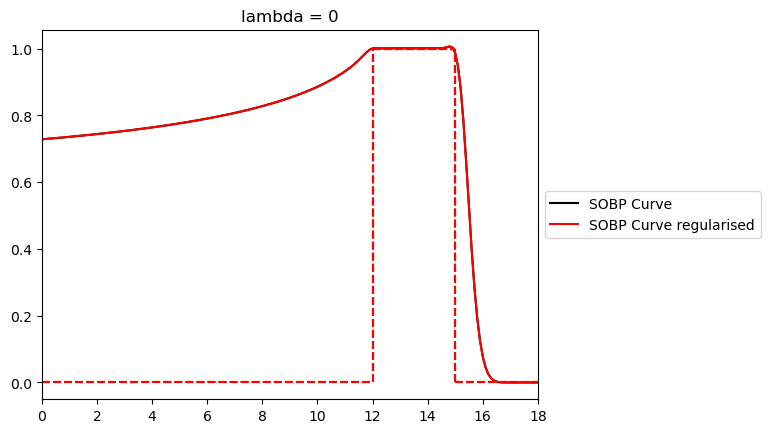

     pcost       dcost       gap    pres   dres
 0: -4.7956e-03  6.3795e+01  1e+02  2e+00  9e+00
 1:  6.7371e-04 -4.1585e+01  5e+01  6e-01  2e+00
 2:  1.8823e-02 -1.8416e+00  2e+00  2e-02  7e-02
 3:  8.6399e-03 -7.5381e-02  8e-02  1e-04  5e-04
 4: -1.6809e-02 -2.8381e-02  1e-02  2e-06  7e-06
 5: -2.0229e-02 -2.1858e-02  2e-03  7e-16  4e-19
 6: -2.0619e-02 -2.0765e-02  1e-04  9e-16  4e-19
 7: -2.0663e-02 -2.0678e-02  2e-05  7e-16  1e-19
 8: -2.0669e-02 -2.0671e-02  2e-06  2e-15  3e-19
 9: -2.0670e-02 -2.0670e-02  3e-07  3e-16  3e-19
10: -2.0670e-02 -2.0670e-02  4e-08  3e-16  4e-19
Optimal solution found.


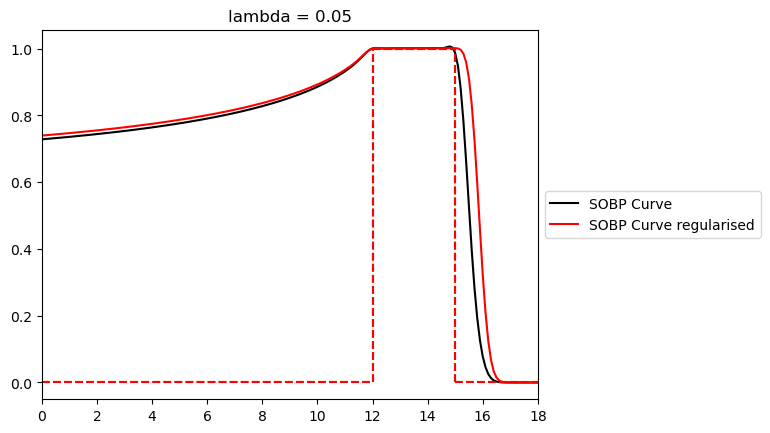

     pcost       dcost       gap    pres   dres
 0: -4.4963e-03  6.3796e+01  1e+02  2e+00  9e+00
 1:  4.3820e-02 -4.1529e+01  5e+01  6e-01  2e+00
 2:  7.2307e-02 -1.7477e+00  2e+00  2e-02  7e-02
 3:  2.4945e-02 -1.5154e-01  2e-01  9e-04  4e-03
 4: -1.1638e-02 -4.1892e-02  3e-02  6e-05  2e-04
 5: -1.9647e-02 -2.3596e-02  4e-03  4e-16  6e-19
 6: -2.0560e-02 -2.0878e-02  3e-04  1e-15  3e-19
 7: -2.0652e-02 -2.0684e-02  3e-05  1e-15  6e-19
 8: -2.0665e-02 -2.0669e-02  4e-06  7e-16  4e-19
 9: -2.0666e-02 -2.0667e-02  6e-07  7e-16  4e-19
10: -2.0667e-02 -2.0667e-02  9e-08  7e-16  5e-19
Optimal solution found.


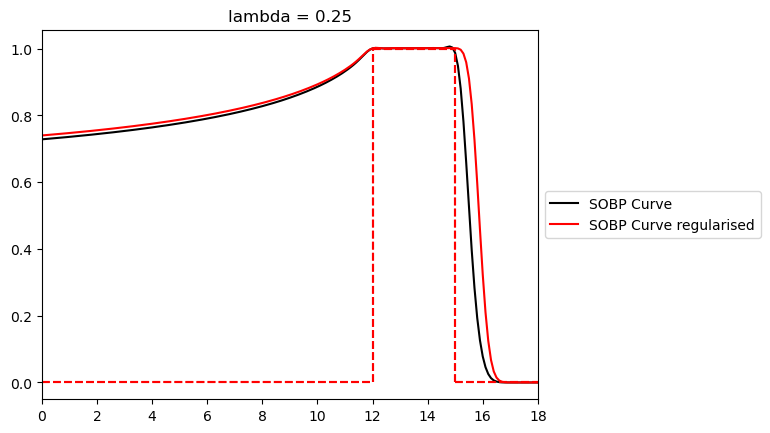

     pcost       dcost       gap    pres   dres
 0: -4.1231e-03  6.3798e+01  1e+02  2e+00  9e+00
 1:  9.7260e-02 -4.1459e+01  5e+01  6e-01  2e+00
 2:  1.3378e-01 -1.6693e+00  2e+00  2e-02  6e-02
 3:  3.3079e-02 -1.9177e-01  2e-01  1e-03  5e-03
 4: -1.0001e-02 -4.2317e-02  3e-02  3e-07  1e-06
 5: -1.9660e-02 -2.3400e-02  4e-03  7e-16  2e-18
 6: -2.0550e-02 -2.0849e-02  3e-04  7e-16  9e-19
 7: -2.0647e-02 -2.0679e-02  3e-05  7e-16  6e-19
 8: -2.0660e-02 -2.0665e-02  5e-06  7e-16  6e-19
 9: -2.0662e-02 -2.0663e-02  7e-07  3e-16  5e-19
10: -2.0662e-02 -2.0663e-02  1e-07  3e-16  7e-19
Optimal solution found.


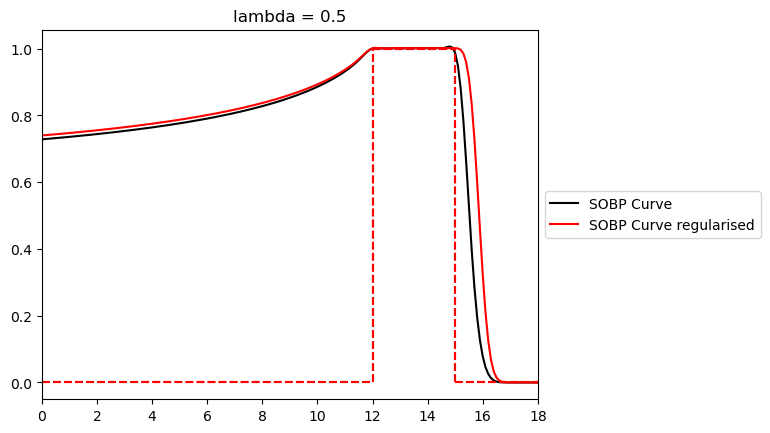

     pcost       dcost       gap    pres   dres
 0:  2.4563e-03  6.3822e+01  1e+02  2e+00  9e+00
 1:  9.7113e-01 -4.0191e+01  5e+01  6e-01  2e+00
 2:  6.5853e-01 -4.2660e+00  5e+00  4e-02  2e-01
 3:  8.5347e-02 -6.7110e-01  8e-01  5e-03  2e-02
 4:  1.0490e-02 -6.8527e-02  8e-02  8e-16  1e-17
 5: -1.7002e-02 -2.6945e-02  1e-02  9e-16  7e-18
 6: -2.0138e-02 -2.1208e-02  1e-03  5e-16  6e-18
 7: -2.0522e-02 -2.0650e-02  1e-04  3e-16  4e-18
 8: -2.0576e-02 -2.0594e-02  2e-05  4e-16  4e-18
 9: -2.0585e-02 -2.0587e-02  3e-06  3e-16  5e-18
10: -2.0586e-02 -2.0587e-02  3e-07  8e-16  6e-18
11: -2.0587e-02 -2.0587e-02  1e-07  3e-16  6e-18
Optimal solution found.


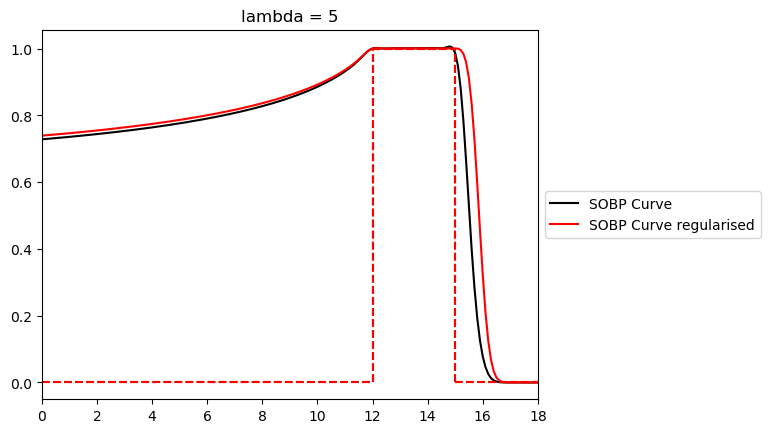

     pcost       dcost       gap    pres   dres
 0:  9.4671e-03  6.3847e+01  1e+02  2e+00  9e+00
 1:  1.7686e+00 -3.8785e+01  5e+01  5e-01  2e+00
 2:  7.8973e-01 -6.8127e+00  8e+00  7e-02  3e-01
 3:  9.8147e-02 -9.6192e-01  1e+00  8e-03  3e-02
 4:  1.2522e-02 -7.3099e-02  9e-02  4e-05  2e-04
 5: -1.6405e-02 -2.7309e-02  1e-02  2e-15  2e-17
 6: -1.9980e-02 -2.1205e-02  1e-03  1e-15  2e-17
 7: -2.0425e-02 -2.0571e-02  1e-04  1e-15  1e-17
 8: -2.0490e-02 -2.0510e-02  2e-05  3e-16  1e-17
 9: -2.0500e-02 -2.0503e-02  3e-06  7e-16  1e-17
10: -2.0502e-02 -2.0502e-02  2e-07  7e-16  1e-17
11: -2.0502e-02 -2.0502e-02  1e-07  1e-15  9e-18
12: -2.0502e-02 -2.0502e-02  1e-08  2e-15  1e-17
Optimal solution found.


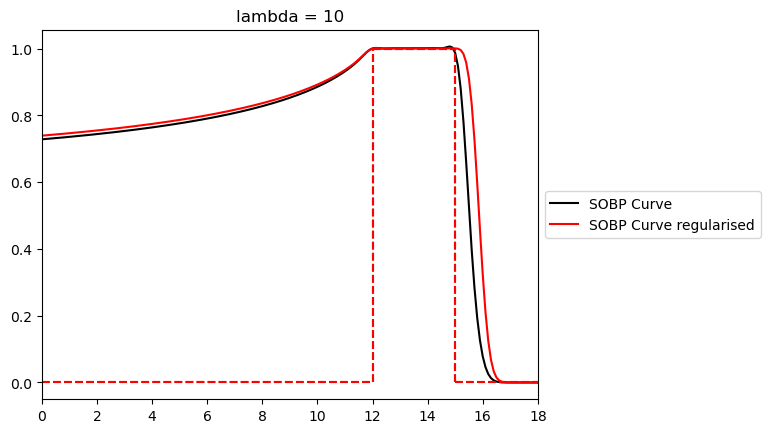

In [95]:
z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
omega_np,P_sinreg, l, P = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,0,nplot,der=0)
d = GetDb(z,omega_np,eVals)

for i in lambda_reg:
    omega,P_sinreg2, l, P  = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,i,nplot,der=1)
    d2 = GetDb(z,omega,eVals)
    plt.plot(z,d, "k",label = "SOBP Curve")
    plt.plot(z,d2,  "r", label = "SOBP Curve regularised")
    #plt.ylim([1.098,1.102])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("lambda = "+ str(i))
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([1.09,dose+percentage+0.02])
    plt.xlim([0,18])
    plt.savefig(f'regular_{n}_{i}.pdf',bbox_inches='tight')
    plt.show()

Analysis with 8 curves

In [96]:
n = 8
eVals = np.linspace(123,143,n)
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0
perc = 0 #percentage above dose
nplot = 1
lambda_reg =  [0,.05,0.25,0.5,5,10]

     pcost       dcost       gap    pres   dres
 0: -3.1842e-03  6.7504e+01  1e+02  2e+00  8e+00
 1: -6.0125e-03 -3.7982e+01  5e+01  5e-01  2e+00
 2:  6.1296e-03 -1.7746e+00  2e+00  2e-02  6e-02
 3:  2.1648e-03 -5.7171e-02  6e-02  7e-05  3e-04
 4: -1.4240e-02 -2.0952e-02  7e-03  7e-16  8e-19
 5: -1.6156e-02 -1.7004e-02  8e-04  6e-16  2e-19
 6: -1.6362e-02 -1.6512e-02  1e-04  1e-15  3e-19
 7: -1.6400e-02 -1.6420e-02  2e-05  8e-16  1e-19
 8: -1.6407e-02 -1.6410e-02  3e-06  8e-16  2e-19
 9: -1.6408e-02 -1.6409e-02  4e-07  7e-16  2e-19
10: -1.6408e-02 -1.6408e-02  6e-08  7e-16  1e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1842e-03  6.7504e+01  1e+02  2e+00  8e+00
 1: -6.0125e-03 -3.7982e+01  5e+01  5e-01  2e+00
 2:  6.1296e-03 -1.7746e+00  2e+00  2e-02  6e-02
 3:  2.1648e-03 -5.7171e-02  6e-02  7e-05  3e-04
 4: -1.4240e-02 -2.0952e-02  7e-03  7e-16  8e-19
 5: -1.6156e-02 -1.7004e-02  8e-04  6e-16  2e-19
 6: -1.6362e-02 -1.6512e-02  1e-04  1e-15  3e-1

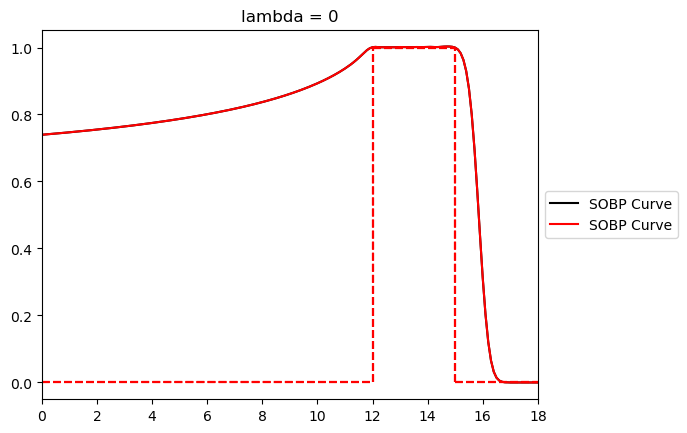

     pcost       dcost       gap    pres   dres
 0: -3.1370e-03  6.7503e+01  1e+02  2e+00  8e+00
 1:  5.8503e-03 -3.7966e+01  5e+01  5e-01  2e+00
 2:  2.0240e-02 -1.7784e+00  2e+00  2e-02  6e-02
 3:  1.0756e-02 -6.6641e-02  8e-02  1e-04  5e-04
 4: -1.1846e-02 -2.4851e-02  1e-02  9e-06  3e-05
 5: -1.5877e-02 -1.7718e-02  2e-03  7e-16  5e-19
 6: -1.6349e-02 -1.6521e-02  2e-04  4e-16  3e-19
 7: -1.6399e-02 -1.6417e-02  2e-05  3e-16  3e-19
 8: -1.6406e-02 -1.6409e-02  2e-06  4e-16  3e-19
 9: -1.6407e-02 -1.6408e-02  4e-07  2e-16  3e-19
10: -1.6408e-02 -1.6408e-02  5e-08  3e-16  3e-19
Optimal solution found.


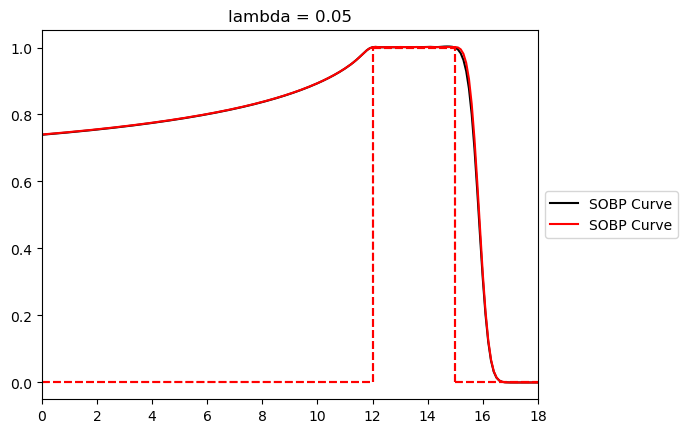

     pcost       dcost       gap    pres   dres
 0: -2.9483e-03  6.7501e+01  1e+02  2e+00  8e+00
 1:  5.3107e-02 -3.7905e+01  5e+01  5e-01  2e+00
 2:  7.3029e-02 -1.8268e+00  2e+00  2e-02  6e-02
 3:  2.6726e-02 -1.4391e-01  2e-01  9e-04  3e-03
 4: -7.6754e-03 -3.2811e-02  3e-02  1e-15  2e-18
 5: -1.5540e-02 -1.8582e-02  3e-03  7e-16  5e-19
 6: -1.6307e-02 -1.6569e-02  3e-04  3e-16  3e-19
 7: -1.6391e-02 -1.6419e-02  3e-05  2e-16  4e-19
 8: -1.6403e-02 -1.6407e-02  4e-06  3e-16  3e-19
 9: -1.6405e-02 -1.6405e-02  6e-07  3e-16  2e-19
10: -1.6405e-02 -1.6405e-02  8e-08  7e-16  5e-19
Optimal solution found.


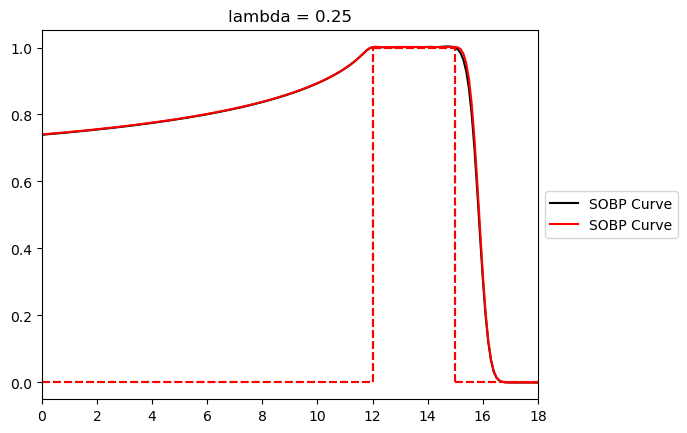

     pcost       dcost       gap    pres   dres
 0: -2.7128e-03  6.7498e+01  1e+02  2e+00  8e+00
 1:  1.1174e-01 -3.7829e+01  5e+01  5e-01  2e+00
 2:  1.3158e-01 -2.0036e+00  2e+00  2e-02  7e-02
 3:  3.9035e-02 -2.1477e-01  3e-01  2e-03  6e-03
 4: -3.5543e-03 -4.0186e-02  4e-02  3e-15  1e-18
 5: -1.5110e-02 -1.9488e-02  4e-03  9e-16  6e-19
 6: -1.6254e-02 -1.6644e-02  4e-04  3e-16  6e-19
 7: -1.6381e-02 -1.6423e-02  4e-05  7e-16  5e-19
 8: -1.6398e-02 -1.6404e-02  6e-06  4e-16  5e-19
 9: -1.6401e-02 -1.6402e-02  9e-07  7e-16  8e-19
10: -1.6401e-02 -1.6401e-02  1e-07  1e-15  7e-19
11: -1.6401e-02 -1.6401e-02  2e-08  7e-16  5e-19
Optimal solution found.


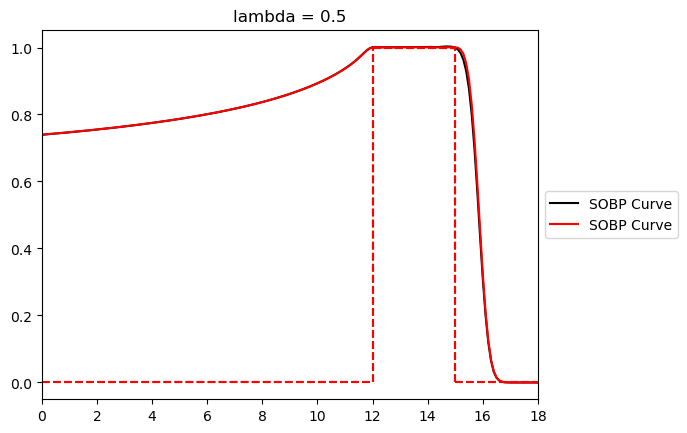

     pcost       dcost       gap    pres   dres
 0:  1.4544e-03  6.7443e+01  1e+02  2e+00  8e+00
 1:  1.0881e+00 -3.6421e+01  5e+01  5e-01  2e+00
 2:  5.8013e-01 -5.2791e+00  6e+00  5e-02  2e-01
 3:  1.1996e-01 -1.0111e+00  1e+00  9e-03  3e-02
 4:  1.1136e-02 -6.3958e-02  8e-02  1e-15  9e-18
 5: -1.3549e-02 -2.2823e-02  9e-03  5e-16  7e-18
 6: -1.6035e-02 -1.6890e-02  9e-04  7e-16  6e-18
 7: -1.6295e-02 -1.6380e-02  8e-05  3e-16  8e-18
 8: -1.6331e-02 -1.6343e-02  1e-05  7e-16  6e-18
 9: -1.6337e-02 -1.6338e-02  2e-06  1e-15  1e-18
10: -1.6338e-02 -1.6338e-02  2e-07  7e-16  6e-18
11: -1.6338e-02 -1.6338e-02  5e-08  7e-16  2e-18
Optimal solution found.


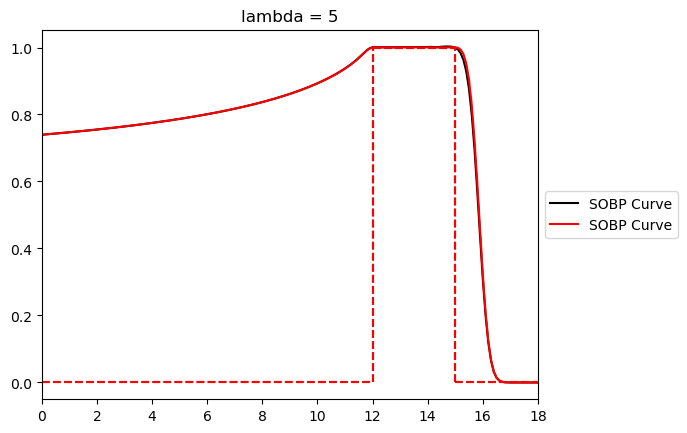

     pcost       dcost       gap    pres   dres
 0:  5.9302e-03  6.7497e+01  1e+02  2e+00  8e+00
 1:  2.0151e+00 -3.4514e+01  4e+01  5e-01  2e+00
 2:  7.1931e-01 -6.1960e+00  7e+00  6e-02  2e-01
 3:  9.2164e-02 -1.0814e+00  1e+00  9e-03  3e-02
 4:  9.8930e-03 -6.1785e-02  7e-02  7e-16  3e-17
 5: -1.3596e-02 -2.2383e-02  9e-03  1e-15  3e-17
 6: -1.5967e-02 -1.6767e-02  8e-04  4e-16  9e-18
 7: -1.6223e-02 -1.6305e-02  8e-05  2e-15  1e-17
 8: -1.6260e-02 -1.6271e-02  1e-05  7e-16  2e-17
 9: -1.6266e-02 -1.6268e-02  1e-06  2e-16  2e-17
10: -1.6267e-02 -1.6267e-02  1e-07  7e-16  2e-17
11: -1.6267e-02 -1.6267e-02  1e-07  3e-16  1e-17
12: -1.6267e-02 -1.6267e-02  5e-09  7e-16  9e-18
Optimal solution found.


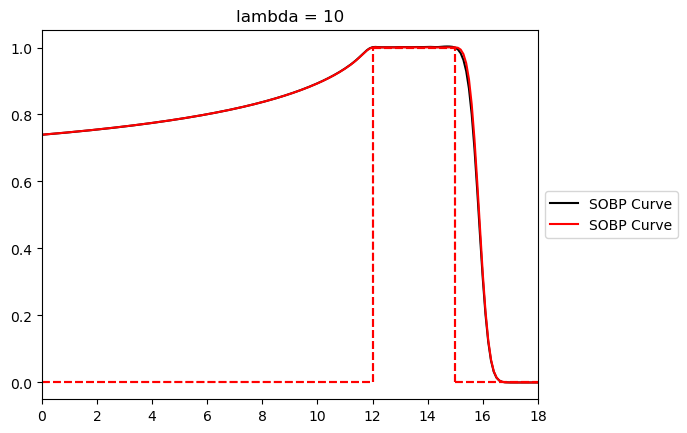

In [97]:
z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
omega_np,P_sinreg, l, P = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,0,nplot,der=0)
d = GetDb(z,omega_np,eVals)

for i in lambda_reg:
    omega,P_sinreg, l, P  = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,i,nplot,der=1)
    d2 = GetDb(z,omega,eVals)
    plt.plot(z,d, "k",label = "SOBP Curve")
    plt.plot(z,d2,  "r", label = "SOBP Curve")
    #plt.ylim([1.098,1.102])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("lambda = "+ str(i))
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([1.09,dose+percentage+0.02])
    plt.xlim([0,18])
    plt.savefig(f'regular_{n}_{i}.pdf',bbox_inches='tight')
    plt.show()

In [81]:
#norma de froebenious
#eigenvalues de p + lambdal y ver si es positiva definida
lambda_reg = 0.1 
omega,P_sinreg, l, P = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,lambda_reg,0,der = 1)

print("P_noreg = "+ str(np.linalg.norm(P_sinreg, 'fro')*1000))
print("lambda *l = "+ str(np.linalg.norm(lambda_reg*l, 'fro')*1000))
print("P_reg = "+ str(np.linalg.norm(P, 'fro')*1000))
eigenvalues, _ = np.linalg.eig(P_sinreg)
all(eigenvalues > 0)

     pcost       dcost       gap    pres   dres
 0: -3.0898e-03  6.7503e+01  1e+02  2e+00  8e+00
 1:  1.7694e-02 -3.7951e+01  5e+01  5e-01  2e+00
 2:  3.3974e-02 -1.7853e+00  2e+00  2e-02  6e-02
 3:  1.6361e-02 -9.0567e-02  1e-01  3e-04  1e-03
 4: -9.7726e-03 -2.9715e-02  2e-02  3e-05  1e-04
 5: -1.5674e-02 -1.8297e-02  3e-03  9e-16  6e-19
 6: -1.6328e-02 -1.6562e-02  2e-04  7e-16  3e-19
 7: -1.6396e-02 -1.6419e-02  2e-05  7e-16  2e-19
 8: -1.6405e-02 -1.6409e-02  3e-06  7e-16  3e-19
 9: -1.6407e-02 -1.6407e-02  5e-07  7e-16  2e-19
10: -1.6407e-02 -1.6407e-02  7e-08  8e-16  2e-19
Optimal solution found.
P_noreg = 0.12824890472851497
lambda *l = 0.5090533473846369
P_reg = 0.5446746369621226


True

     pcost       dcost       gap    pres   dres
 0:  7.6252e-03  6.5689e+01  1e+02  2e+00  9e+00
 1:  1.8807e+00 -3.7611e+01  5e+01  5e-01  2e+00
 2:  7.4671e-01 -7.1542e+00  8e+00  7e-02  3e-01
 3:  1.1814e-01 -1.1808e+00  1e+00  1e-02  4e-02
 4:  1.3202e-02 -6.6574e-02  8e-02  9e-16  2e-17
 5: -1.4799e-02 -2.5027e-02  1e-02  6e-16  3e-17
 6: -1.7973e-02 -1.9079e-02  1e-03  4e-16  2e-17
 7: -1.8345e-02 -1.8466e-02  1e-04  3e-16  7e-18
 8: -1.8398e-02 -1.8414e-02  2e-05  2e-16  9e-18
 9: -1.8406e-02 -1.8409e-02  2e-06  7e-16  1e-17
10: -1.8408e-02 -1.8408e-02  2e-07  1e-15  1e-17
11: -1.8408e-02 -1.8408e-02  9e-08  7e-16  1e-17
Optimal solution found.
P_noreg = 0.16412893525236952
lambda *l = 56.27116328106821
P_reg = 56.299301851097795


True

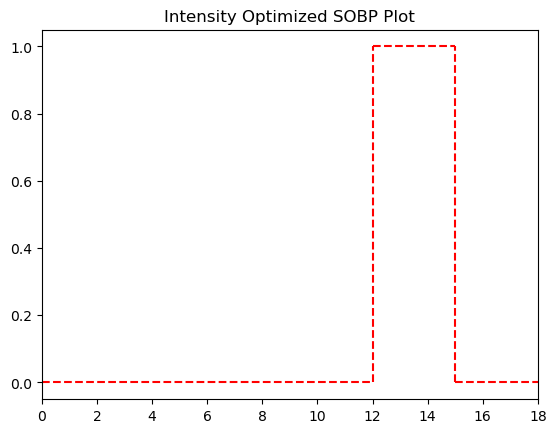

In [73]:
lambda_reg = 10
omega,P_sinreg, l, P = quadprog_penalised(lower, upper,dose, eVals, perc,theta, phi,lambda_reg,nplot,der = 1)

print("P_noreg = "+ str(np.linalg.norm(P_sinreg, 'fro')*1000))
print("lambda *l = "+ str(np.linalg.norm(lambda_reg*l, 'fro')*1000))
print("P_reg = "+ str(np.linalg.norm(P, 'fro')*1000))
eigenvalues, _ = np.linalg.eig(lambda_reg*l)
all(eigenvalues > 0)

# Plot of quadratic programming - zooming in

In [ ]:
eVals = np.linspace(123,143,10) #10 curves
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0

Percentage above Dose  = 0

In [ ]:
perc=0
omega,z,dList0 = quadprog(lower, upper,dose, eVals, perc,theta, phi,1)

In [ ]:
n=len(eVals)
#colors = cm.rainbow(np.linspace(0, 1, n))
#######################################################################################
# PLOTTING SPREAD OUT BRAGG PEAK and extras 

d0 = sum(dList0) #sum the di's

ax = plt.subplot(1, 1, 1)
ax.plot(z, d0,color = "k")

PlotCustomBox(upper,lower,dose) # plot target box

plt.title("Intensity Optimised SOBP Plot")
plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
#plt.ylim([1.1,1.1005])
plt.xlim([0,18])

#Create inset axes
axins = inset_axes(ax,  1, 1, loc=1, bbox_to_anchor=(0.4, 0.55),
                  bbox_transform=ax.figure.transFigure)
axins.plot(z, d0)

x1, x2 = 11.8, 12.3
y1, y2 = 0.998, 1.003

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none",ec="b",lw='0.2')

ax.indicate_inset_zoom(axins)
#2nd subfigure
axins2 = inset_axes(ax, 1, 1, loc=3, bbox_to_anchor=(0.95, 0.65),
                  bbox_transform=ax.figure.transFigure)

axins2.plot(z, d0)

x1, x2 = 14.5 , 15
y1, y2 = 1, 1.008
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

mark_inset(ax, axins2, loc1=2, loc2=3, fc="none", ec="b",lw='0.2')
ax.indicate_inset_zoom(axins2)
plt.draw()
plt.show()

In [ ]:
print(f"{1.003-0.998:.2%}") #proximal
print(f"{1.008-1:.2%}") #distal

Function for zoom in

In [ ]:
def plotzoom(lower, upper,dose, eVals,perc,theta, phi, zoomx,zoomy):
    omega,z,dList = quadprog(lower, upper,dose, eVals, perc,theta, phi,0)
    n=len(eVals)
    colors = cm.rainbow(np.linspace(0, 1, n))

    d = sum(dList) #sum the di's

    ax = plt.subplot(1, 1, 1)
    ax.plot(z, d,color = "k")

    PlotCustomBox(upper,lower,dose) # plot target box

    plt.title("Intensity Optimised SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.xlabel("Depth")
    plt.ylabel("Dose")
    plt.xlim([0,18])


    axins = inset_axes(ax, 1, 1, loc=1, bbox_to_anchor=(0.4, 0.55),
                      bbox_transform=ax.figure.transFigure)
    axins.plot(z, d)

    x1, x2 = zoomx[0], zoomx[1]
    y1, y2 = zoomy[0], zoomy[1] # 1.102-.00499,1.102#1.10, 1.102

    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="b",lw='0.2')
    ax.indicate_inset_zoom(axins)
    #2nd subfigure
    axins2 = inset_axes(ax, 1, 1, loc=3, bbox_to_anchor=(0.95, 0.65),
                      bbox_transform=ax.figure.transFigure)

    axins2.plot(z, d)

    x1, x2 = zoomx[2], zoomx[3]
    y1, y2 = zoomy[2], zoomy[3] #1.1001-.008,1.1001 

    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)

    mark_inset(ax, axins2, loc1=2, loc2=3, fc="none", ec="b",lw='0.2')
    ax.indicate_inset_zoom(axins2)
    print("Percentage above dose " + str(f"{perc:.0%}"))
    plt.draw()
    #plt.savefig(f'zoom_{lower}_{upper}_{n}.pdf',bbox_inches='tight')
    plt.show()
    
    return(print("proximal y scale: " + str(f"{zoomy[1]-zoomy[0]:.2%}") + ", distal y scale: " + str(f"{zoomy[3]- zoomy[2]:.2%}")))
           #,print(f"{1.1001-1.10:.2%}")) #proximal,  #distal)

In [ ]:
Vals = np.linspace(123,143,10) #10 curves
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0

perc=0 # dose = 1
zoomx = [12,12.5,14.5 , 15]
zoomy = [1, 1.002, 1, 1.008]
plotzoom(lower, upper,dose, eVals,perc,theta, phi, zoomx,zoomy)

perc=0.1 # dose = 1.1
zoomx = [12,12.5,14.5 , 15] #[proximal x1,x2 , distal x3,x4]
zoomy = [1.10, 1.102,1.101, 1.1055]
plotzoom(lower, upper,dose, eVals,perc,theta, phi, zoomx,zoomy)

Result with 5 curves

In [ ]:
eVals = np.linspace(123,143,5) 
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0

perc=0 # dose = 1
zoomx = [11.95,12.3,14.5 , 15]
zoomy = [0.998, 1.02, 1, 1.04]
plotzoom(lower, upper,dose, eVals,perc,theta, phi, zoomx,zoomy)

Result with 18 curves

In [ ]:
eVals = np.linspace(123,143,18) 
lower = 12;upper = 15; dose = 1
theta = 1; phi = 0

perc=0 # dose = 1
zoomx = [11.95,12.3,14.5 , 15]
zoomy = [0.998, 1.002, 1, 1.005]
plotzoom(lower, upper,dose, eVals,perc,theta, phi, zoomx,zoomy)

# Reading dicom files

In [ ]:
import pydicom

CT SCANS

In [ ]:
for i in range(20,21):
    dicom_file = pydicom.dcmread(f'CT.1.2.246.352.71.3.361940808526.1039{i}.20181108121857.dcm')
    #dicom_file = pydicom.dcmread(f'CT.1.2.246.352.71.3.361940808526.10388{i}.20181108121856.dcm')
    
    # Access DICOM metadata and pixel data
    patient_name = dicom_file.PatientName
    study_date = dicom_file.StudyDate
    pixel_array = dicom_file.pixel_array

    # Display the image using matplotlib
    plt.imshow(pixel_array, cmap=plt.cm.bone)  # You can choose different colormaps
    plt.title(f'CT Scan {i}')
   # plt.savefig(f'ctscan_{i}.pdf',bbox_inches='tight')
    plt.show()



SPR images

In [ ]:
for i in range(150,154):
    dicom_file = pydicom.dcmread(f'SPR_MAP_slice={i}.dcm')
    # Access DICOM metadata and pixel data
    patient_name = dicom_file.PatientName
    study_date = dicom_file.StudyDate
    pixel_array = dicom_file.pixel_array

    # Display the image using matplotlib
    plt.imshow(pixel_array, cmap=plt.cm.bone)  # You can choose different colormaps
    plt.title(f'SPR {i}')
    plt.savefig(f'spr_{i}.pdf',bbox_inches='tight')
    plt.show()

